In [1]:
sim_results = []
fit_results = []
def sim(Bmw):
    laser_intens = 0.01 * 10     # W/m²
    b_longitudinal = 0.1    # G
    ham_clock = hamil(0, b_longitudinal=b_longitudinal,
                    laser_intens=laser_intens, mw_mag_field=0)
    laser_ss = steadystate(
        ham_clock,
        c_op_list=decays
    )
    # plot_bar_excited_pop_D1(laser_ss)
    # plot_bar_ground_pop(laser_ss)
    mw_detuning = (ham_clock[3, 3] - ham_clock[0, 0])
    h = hamil(mw_detuning,
            b_longitudinal, 
            laser_intens=laser_intens, 
            mw_mag_field=Bmw)

     
    mw_ss = steadystate(h, c_op_list=decays)
    # plot_bar_excited_pop_D1(mw_ss-laser_ss)
    # plot_bar_ground_pop(mw_ss-laser_ss)

     
    time_evo_options = Options(nsteps=2**5 * 1000)
    res = mesolve(
        h,
        rho0=laser_ss,
        tlist=np.linspace(0, 1e-3, 2000),
        c_ops=decays,
        options=time_evo_options,
        progress_bar=True
    )
    # plot_excited_states_time(res)
    # plot_ground_states_time(res)

     
    exc_states = np.array([sum(state.diag()[8:]) for state in res.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

     
    g=np.abs(exc_states)

     
    # plt.plot(g)

     
    f2_states = np.array([sum(state.diag()[3:8]) for state in res.states])
    # plt.plot(res.times, f2_states)#/f2_states[0])

     
    from lmfit.model import Model
    import numpy as np
    def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
        # C = 1 - A - steady                                   # we set  f(t=0) = 1
        # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
        return (
            steady
            + A * np.exp(- gamma1 * t)
            + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
            + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
        )
    from copy import copy



    y = g
    t = res.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    # try:
    #     pars = copy(resfit.params)
    # except NameError:
    pars["gamma1"].set(value=5e3)#, min=1e3, max=99e3)
    pars["gamma2"].set(value=5e3)#, min=1.000e3, max=66e3)
    pars["rabi"].set(value=22e3, min=0.1e3, max=77e3)
    # pars["A"].set(min=0, max=0.6, value=0.05)
    # pars["B"].set(min=0, max=0.6, value=0.01)
    # pars["C"].set(min=0, max=0.6, value=0.01)
    pars["A"].set(value=0.05e-5)
    pars["B"].set(value=0.1e-5)
    pars["C"].set(value=0.1e-5)
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)


    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    return res, resfit


Bs = np.linspace(1e-3, 1e-2, 10)
for B in Bs:
    a, b = sim(B)
    sim_results.append(a)
    fit_results.append(b)

NameError: name 'np' is not defined

In [2]:
from lmfit.models import LorentzianModel, ConstantModel
from init import *
decays = (
    natural_decay_ops_D1() 
    # + quenching_ops("D1") 
    + wall_coll("D1", gamma=1e3)
    # + dephasing_excited_states("D1", gamma=1e7)
    # + dephasing_ground_states_D1()
)


def hamil(
        mw_det,
        b_longitudinal=0.1,
        mw_mag_field=1e-2,
        laser_intens=OFF_RESONANT_SATURATION_INTENSITY_D1_PI_POL/5):

    # Atom-field Hamiltonian
    # sigma_plus
    ham_laser_atom = H_atom_field_D1(-1, E_0_plus(laser_intens)).full()
    # ham_laser_atom[8:11, :] = 0
    # ham_laser_atom[:, 8:11] = 0
    ham_laser_atom[:3, :] = 0       # F=1 -> F' neglected
    ham_laser_atom[:, :3] = 0
    ham_laser_atom[:, -5:] = 0
    ham_laser_atom[-5:, :] = 0
    # Hyperfine Structure with Zeeman levels
    hb0 = H_hfs_ground() + H_B(bz=b_longitudinal)
    eigvals, eigstates = hb0.eigenstates()
    F_states_reordered = [
        eigstates[2],
        eigstates[1],
        eigstates[0],
    ]
    for k in range(3, 3 + 5):
        F_states_reordered.append(eigstates[k])
    # Atom Hamiltonian in rotating frame
    ham_atom = H_atom(det_Light=0, line="D1").full()
    ham_atom[:8, :8] = hb0.transform(F_states_reordered).tidyup(atol=1e-3)
    ham_atom[8:, 8:] = hb0.transform(F_states_reordered).tidyup(atol=1e-3)/3   # for excited state: g'_F = g_F / 3

    diff_f2_fp1 = ham_atom[9, 9] - ham_atom[5, 5]  # laser resonant to F=2 m_F=-2 to F'=1, m'_F=-1
    for k in range(8, 16):
        ham_atom[k, k] -= diff_f2_fp1

    diff_f2_f1 = (ham_atom[5, 5]-ham_atom[1, 1])
    for k in range(3):
        ham_atom[k, k] += diff_f2_f1  # rotating frame mw

    # for k in range(8, 11):
    #     ham_atom[k, k] = 0      # we ignore F'=1
    # for k in range(11, 16):
    #     # laser resonant to all Zeeman levels
    #     ham_atom[k, k] = ham_atom[k-8, k-8]
    hb_ac = H_B(
        bx=mw_mag_field, 
        by=0
        ).transform(F_states_reordered).tidyup(atol=1e-3)  # transverse MW field
    hb_ac = hb_ac.full()
    for i in range(7):  # RWA
        hb_ac[i, i + 1] = 0.0
        hb_ac[i + 1, i] = 0.0
    h_a_mw = np.zeros(shape=(16, 16), dtype=np.cdouble)
    h_a_mw[:8, :8] = hb_ac
    ham_tot = ham_atom + h_a_mw + ham_laser_atom
    for k in range(3):
        ham_tot[k, k] += mw_det
    offset = ham_tot[1, 1]
    for k in range(16):
        ham_tot[k, k] -= offset
    return Qobj(ham_tot).tidyup(atol=1e-3)


def P_loop(b_mw, radius=0.7e-2, distance=0.03):
    return (
        b_mw * 1e-4
        * (constants.mu_0
            * radius**2
            / (2 * (distance**2 + radius**2) ** (3 / 2)))**(-1)
    )**2 * 50

In [3]:
import numpy as np

In [4]:
import numpy as np
sim_results = []
fit_results = []
def sim(Bmw):
    laser_intens = 0.01 * 10     # W/m²
    b_longitudinal = 0.1    # G
    ham_clock = hamil(0, b_longitudinal=b_longitudinal,
                    laser_intens=laser_intens, mw_mag_field=0)
    laser_ss = steadystate(
        ham_clock,
        c_op_list=decays
    )
    # plot_bar_excited_pop_D1(laser_ss)
    # plot_bar_ground_pop(laser_ss)
    mw_detuning = (ham_clock[3, 3] - ham_clock[0, 0])
    h = hamil(mw_detuning,
            b_longitudinal, 
            laser_intens=laser_intens, 
            mw_mag_field=Bmw)

     
    mw_ss = steadystate(h, c_op_list=decays)
    # plot_bar_excited_pop_D1(mw_ss-laser_ss)
    # plot_bar_ground_pop(mw_ss-laser_ss)

     
    time_evo_options = Options(nsteps=2**5 * 1000)
    res = mesolve(
        h,
        rho0=laser_ss,
        tlist=np.linspace(0, 1e-3, 2000),
        c_ops=decays,
        options=time_evo_options,
        progress_bar=True
    )
    # plot_excited_states_time(res)
    # plot_ground_states_time(res)

     
    exc_states = np.array([sum(state.diag()[8:]) for state in res.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

     
    g=np.abs(exc_states)

     
    # plt.plot(g)

     
    f2_states = np.array([sum(state.diag()[3:8]) for state in res.states])
    # plt.plot(res.times, f2_states)#/f2_states[0])

     
    from lmfit.model import Model
    import numpy as np
    def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
        # C = 1 - A - steady                                   # we set  f(t=0) = 1
        # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
        return (
            steady
            + A * np.exp(- gamma1 * t)
            + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
            + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
        )
    from copy import copy



    y = g
    t = res.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    # try:
    #     pars = copy(resfit.params)
    # except NameError:
    pars["gamma1"].set(value=5e3)#, min=1e3, max=99e3)
    pars["gamma2"].set(value=5e3)#, min=1.000e3, max=66e3)
    pars["rabi"].set(value=22e3, min=0.1e3, max=77e3)
    # pars["A"].set(min=0, max=0.6, value=0.05)
    # pars["B"].set(min=0, max=0.6, value=0.01)
    # pars["C"].set(min=0, max=0.6, value=0.01)
    pars["A"].set(value=0.05e-5)
    pars["B"].set(value=0.1e-5)
    pars["C"].set(value=0.1e-5)
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)


    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    return res, resfit


Bs = np.linspace(1e-3, 1e-2, 10)
for B in Bs:
    a, b = sim(B)
    sim_results.append(a)
    fit_results.append(b)

UnboundLocalError: local variable 'np' referenced before assignment

In [6]:
import numpy as np

In [7]:
sim_results = []
fit_results = []
def sim(Bmw):
    laser_intens = 0.01 * 10     # W/m²
    b_longitudinal = 0.1    # G
    ham_clock = hamil(0, b_longitudinal=b_longitudinal,
                    laser_intens=laser_intens, mw_mag_field=0)
    laser_ss = steadystate(
        ham_clock,
        c_op_list=decays
    )
    # plot_bar_excited_pop_D1(laser_ss)
    # plot_bar_ground_pop(laser_ss)
    mw_detuning = (ham_clock[3, 3] - ham_clock[0, 0])
    h = hamil(mw_detuning,
            b_longitudinal, 
            laser_intens=laser_intens, 
            mw_mag_field=Bmw)

     
    mw_ss = steadystate(h, c_op_list=decays)
    # plot_bar_excited_pop_D1(mw_ss-laser_ss)
    # plot_bar_ground_pop(mw_ss-laser_ss)

     
    time_evo_options = Options(nsteps=2**5 * 1000)
    res = mesolve(
        h,
        rho0=laser_ss,
        tlist=np.linspace(0, 1e-3, 2000),
        c_ops=decays,
        options=time_evo_options,
        progress_bar=True
    )
    # plot_excited_states_time(res)
    # plot_ground_states_time(res)

     
    exc_states = np.array([sum(state.diag()[8:]) for state in res.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

     
    g=np.abs(exc_states)

     
    # plt.plot(g)

     
    f2_states = np.array([sum(state.diag()[3:8]) for state in res.states])
    # plt.plot(res.times, f2_states)#/f2_states[0])

     
    from lmfit.model import Model
    import numpy as np
    def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
        # C = 1 - A - steady                                   # we set  f(t=0) = 1
        # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
        return (
            steady
            + A * np.exp(- gamma1 * t)
            + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
            + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
        )
    from copy import copy



    y = g
    t = res.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    # try:
    #     pars = copy(resfit.params)
    # except NameError:
    pars["gamma1"].set(value=5e3)#, min=1e3, max=99e3)
    pars["gamma2"].set(value=5e3)#, min=1.000e3, max=66e3)
    pars["rabi"].set(value=22e3, min=0.1e3, max=77e3)
    # pars["A"].set(min=0, max=0.6, value=0.05)
    # pars["B"].set(min=0, max=0.6, value=0.01)
    # pars["C"].set(min=0, max=0.6, value=0.01)
    pars["A"].set(value=0.05e-5)
    pars["B"].set(value=0.1e-5)
    pars["C"].set(value=0.1e-5)
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)


    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    return res, resfit


Bs = np.linspace(1e-3, 1e-2, 10)
for B in Bs:
    a, b = sim(B)
    sim_results.append(a)
    fit_results.append(b)

UnboundLocalError: local variable 'np' referenced before assignment

In [8]:
np

<module 'numpy' from 'c:\\Users\\m\\anaconda3\\envs\\masterarbeit_python39\\lib\\site-packages\\numpy\\__init__.py'>

In [9]:
sim_results = []
fit_results = []
def sim(Bmw):
    import numpy as np

    laser_intens = 0.01 * 10     # W/m²
    b_longitudinal = 0.1    # G
    ham_clock = hamil(0, b_longitudinal=b_longitudinal,
                    laser_intens=laser_intens, mw_mag_field=0)
    laser_ss = steadystate(
        ham_clock,
        c_op_list=decays
    )
    # plot_bar_excited_pop_D1(laser_ss)
    # plot_bar_ground_pop(laser_ss)
    mw_detuning = (ham_clock[3, 3] - ham_clock[0, 0])
    h = hamil(mw_detuning,
            b_longitudinal, 
            laser_intens=laser_intens, 
            mw_mag_field=Bmw)

     
    mw_ss = steadystate(h, c_op_list=decays)
    # plot_bar_excited_pop_D1(mw_ss-laser_ss)
    # plot_bar_ground_pop(mw_ss-laser_ss)

     
    time_evo_options = Options(nsteps=2**5 * 1000)
    res = mesolve(
        h,
        rho0=laser_ss,
        tlist=np.linspace(0, 1e-3, 2000),
        c_ops=decays,
        options=time_evo_options,
        progress_bar=True
    )
    # plot_excited_states_time(res)
    # plot_ground_states_time(res)

     
    exc_states = np.array([sum(state.diag()[8:]) for state in res.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

     
    g=np.abs(exc_states)

     
    # plt.plot(g)

     
    f2_states = np.array([sum(state.diag()[3:8]) for state in res.states])
    # plt.plot(res.times, f2_states)#/f2_states[0])

     
    from lmfit.model import Model
    import numpy as np
    def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
        # C = 1 - A - steady                                   # we set  f(t=0) = 1
        # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
        return (
            steady
            + A * np.exp(- gamma1 * t)
            + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
            + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
        )
    from copy import copy



    y = g
    t = res.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    # try:
    #     pars = copy(resfit.params)
    # except NameError:
    pars["gamma1"].set(value=5e3)#, min=1e3, max=99e3)
    pars["gamma2"].set(value=5e3)#, min=1.000e3, max=66e3)
    pars["rabi"].set(value=22e3, min=0.1e3, max=77e3)
    # pars["A"].set(min=0, max=0.6, value=0.05)
    # pars["B"].set(min=0, max=0.6, value=0.01)
    # pars["C"].set(min=0, max=0.6, value=0.01)
    pars["A"].set(value=0.05e-5)
    pars["B"].set(value=0.1e-5)
    pars["C"].set(value=0.1e-5)
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)


    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    return res, resfit


Bs = np.linspace(1e-3, 1e-2, 10)
for B in Bs:
    a, b = sim(B)
    sim_results.append(a)
    fit_results.append(b)

10.0%. Run time:  22.34s. Est. time left: 00:00:03:21
20.0%. Run time:  44.53s. Est. time left: 00:00:02:58
30.0%. Run time:  66.66s. Est. time left: 00:00:02:35
40.0%. Run time:  88.90s. Est. time left: 00:00:02:13
50.0%. Run time: 111.19s. Est. time left: 00:00:01:51
60.0%. Run time: 133.43s. Est. time left: 00:00:01:28
70.0%. Run time: 155.64s. Est. time left: 00:00:01:06
80.0%. Run time: 177.79s. Est. time left: 00:00:00:44
90.0%. Run time: 199.98s. Est. time left: 00:00:00:22
Total run time: 222.01s
10.0%. Run time:  57.17s. Est. time left: 00:00:08:34
20.0%. Run time: 114.36s. Est. time left: 00:00:07:37
30.0%. Run time: 171.60s. Est. time left: 00:00:06:40
40.0%. Run time: 228.85s. Est. time left: 00:00:05:43
50.0%. Run time: 286.05s. Est. time left: 00:00:04:46
60.0%. Run time: 343.21s. Est. time left: 00:00:03:48
70.0%. Run time: 400.34s. Est. time left: 00:00:02:51
80.0%. Run time: 457.49s. Est. time left: 00:00:01:54
90.0%. Run time: 514.64s. Est. time left: 00:00:00:57
Tota

In [10]:
e for e in fit_results:
    e.plot()

SyntaxError: invalid syntax (<ipython-input-10-366a603635c3>, line 1)

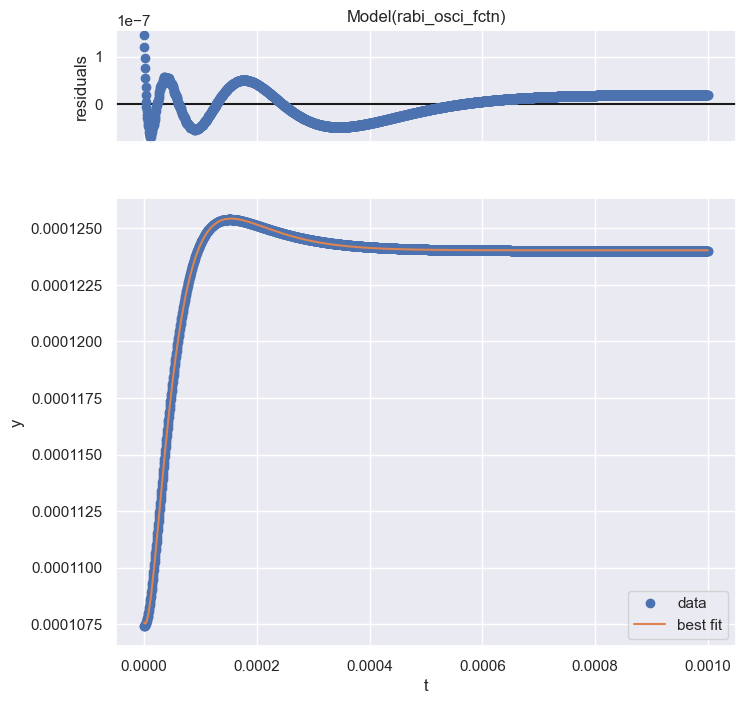

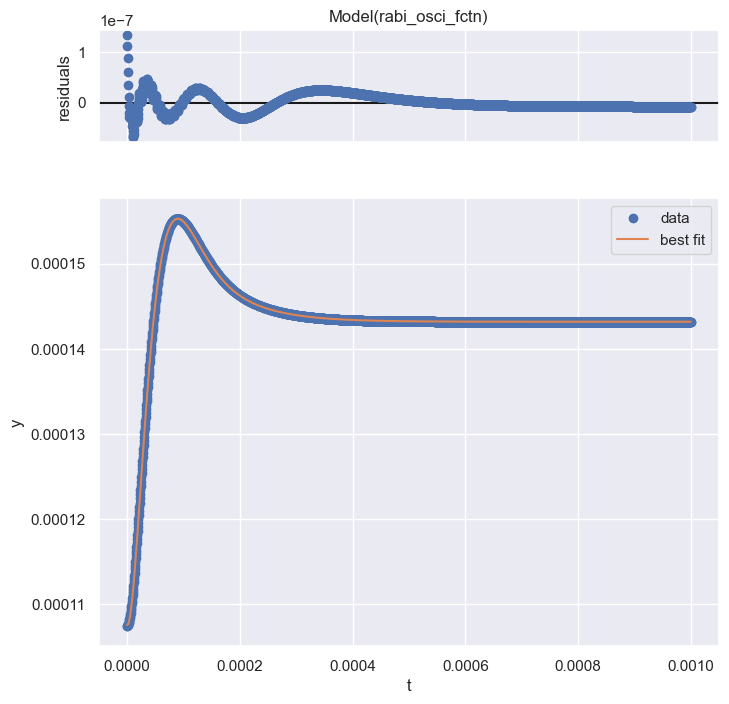

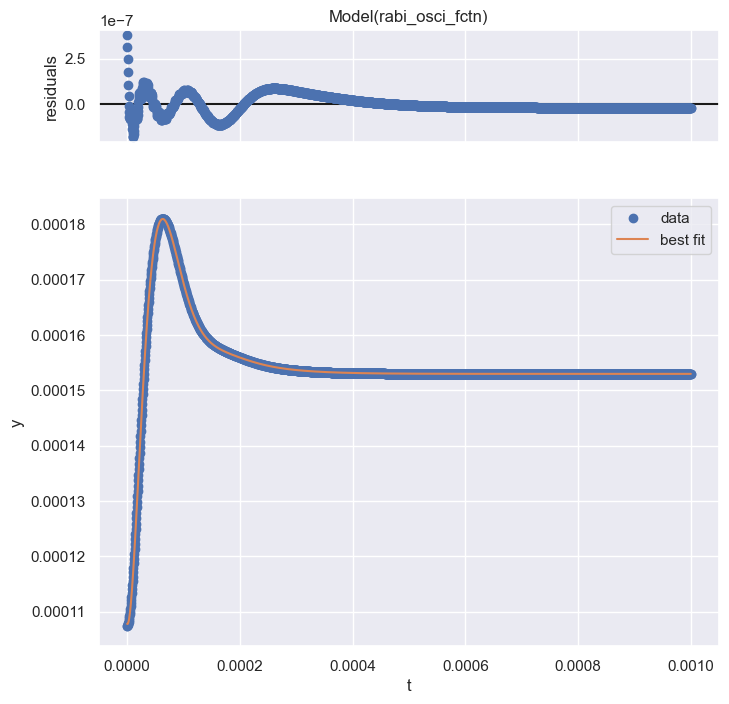

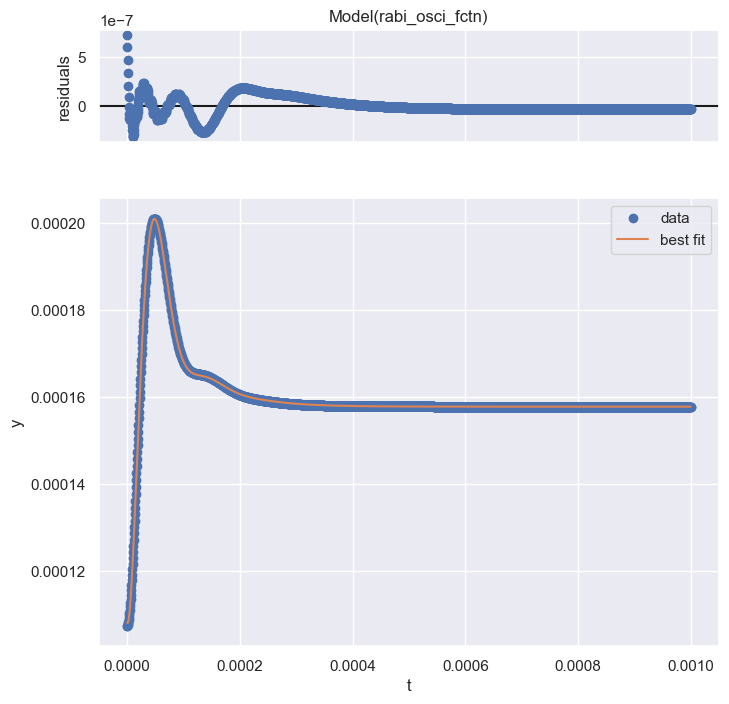

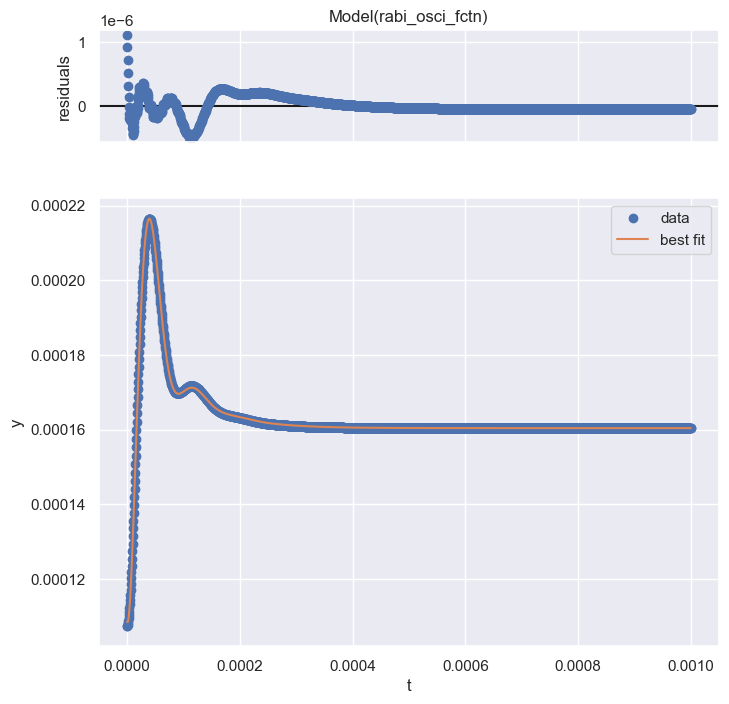

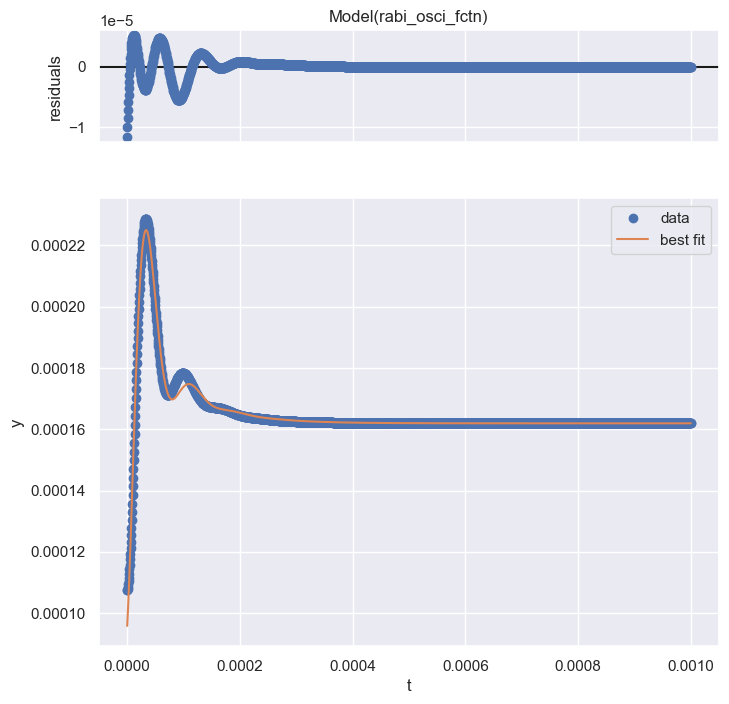

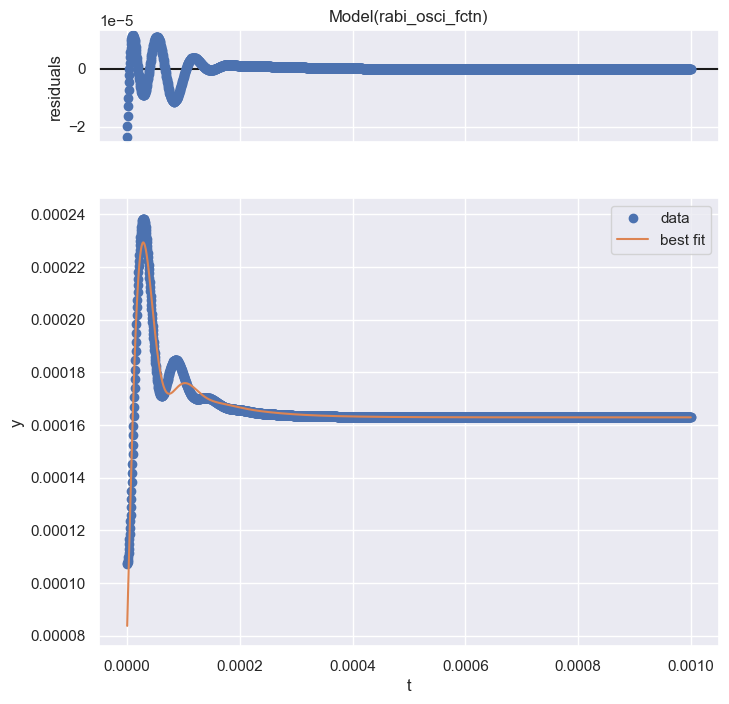

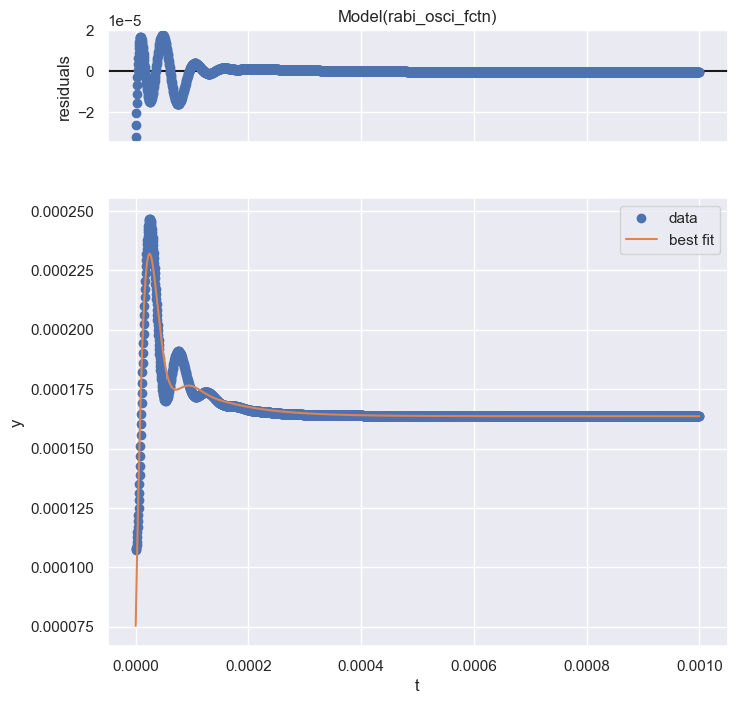

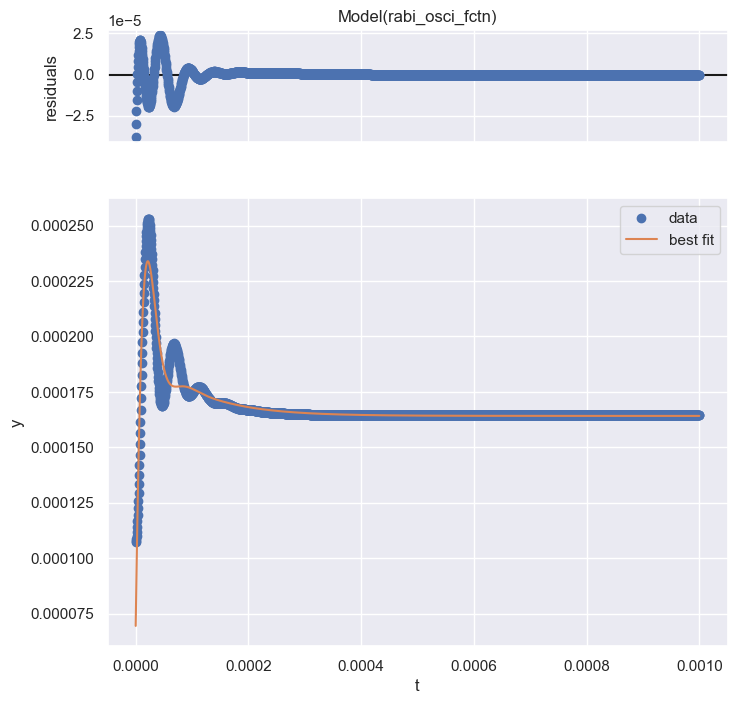

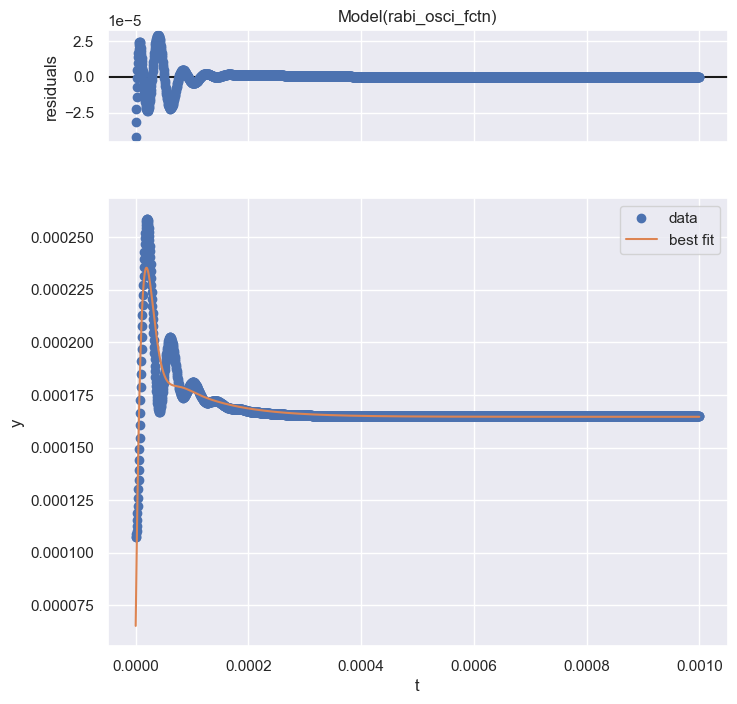

In [11]:
for e in fit_results:
    e.plot()

In [12]:
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in res.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = res.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    newfit.append(resfit)
    resfit.plot()

NameError: name 'res' is not defined

In [13]:
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = res.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    newfit.append(resfit)
    resfit.plot()

NameError: name 'res' is not defined

In [14]:
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = s.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    newfit.append(resfit)
    resfit.plot()

NameError: name 'Model' is not defined

In [15]:
from lmfit.model import Model

newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = s.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    newfit.append(resfit)
    resfit.plot()

NameError: name 'rabi_osci_fctn' is not defined

In [16]:
def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(- gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
    )

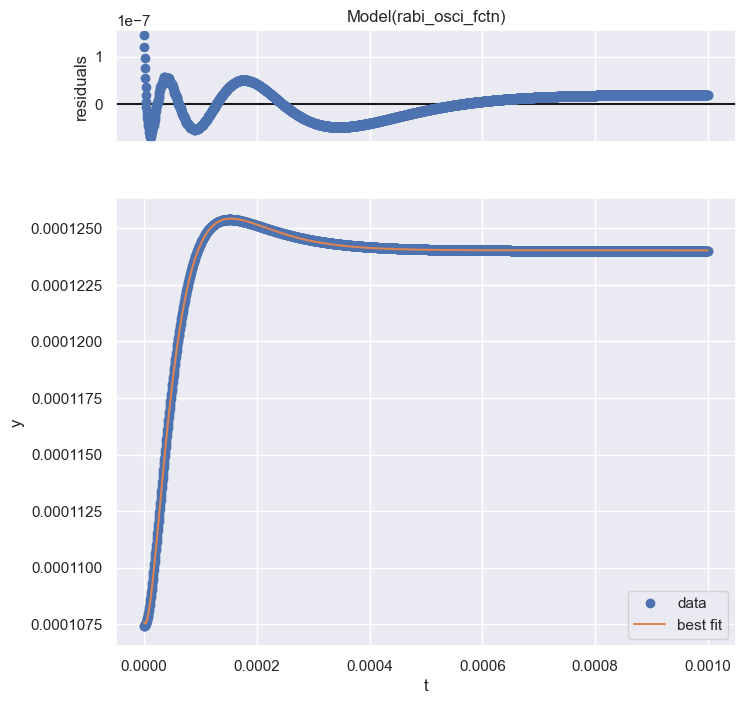

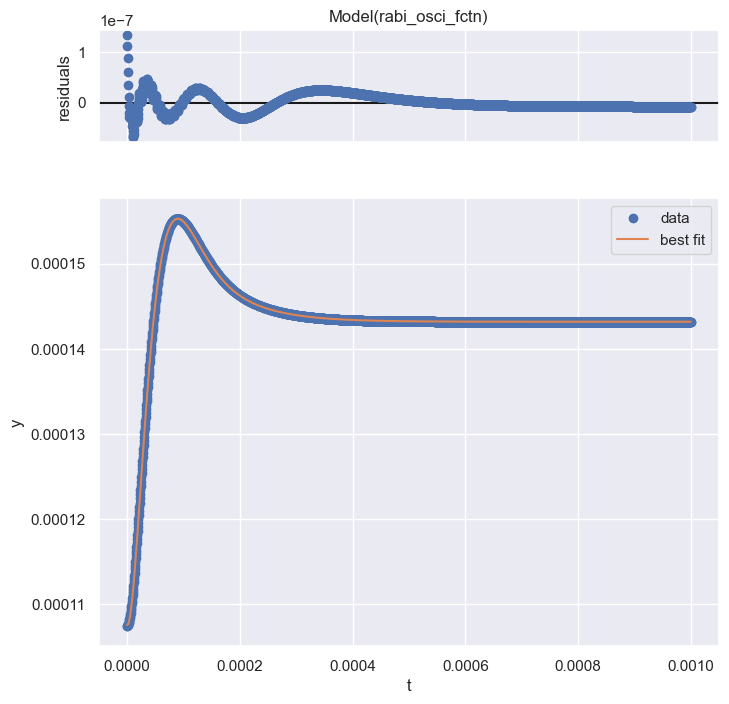

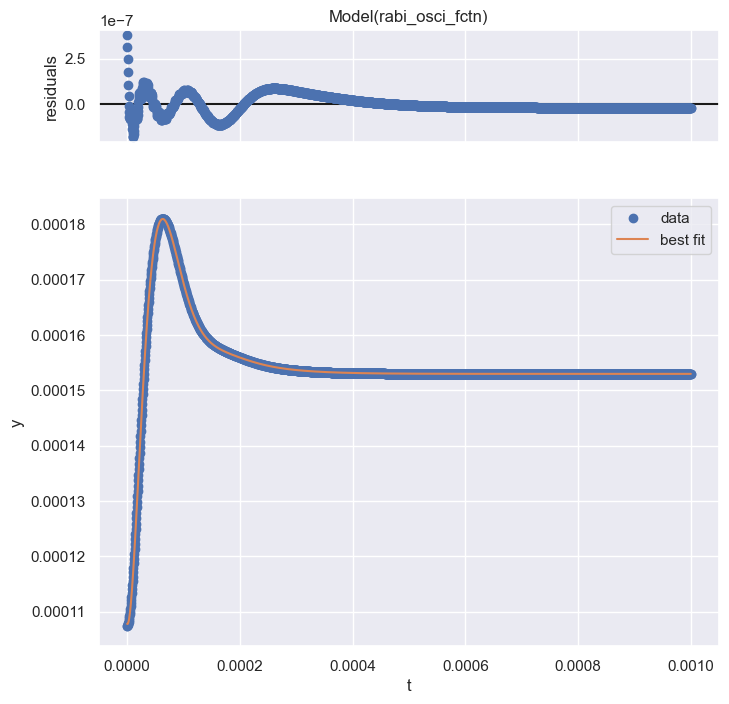

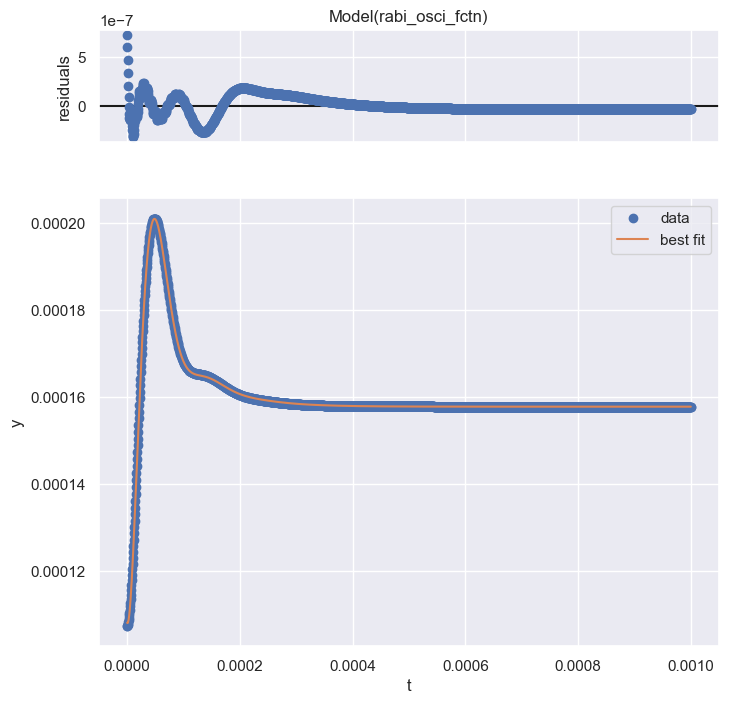

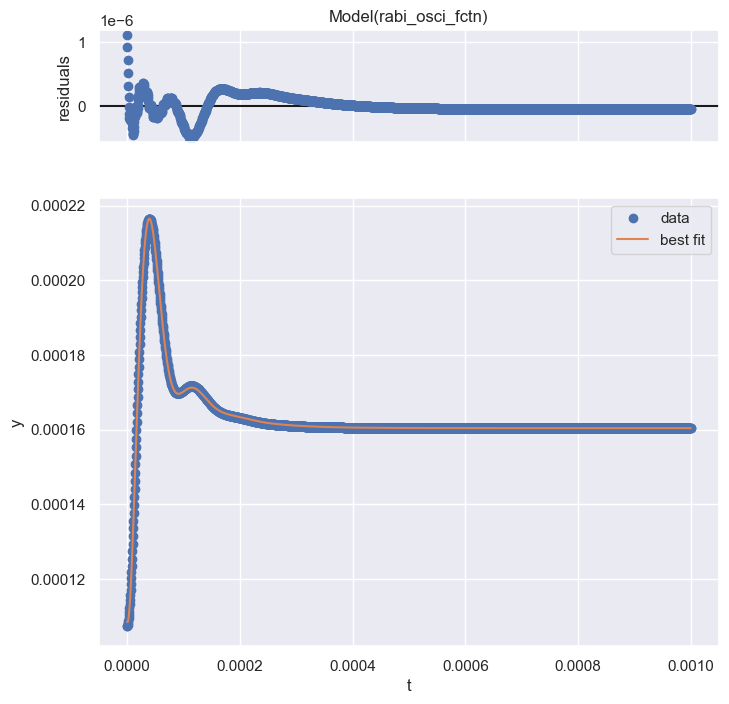

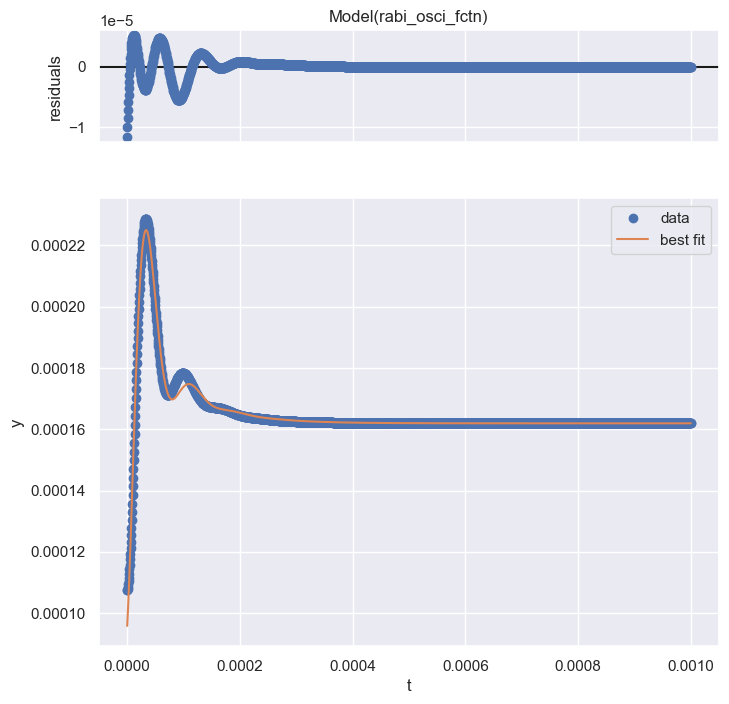

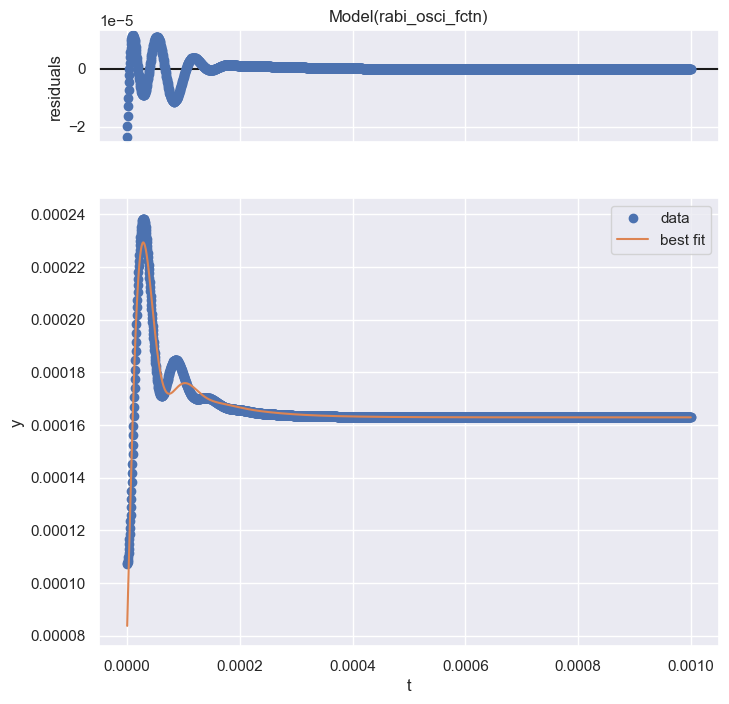

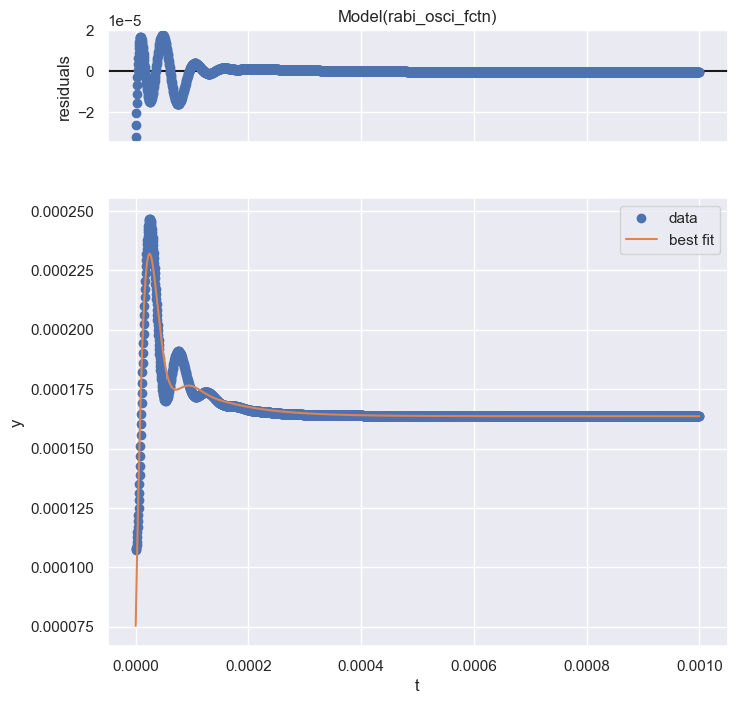

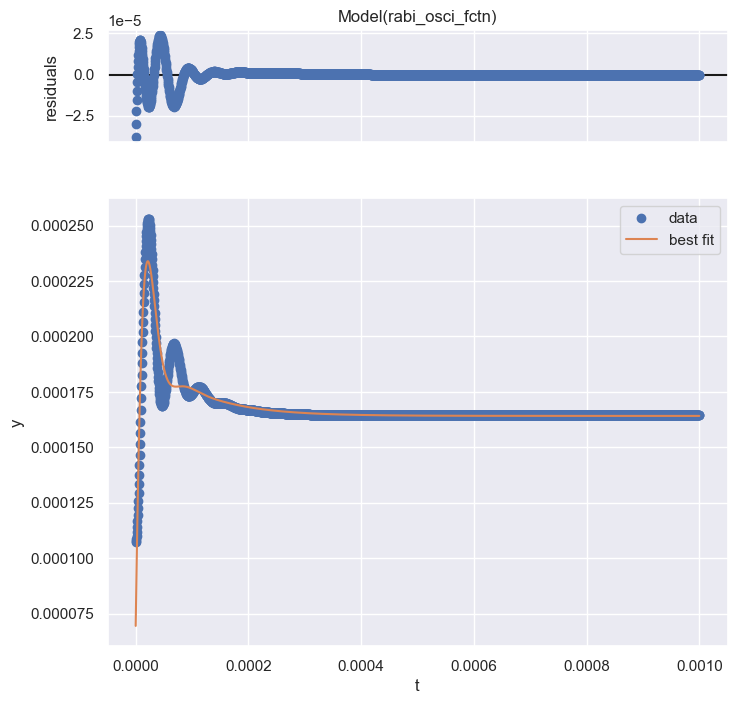

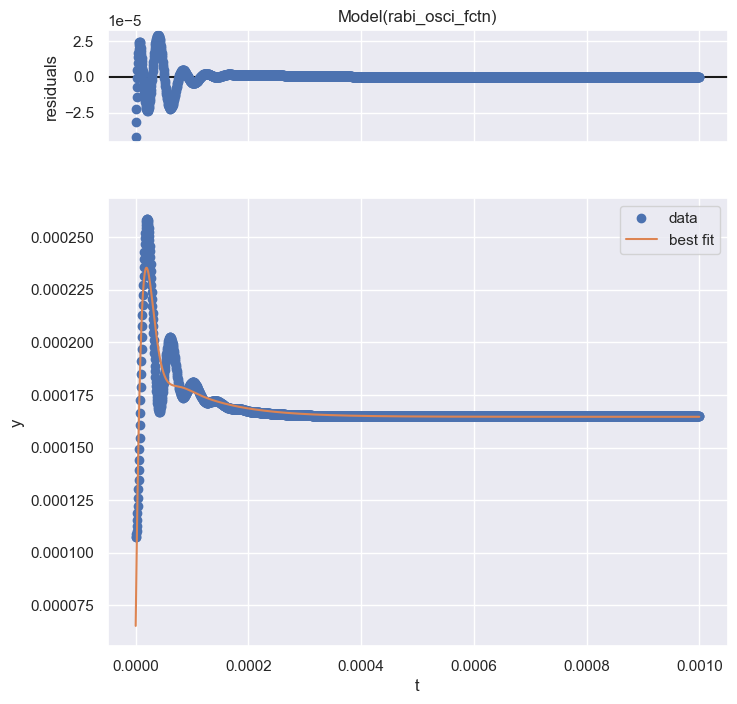

In [17]:
from lmfit.model import Model
def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(- gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
    )
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = s.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    newfit.append(resfit)
    resfit.plot()

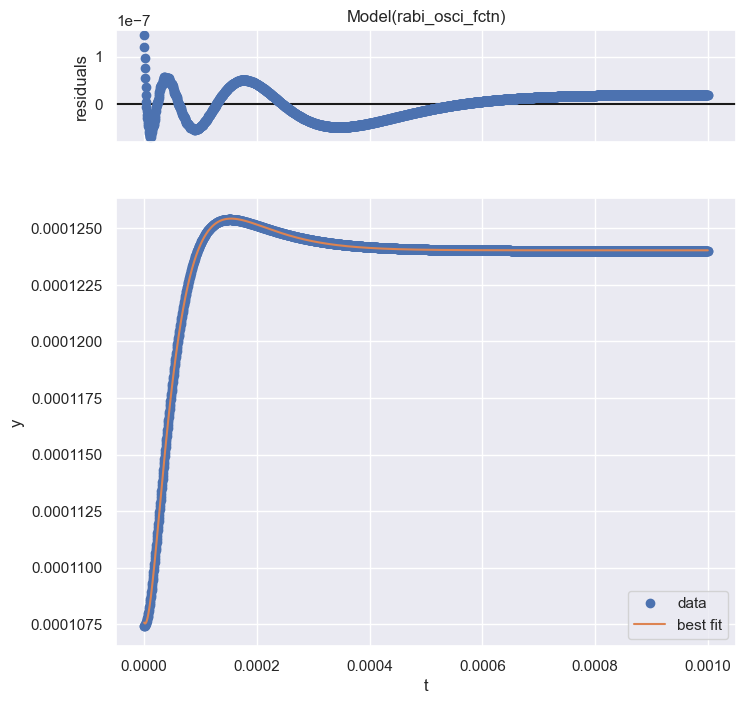

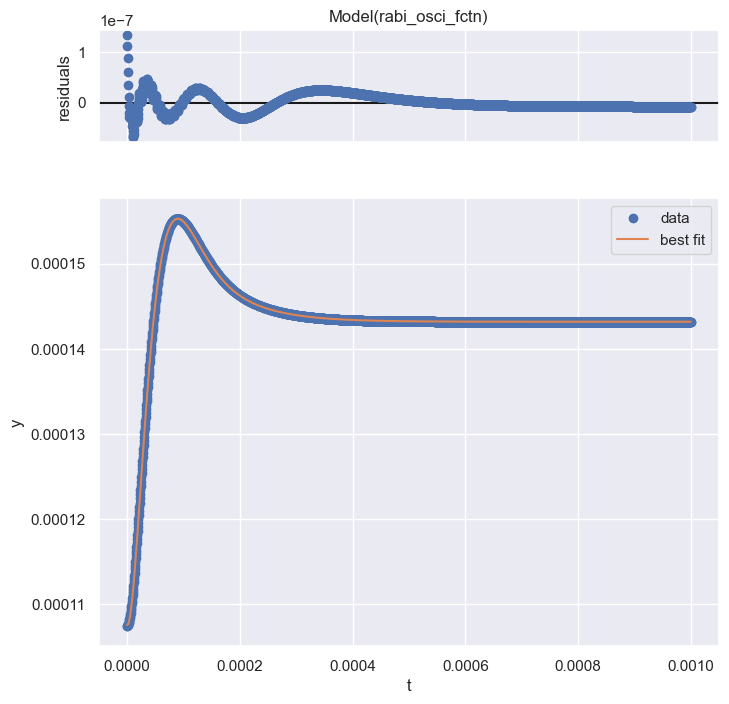

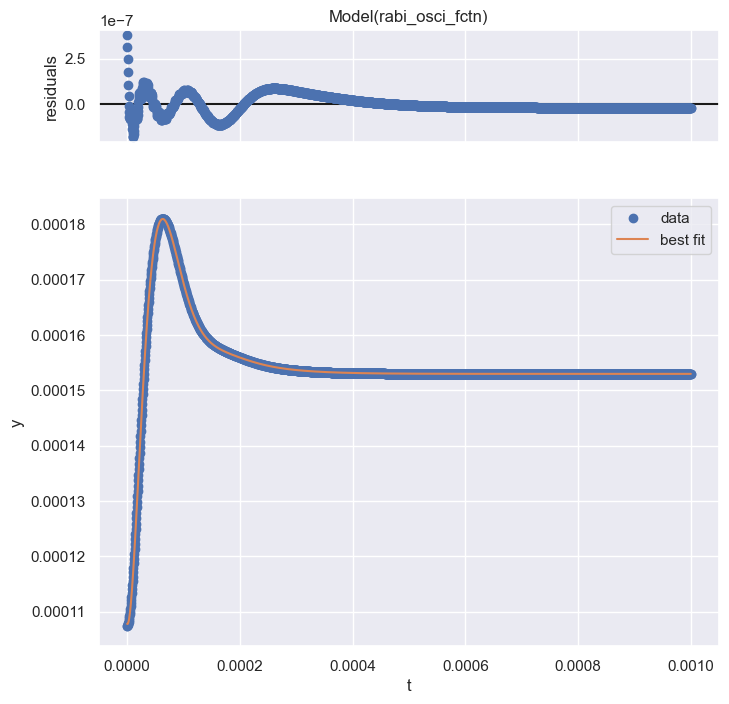

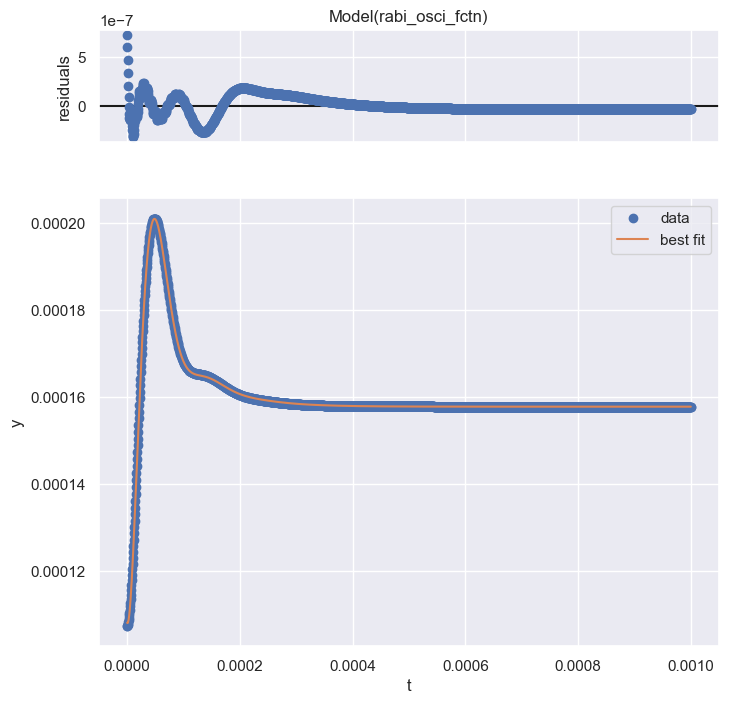

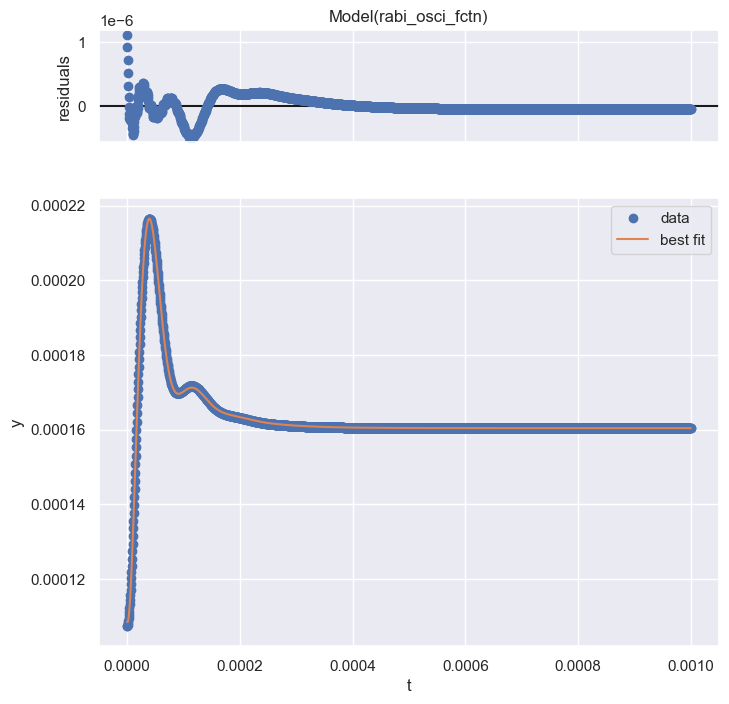

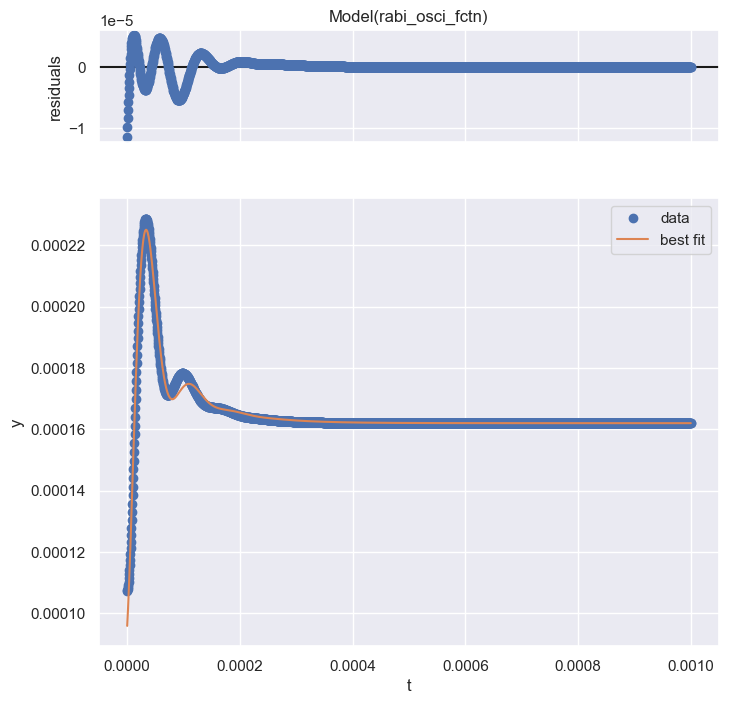

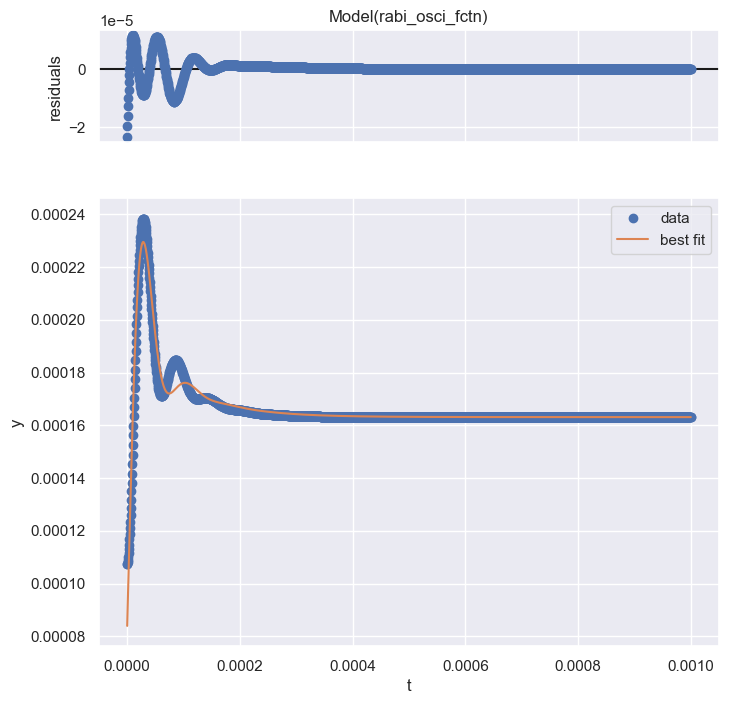

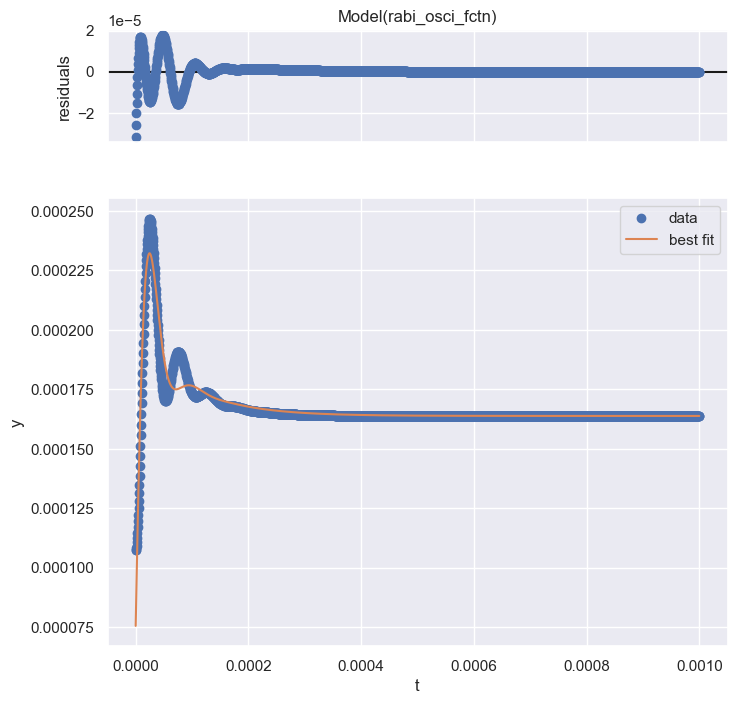

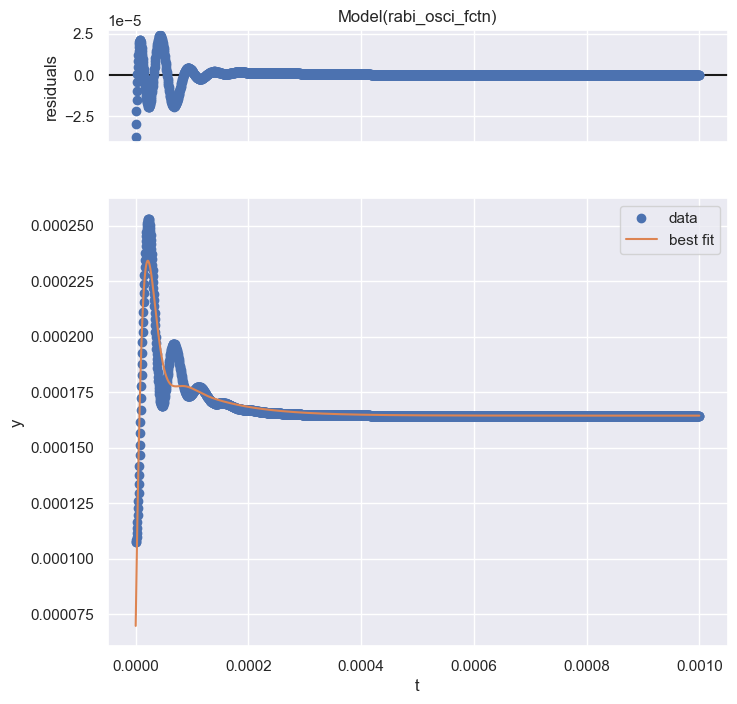

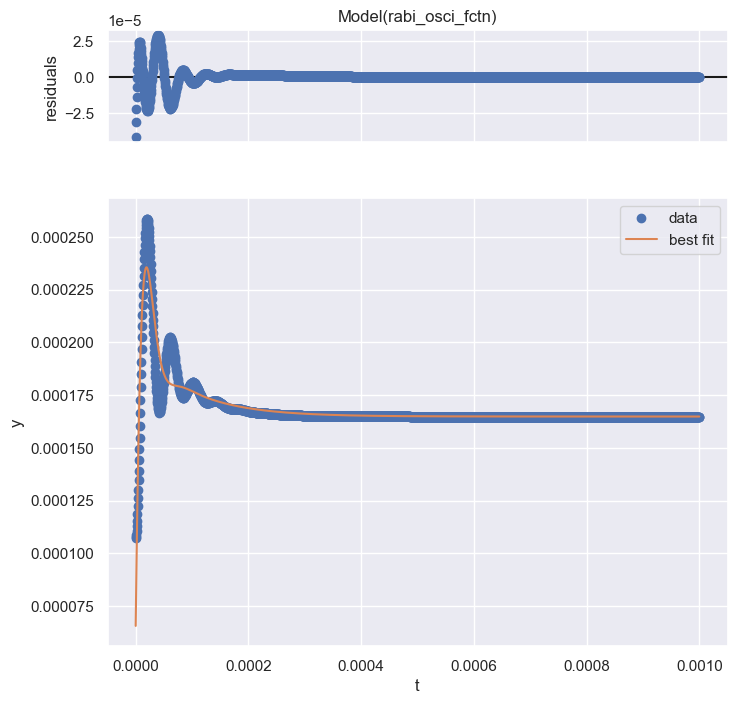

In [18]:
from lmfit.model import Model
def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(- gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
    )
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = s.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)

    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="differential_evolution",
    )
    newfit.append(resfit)
    resfit.plot()

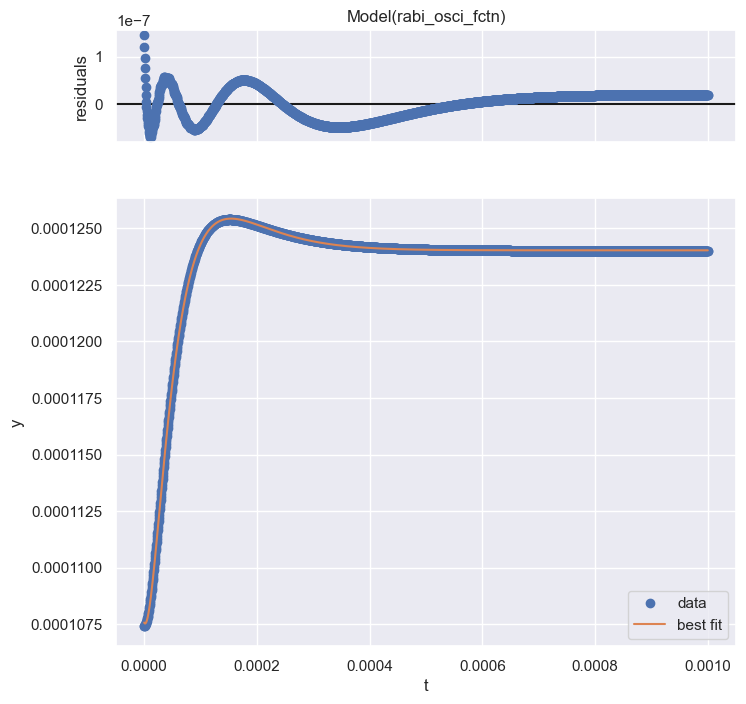

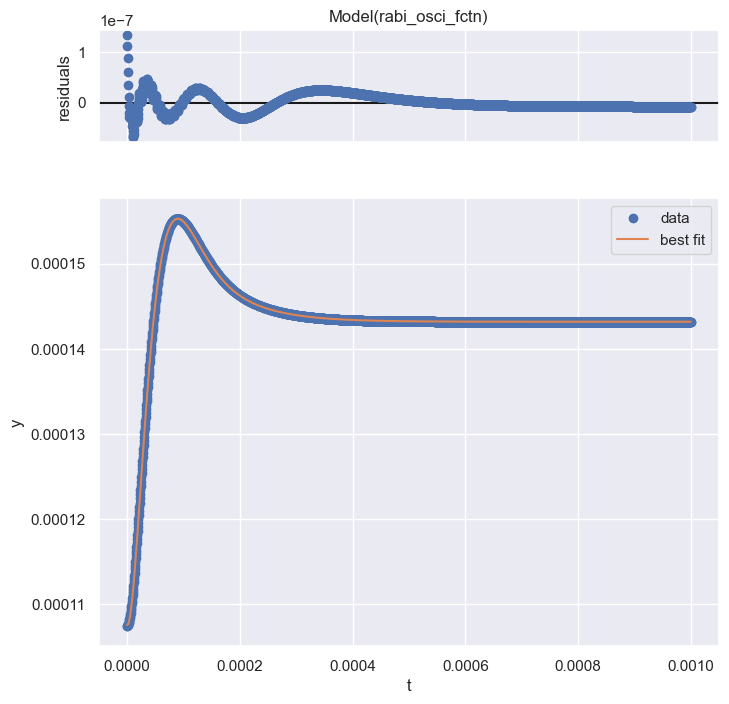

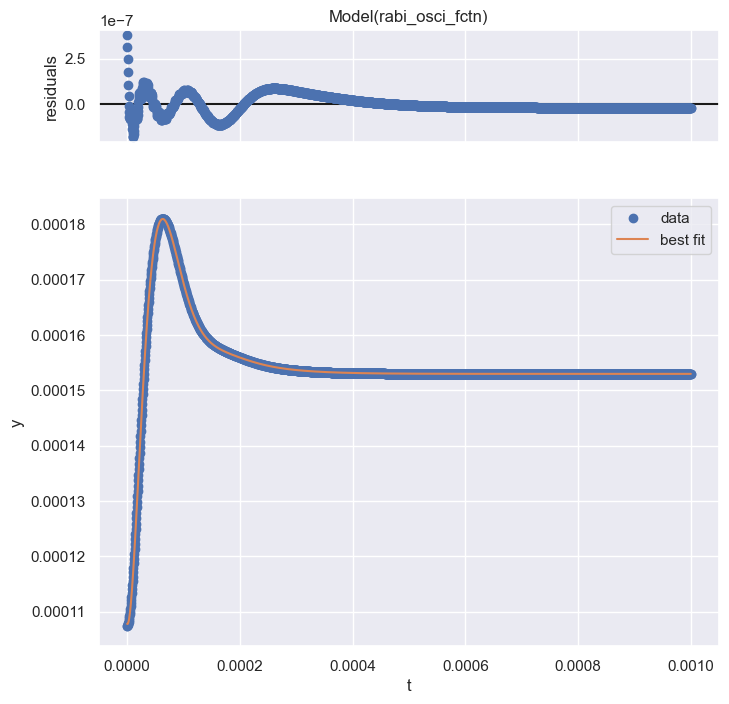

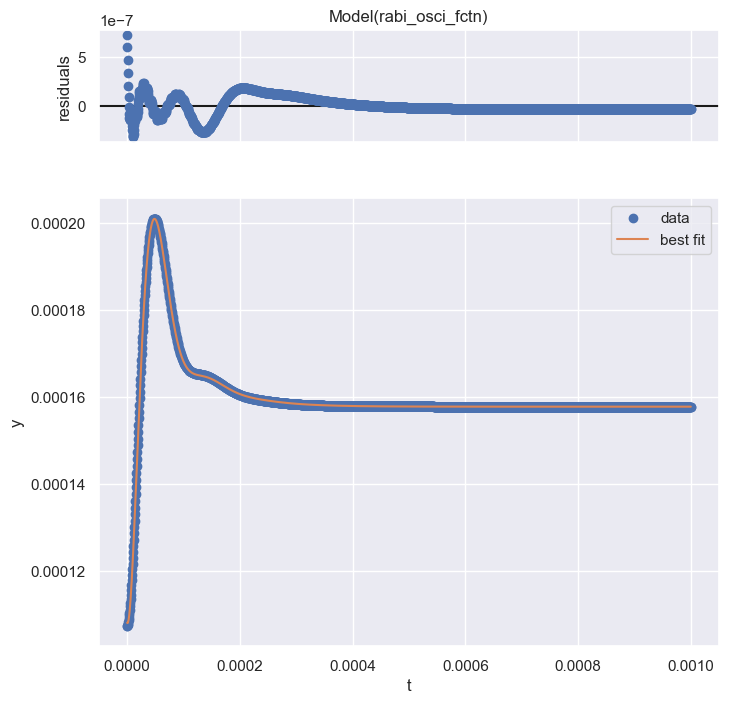

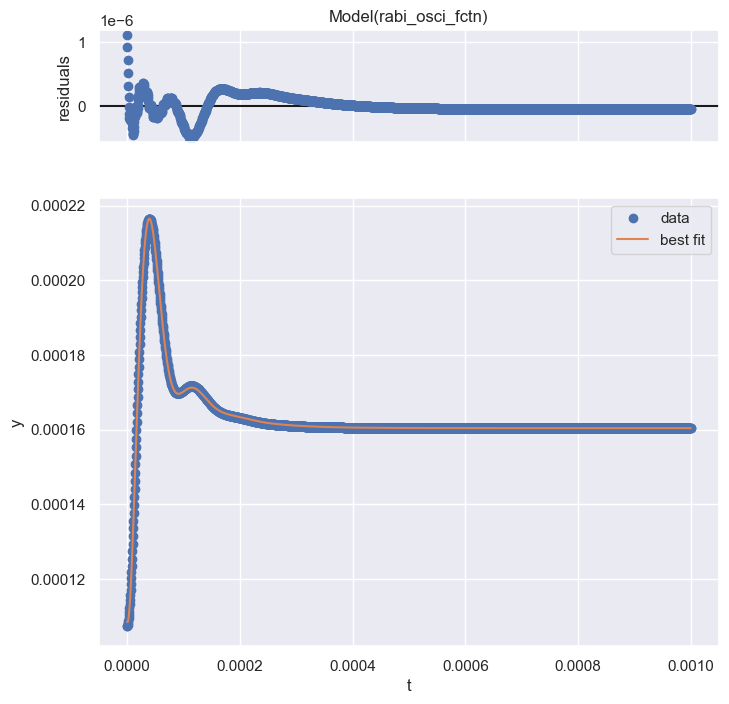

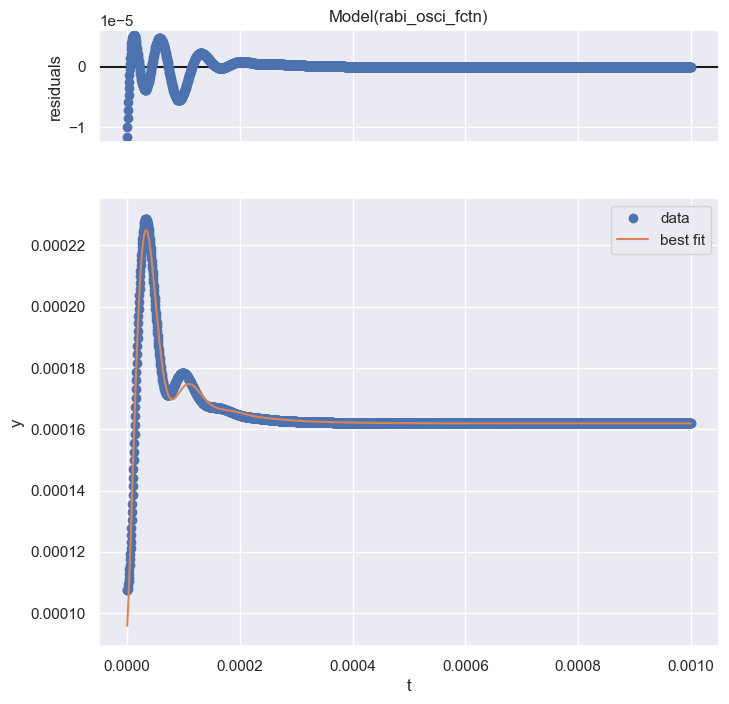

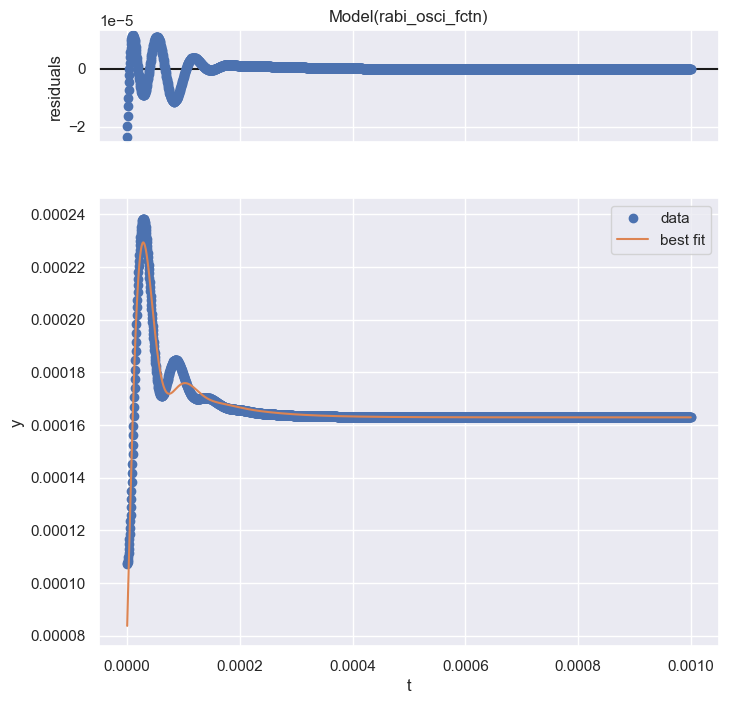

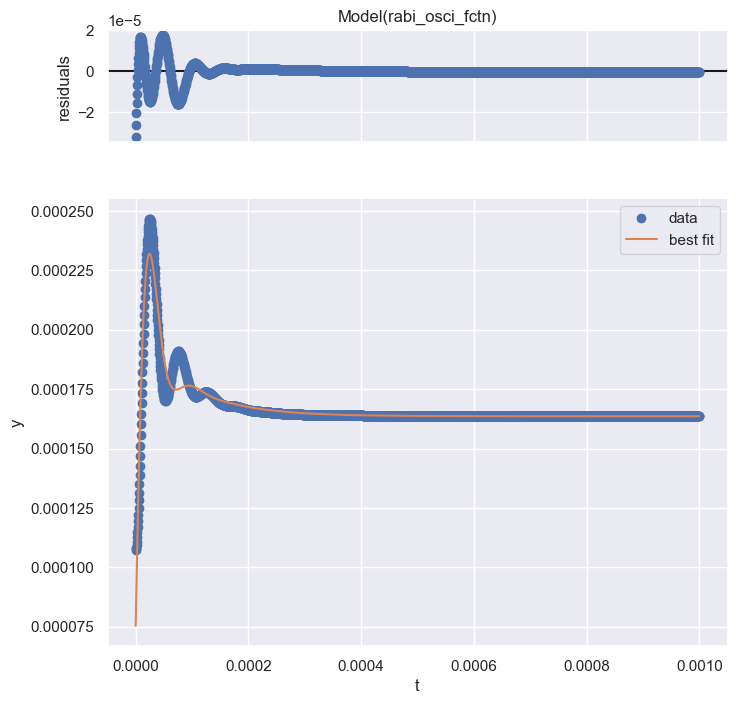

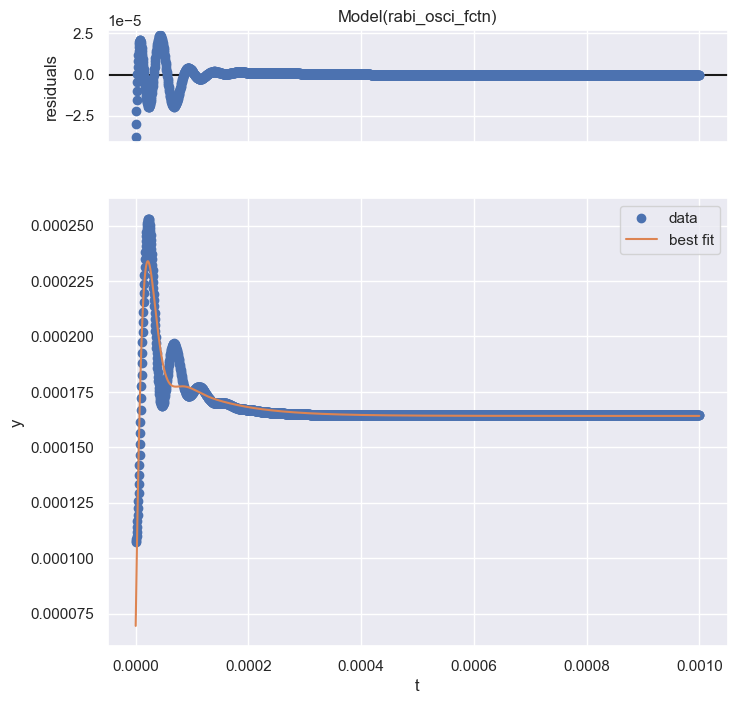

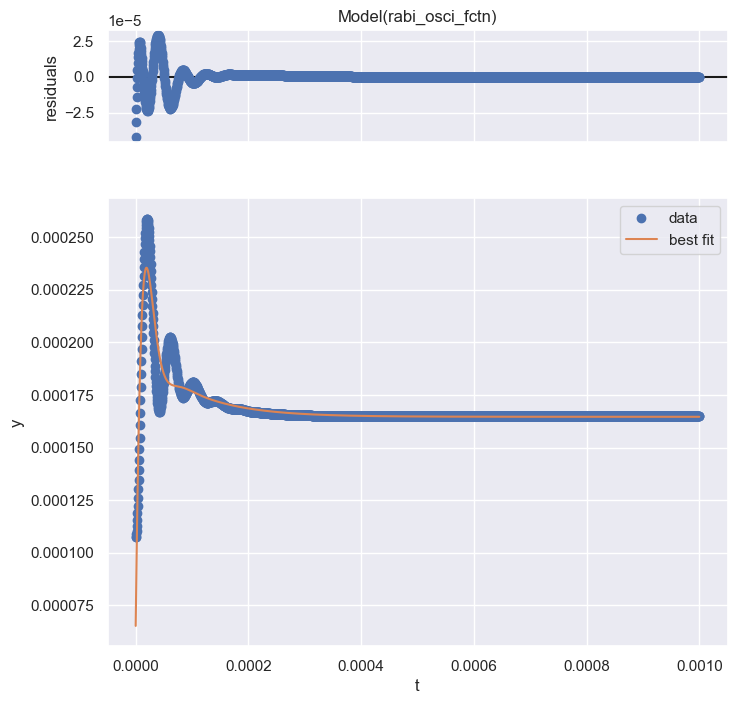

In [19]:
from lmfit.model import Model
def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(- gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
    )
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = s.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)

    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        method="nelder",
    )
    newfit.append(resfit)
    resfit.plot()

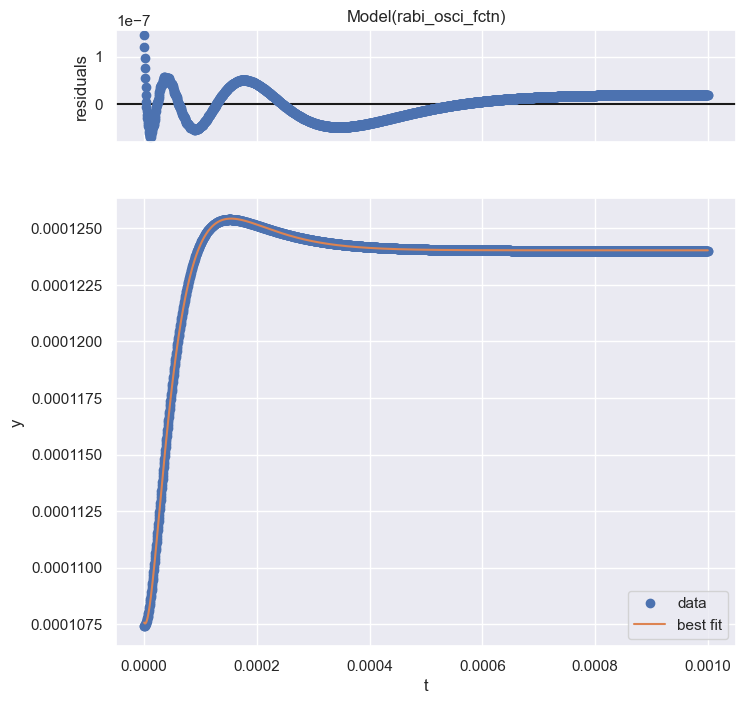

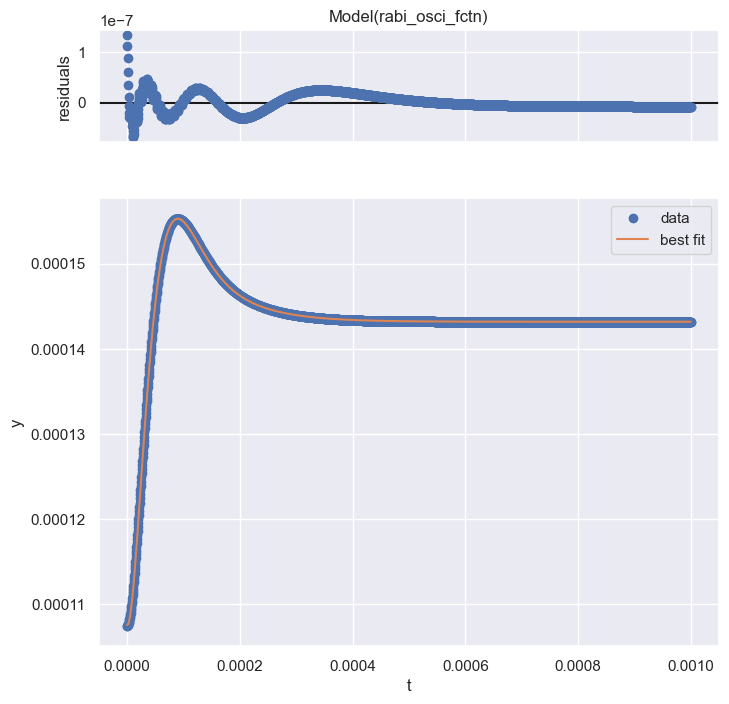

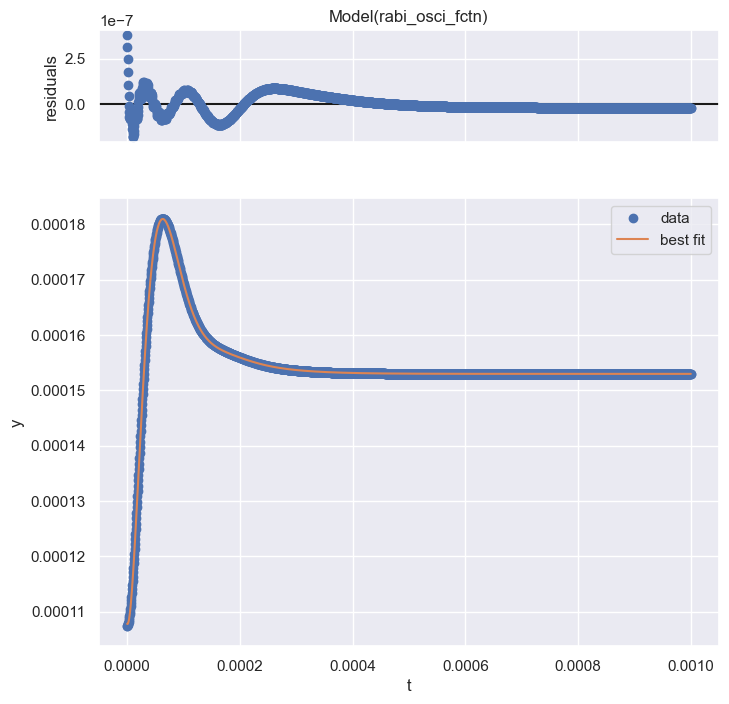

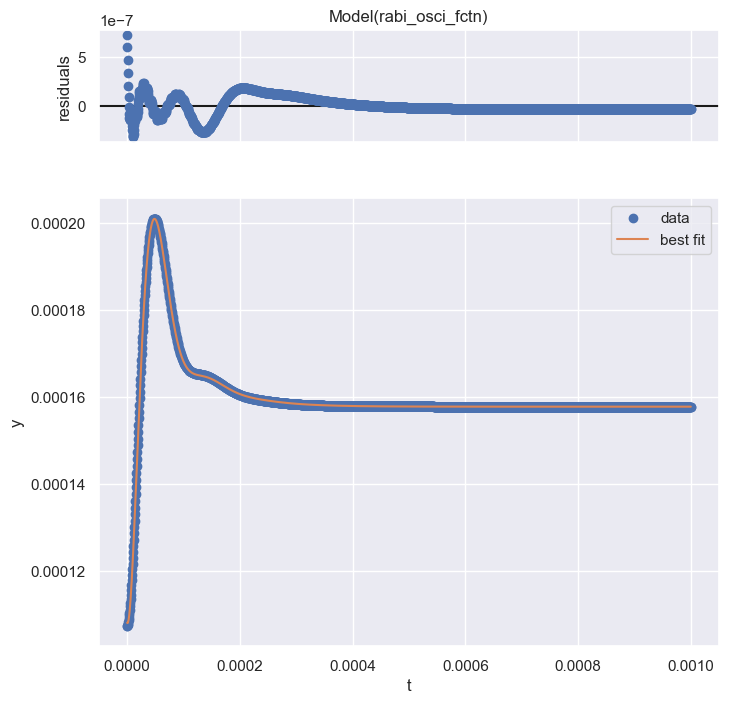

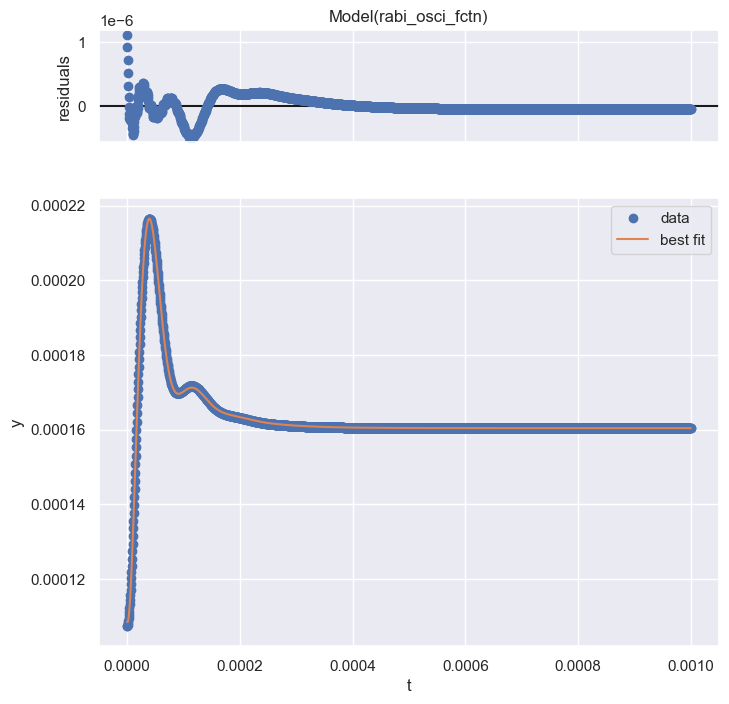

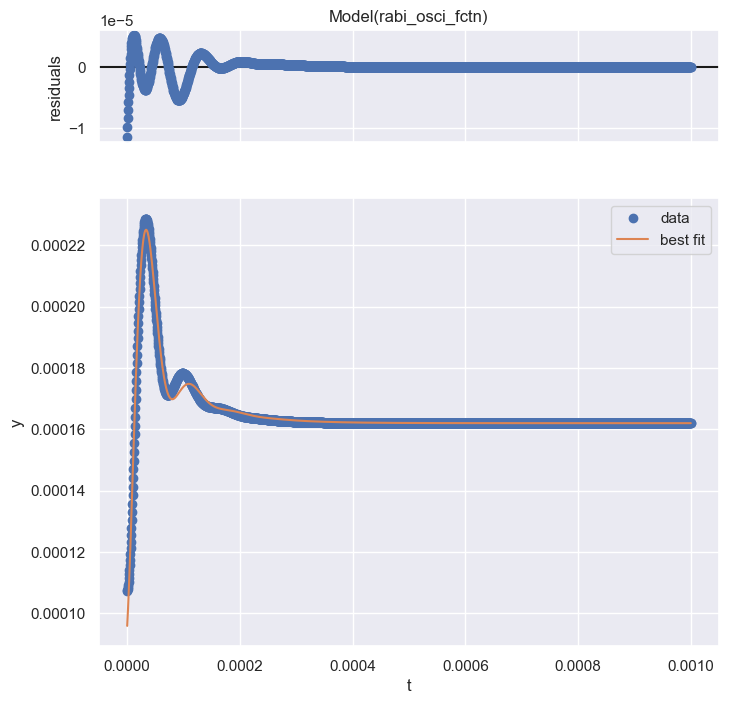

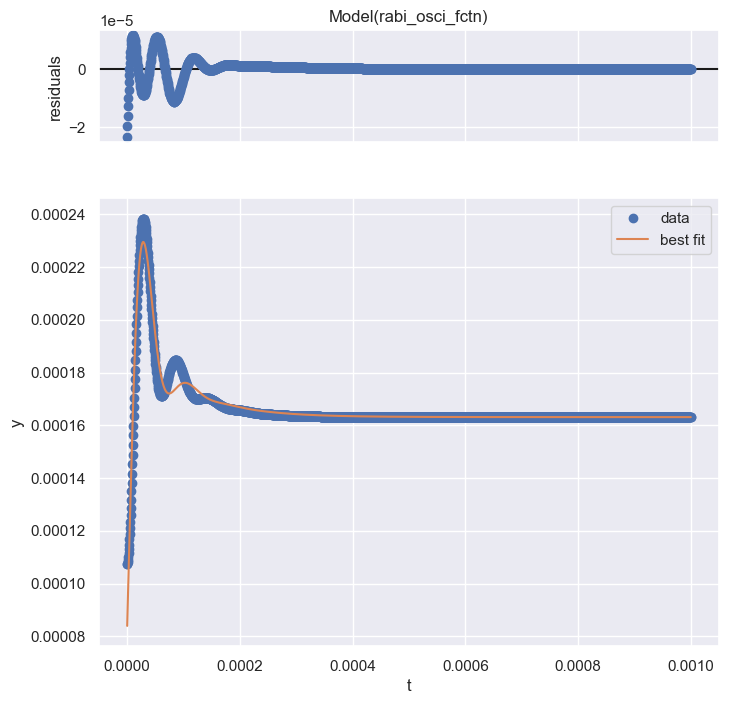

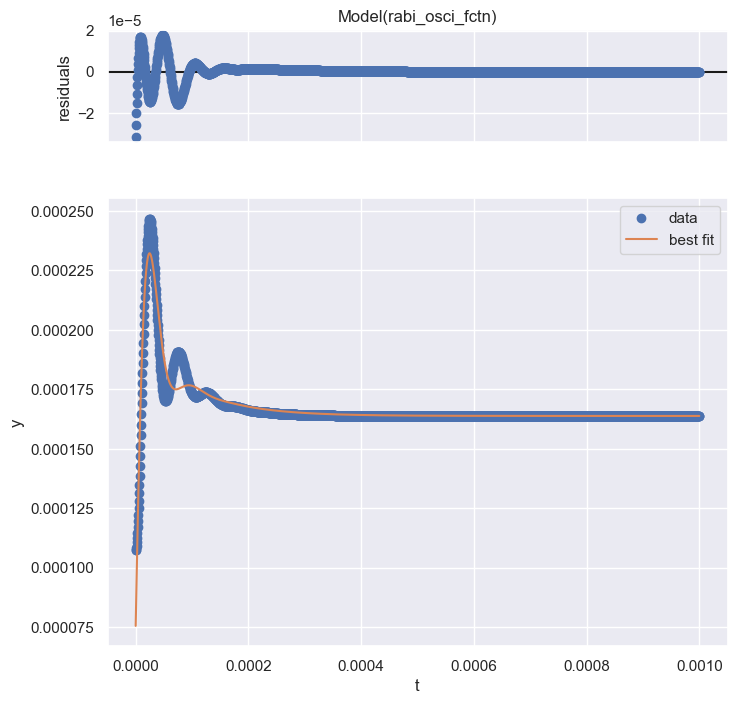

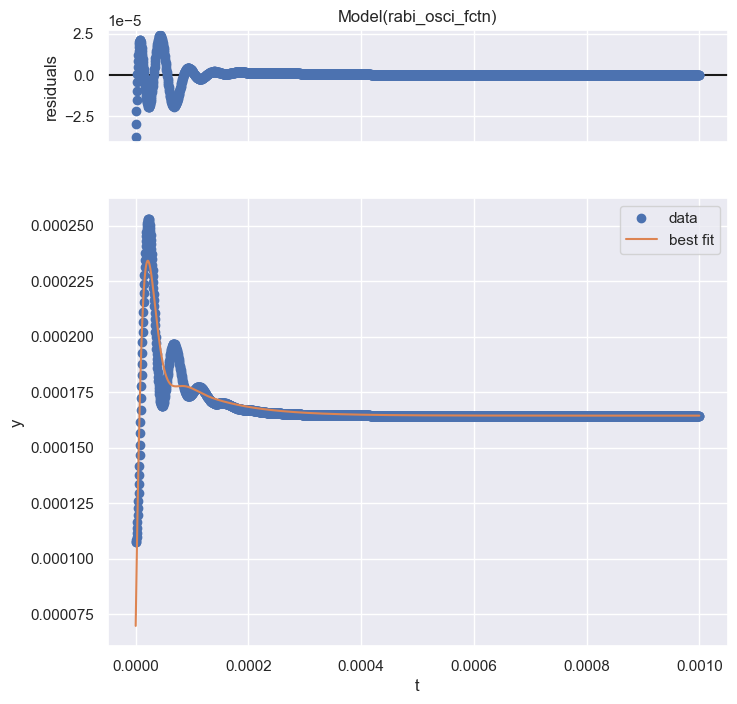

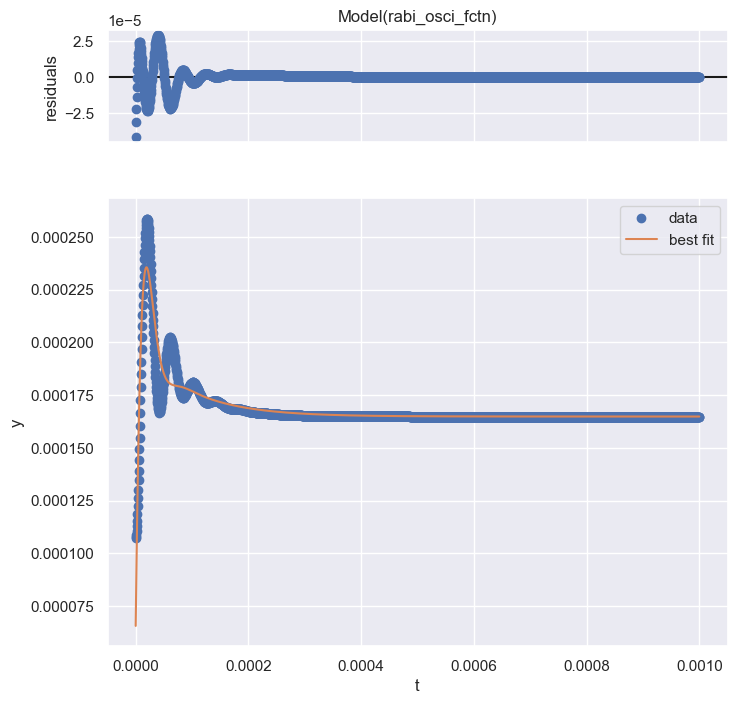

In [20]:
from lmfit.model import Model
def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(- gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
    )
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = s.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)

    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="nelder",
    )
    newfit.append(resfit)
    resfit.plot()

In [21]:
newfit[0]

In [22]:
newfit[1]

ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

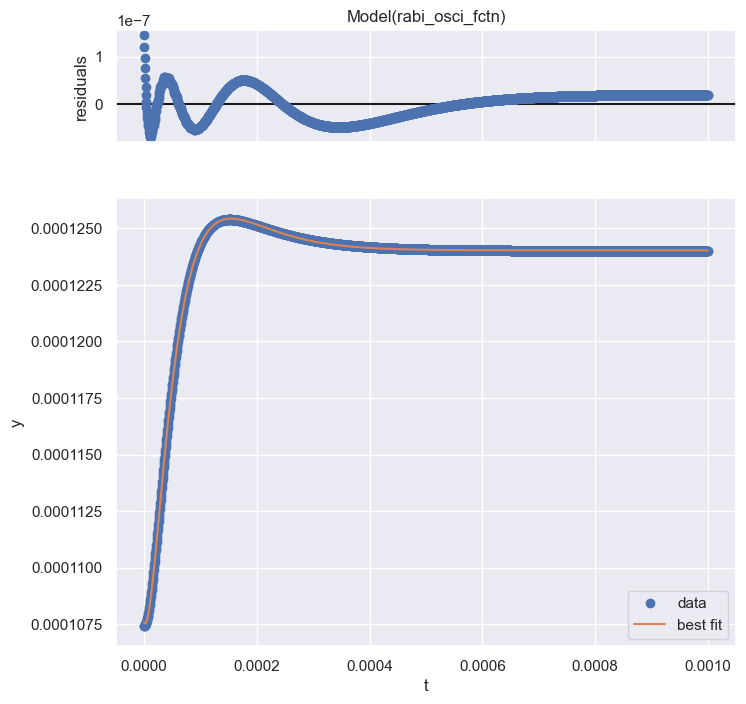

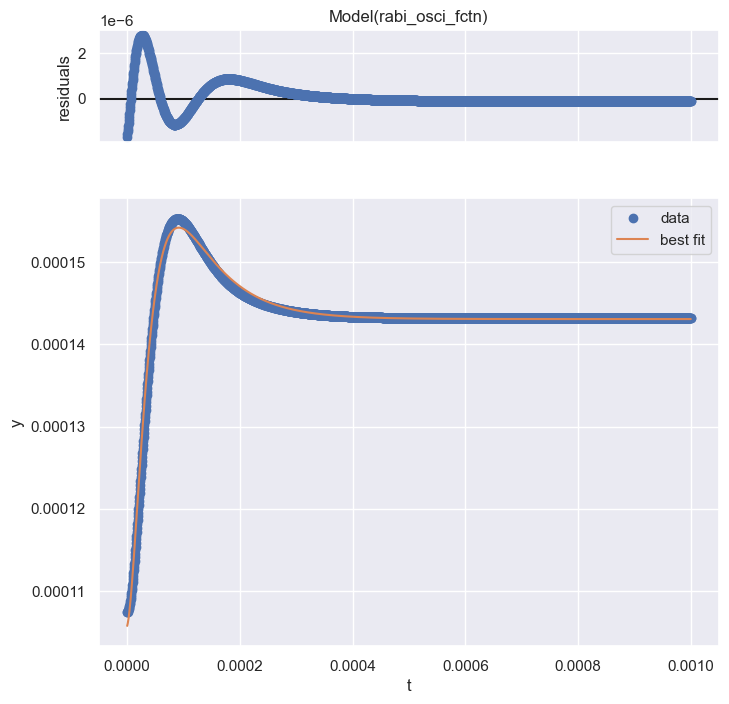

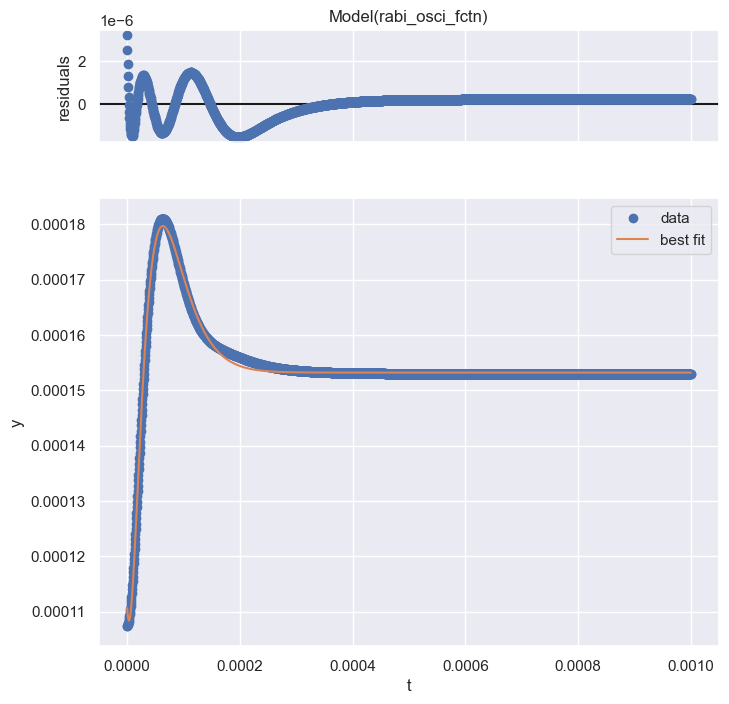

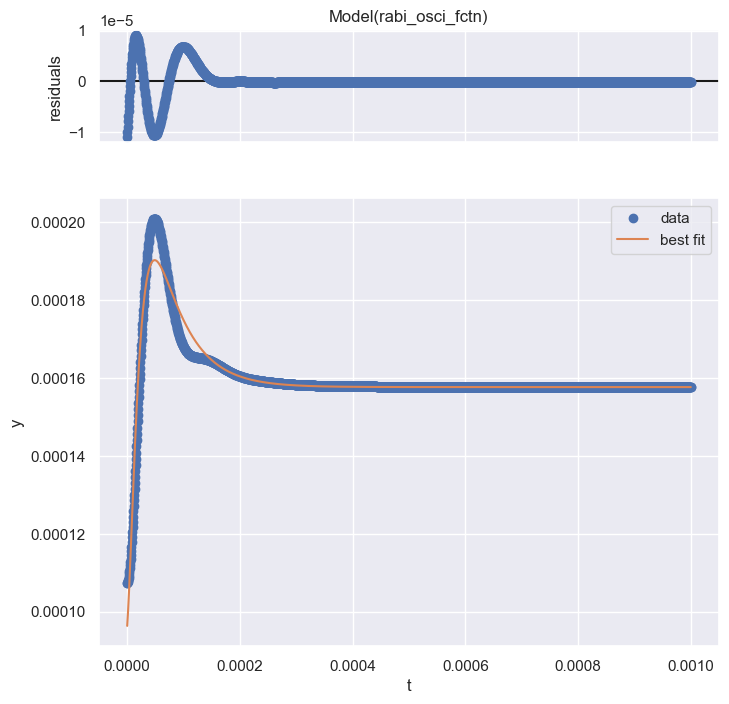

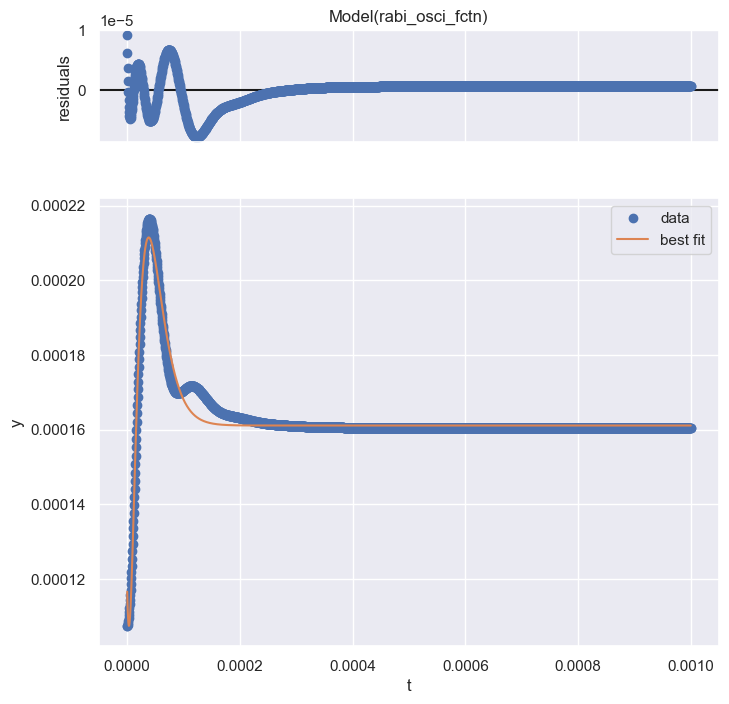

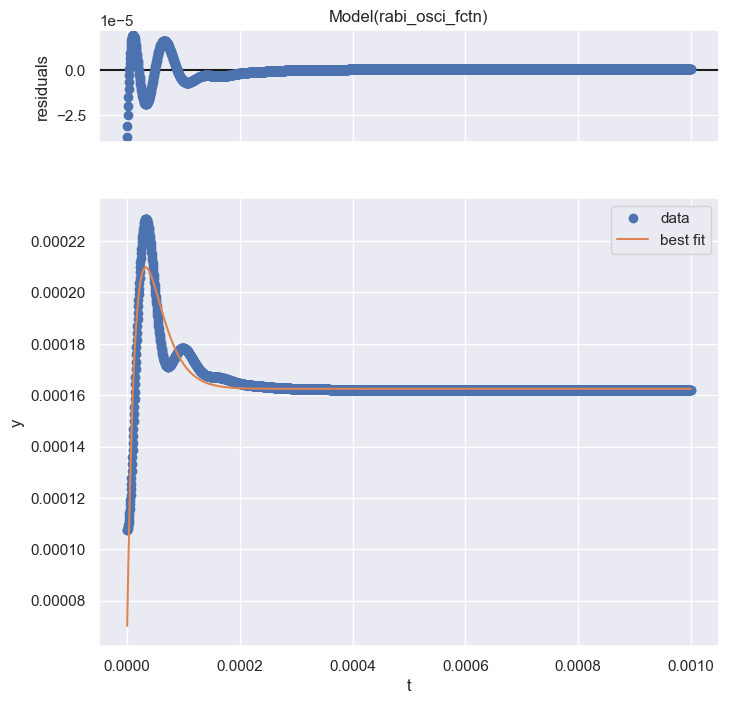

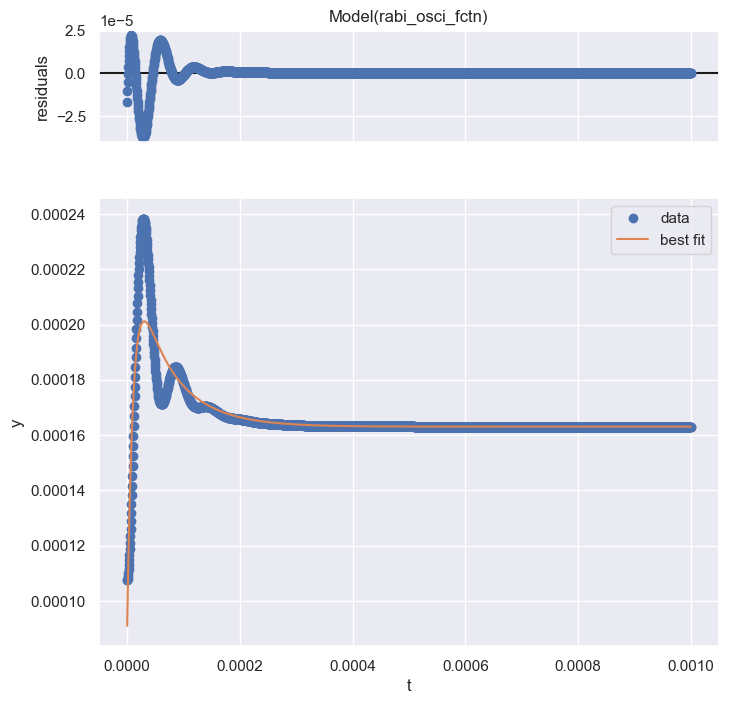

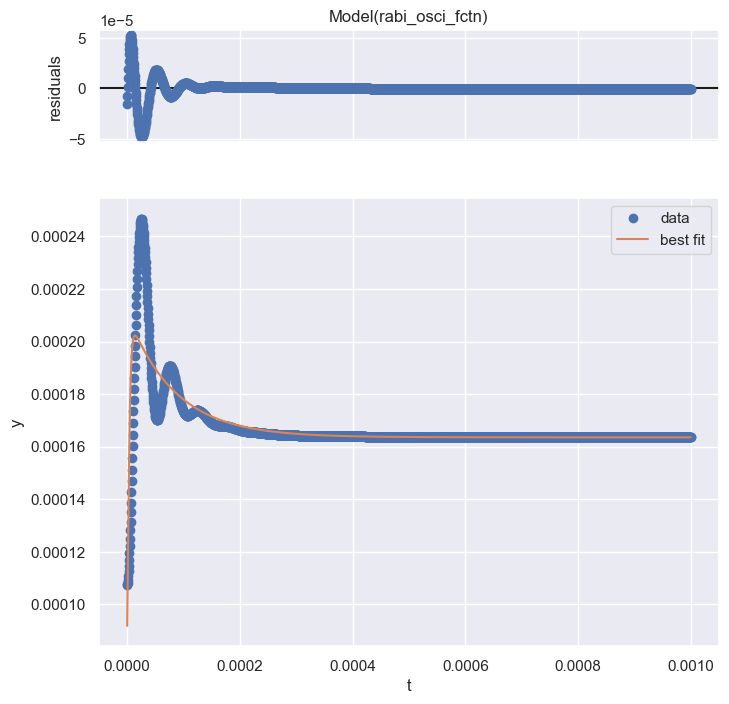

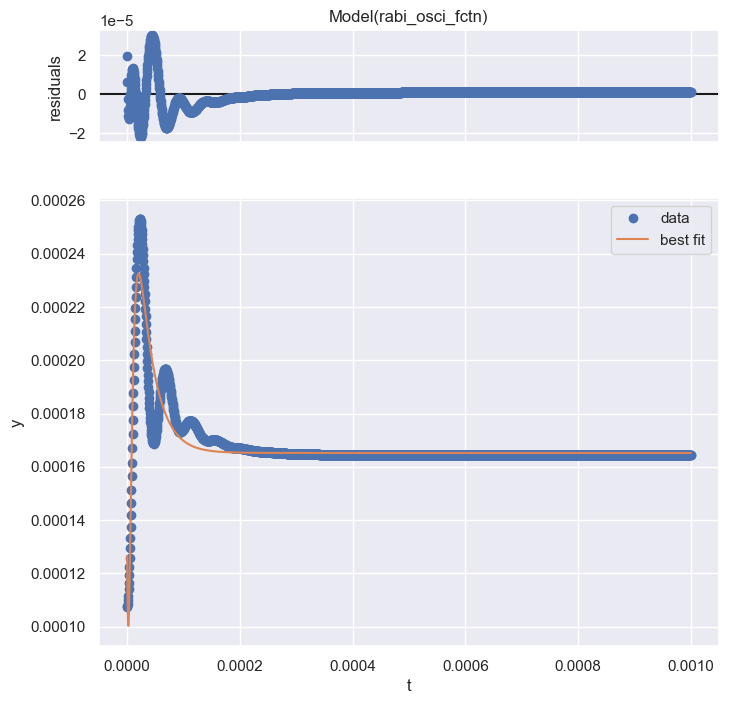

In [23]:
from lmfit.model import Model
def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(- gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
    )
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = s.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    pars["rabi"].set(min=3e3, max=77)
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)

    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="nelder",
    )
    newfit.append(resfit)
    resfit.plot()

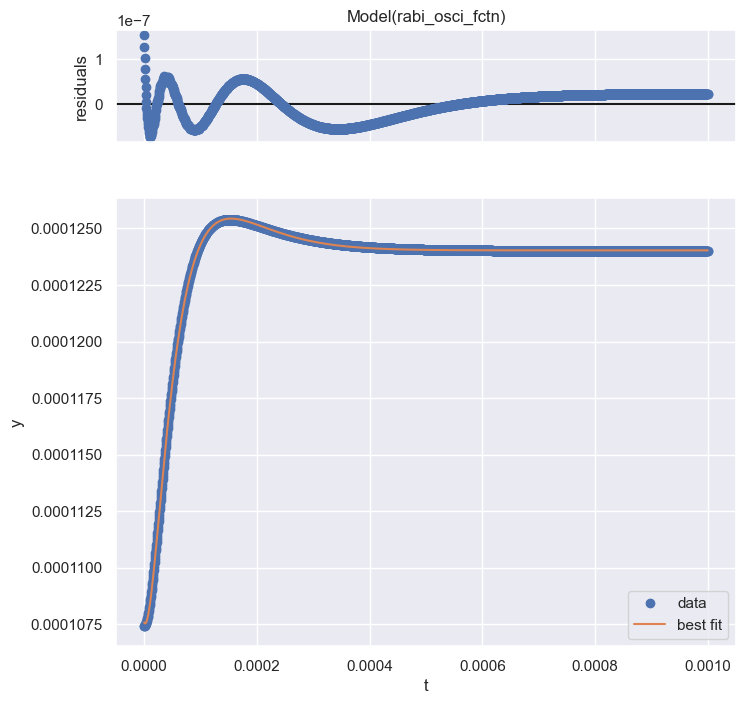

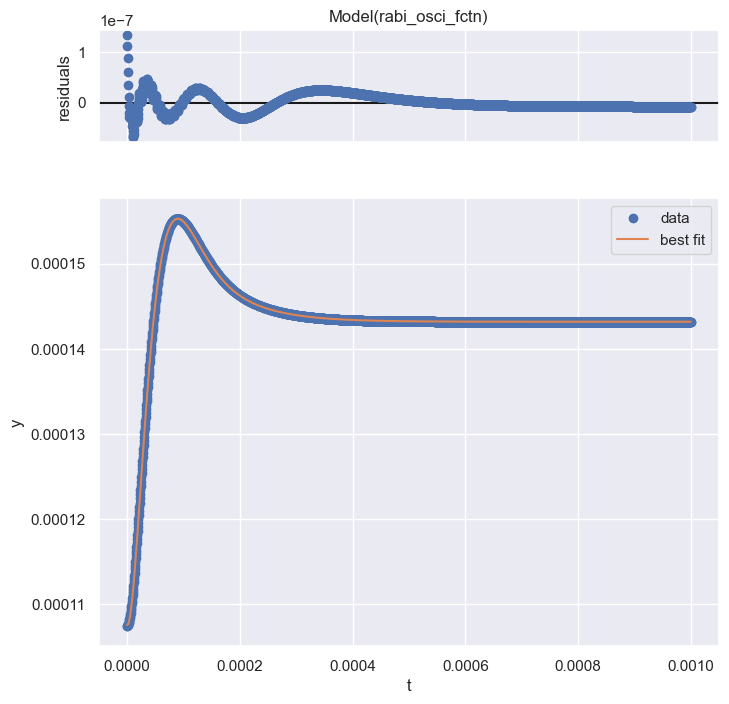

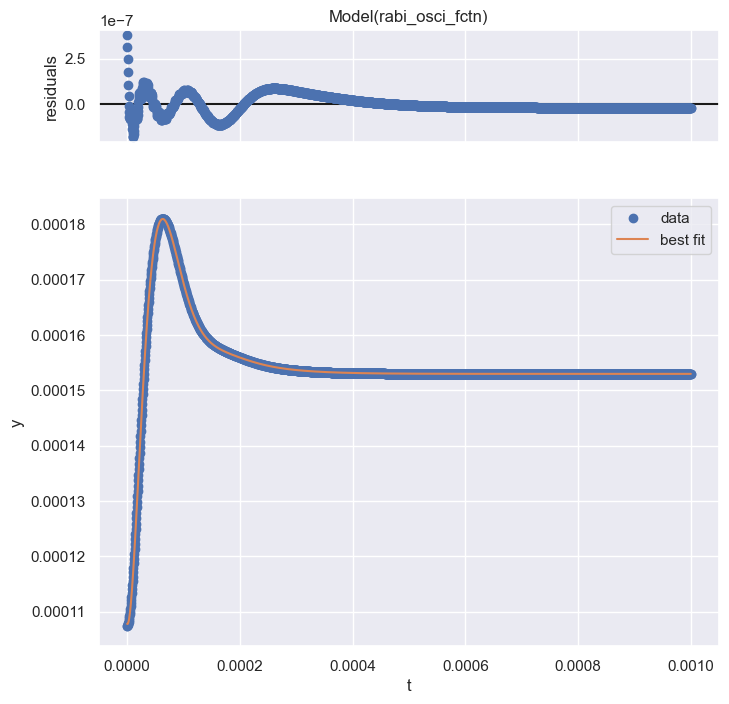

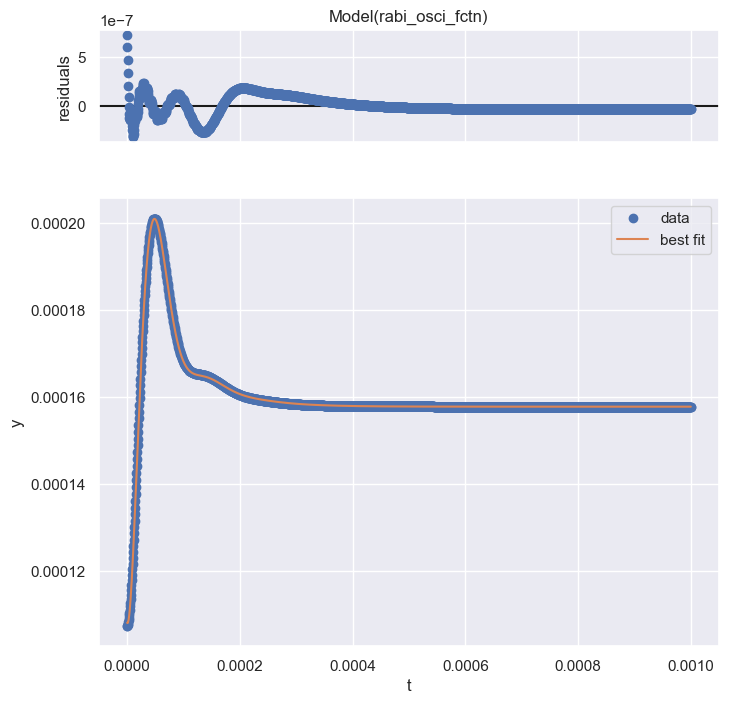

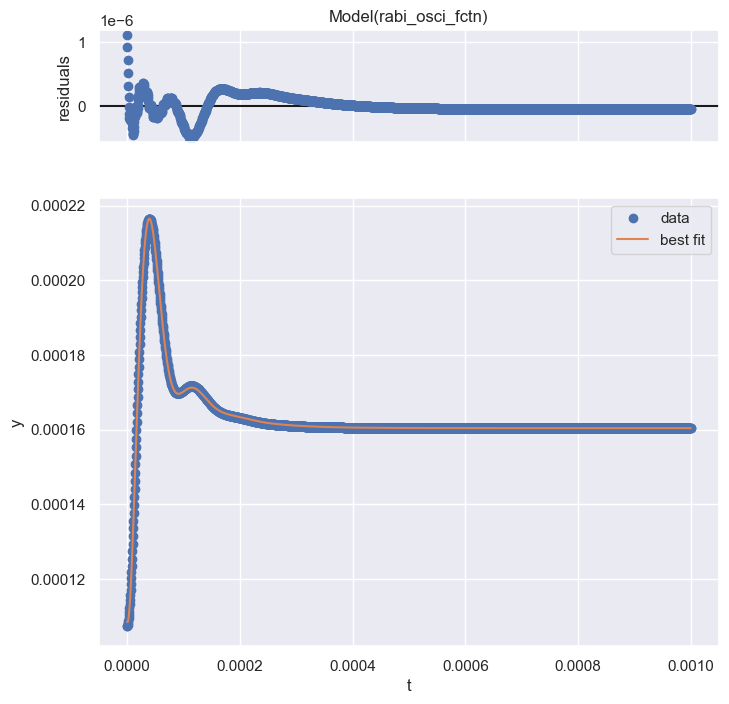

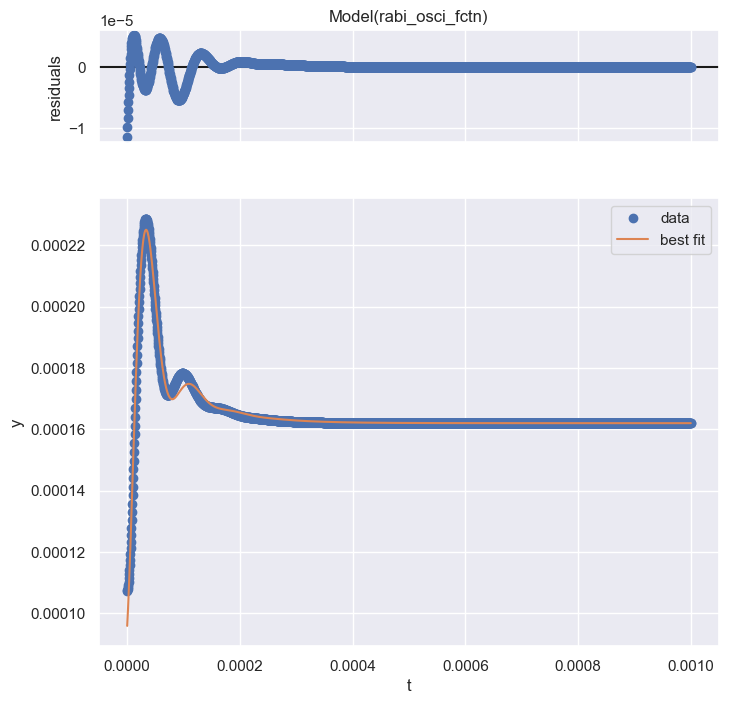

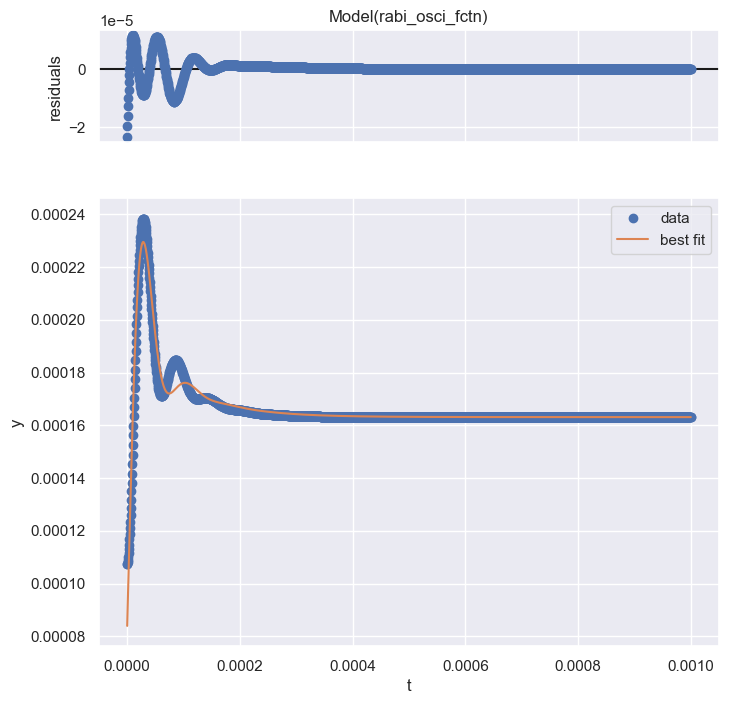

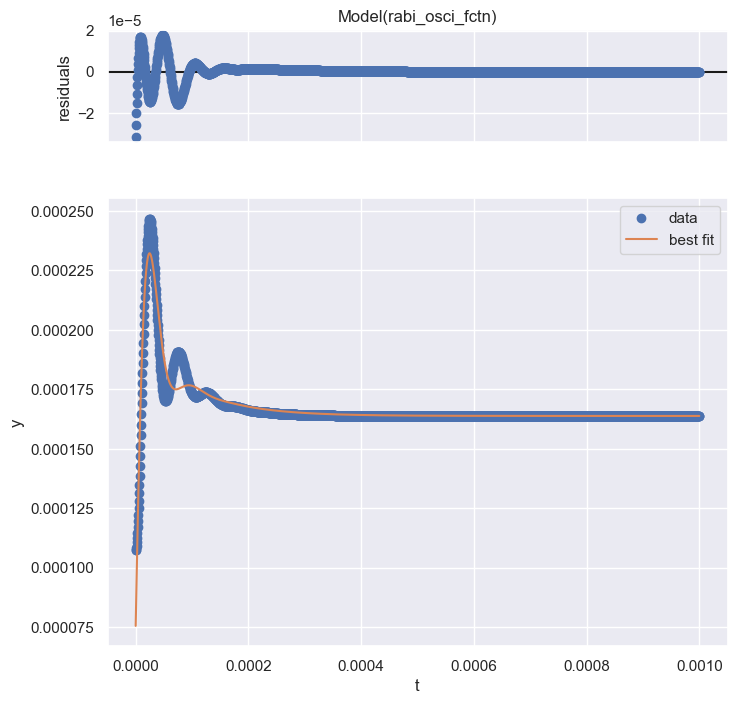

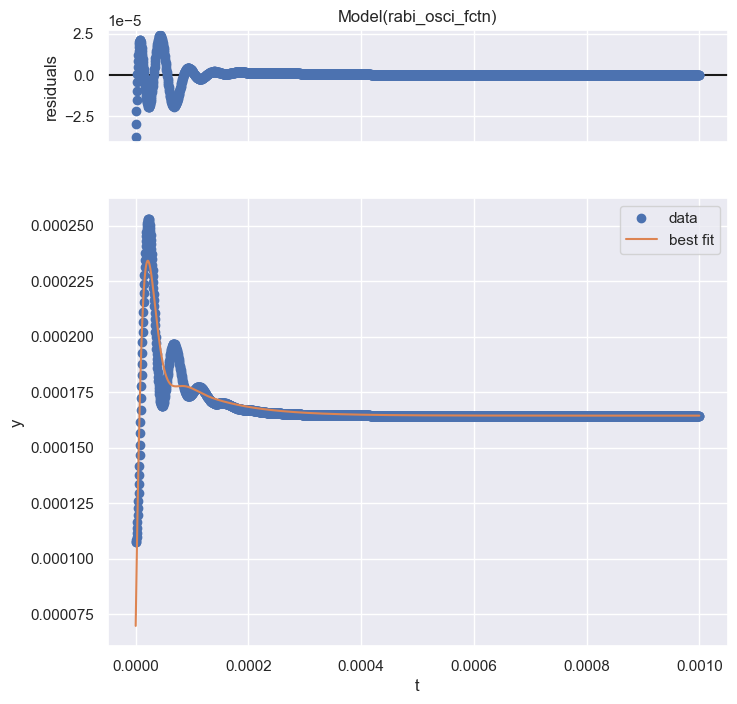

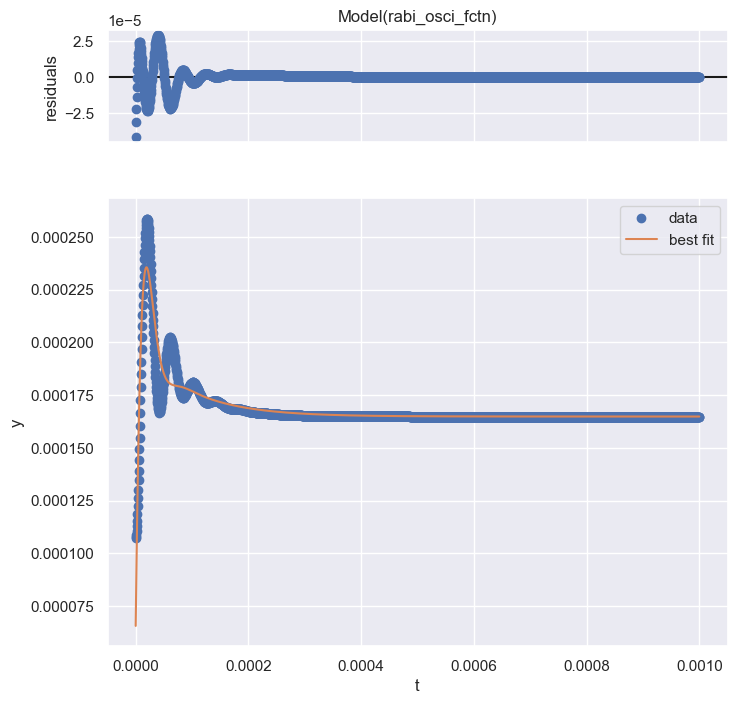

In [24]:
from lmfit.model import Model
def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(- gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
    )
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = s.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    pars["rabi"].set(min=3e3, max=77e3)
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)

    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="nelder",
    )
    newfit.append(resfit)
    resfit.plot()

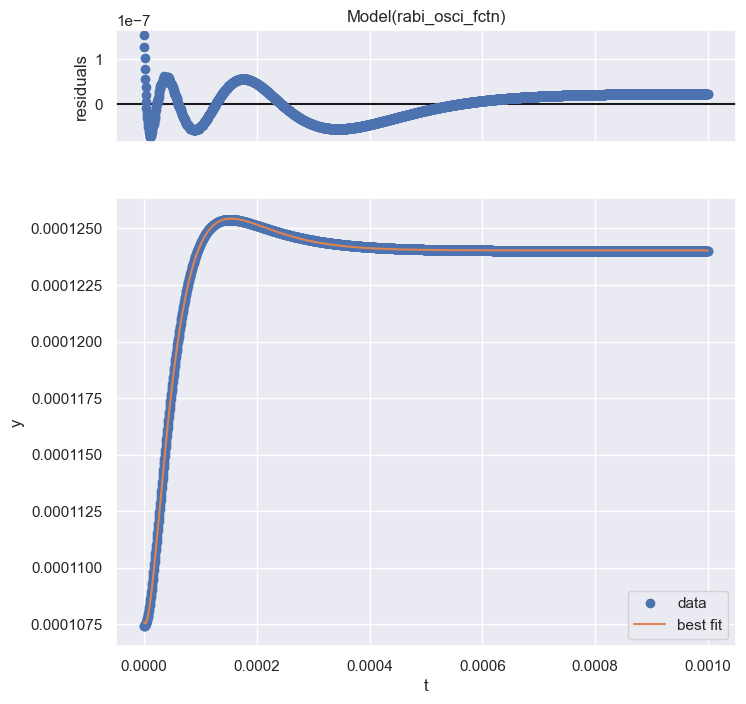

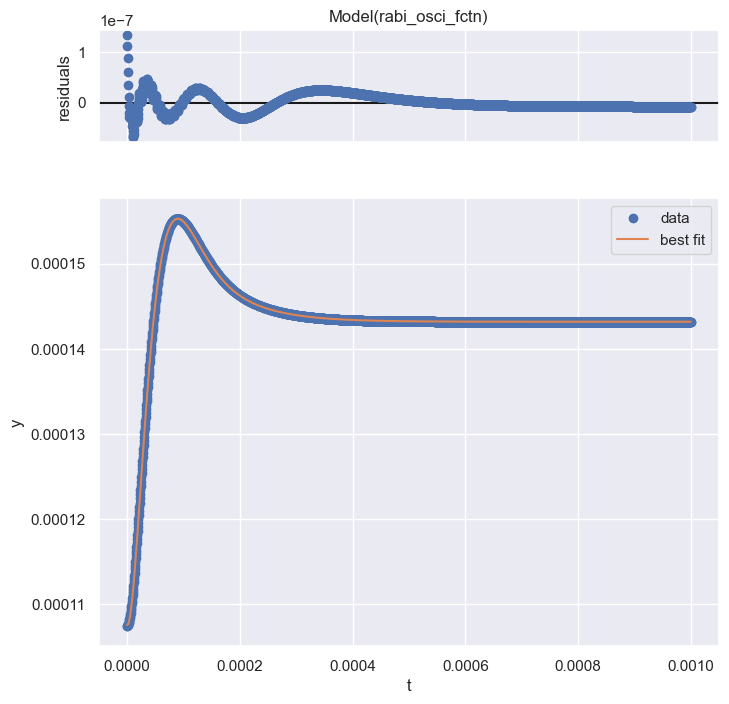

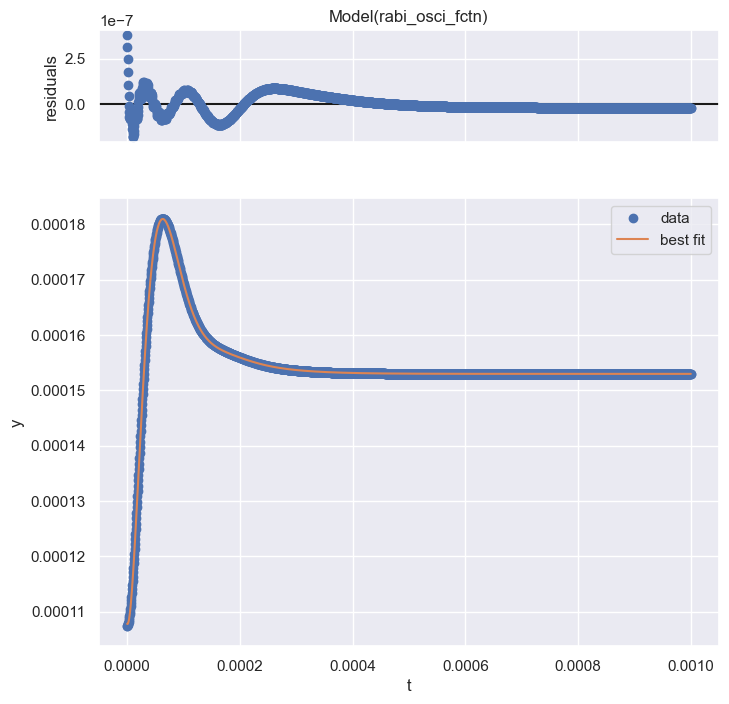

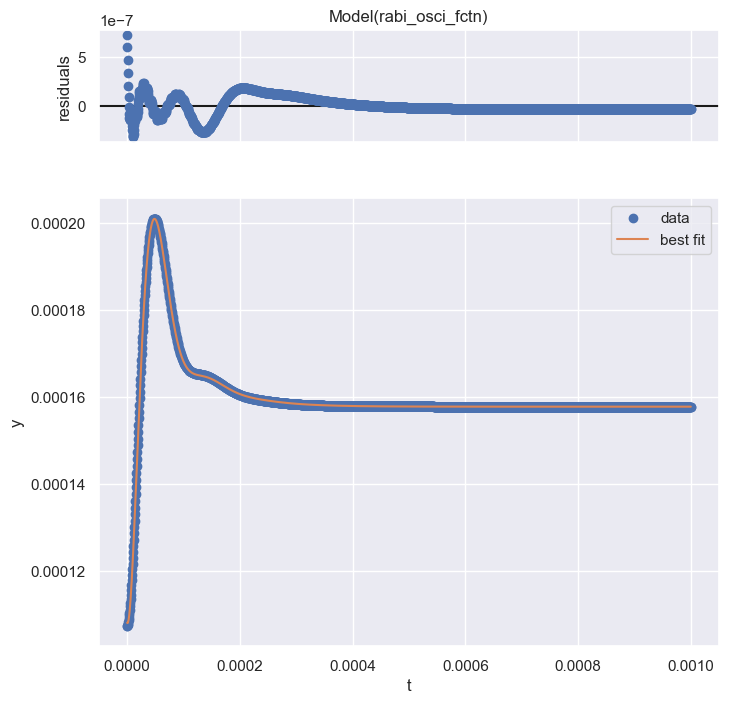

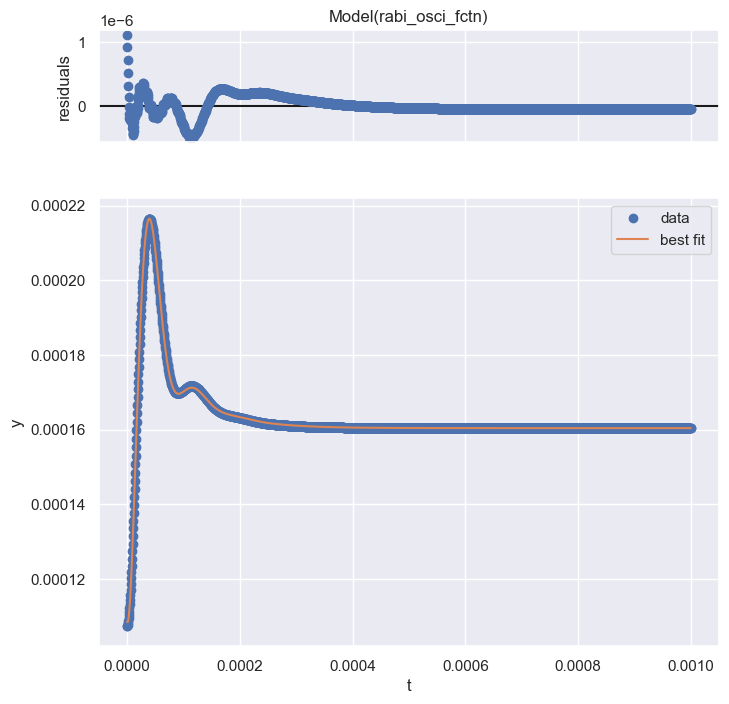

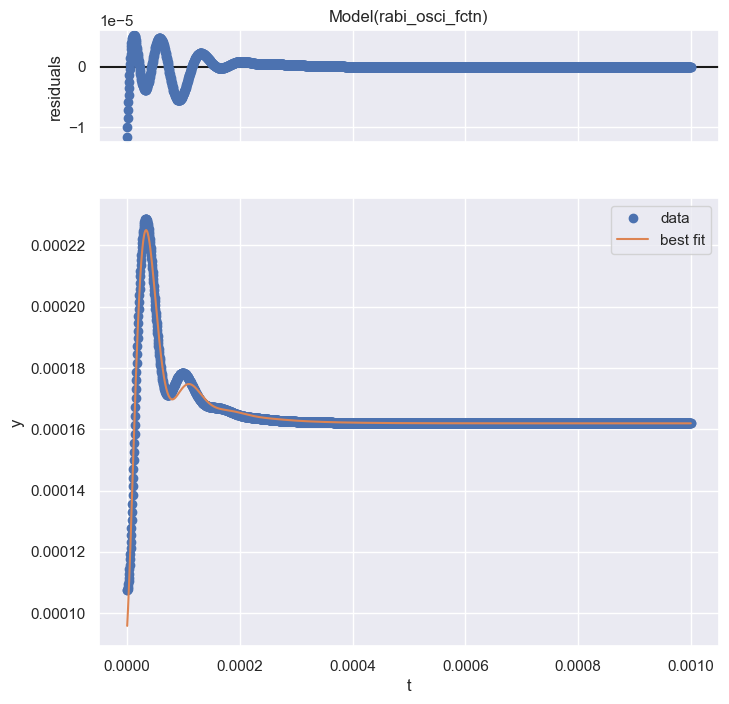

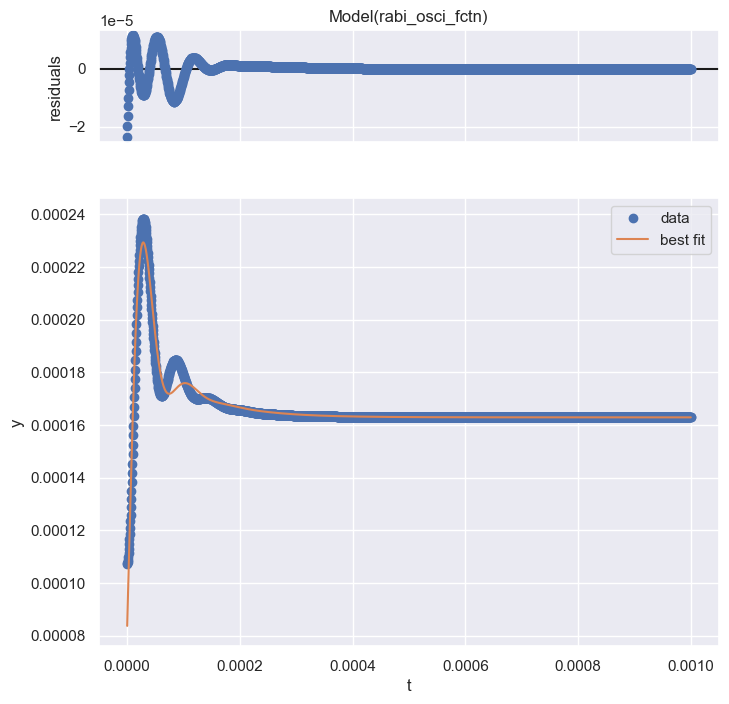

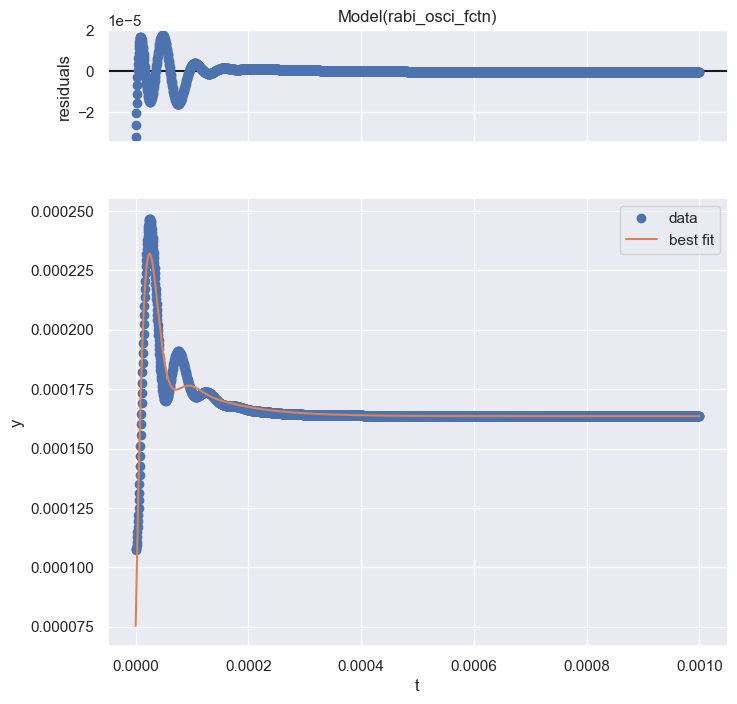

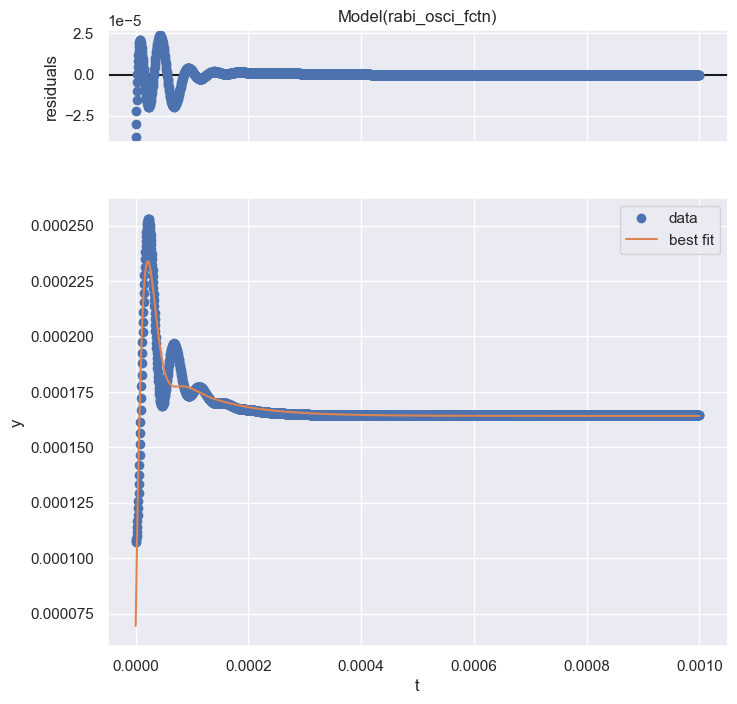

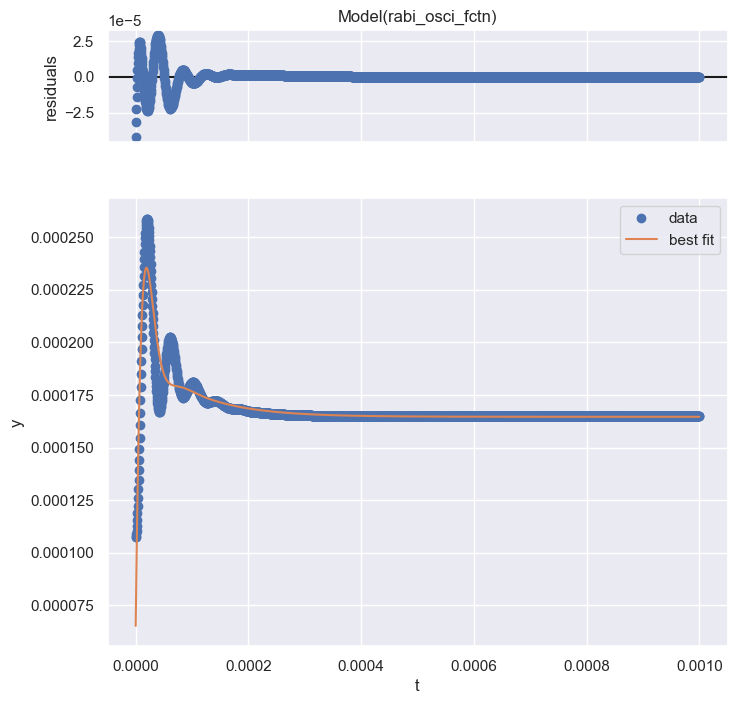

In [25]:
from lmfit.model import Model
def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(- gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
    )
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = s.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    pars["rabi"].set(min=3e3, max=77e3, value=50e3)
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)

    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="nelder",
    )
    newfit.append(resfit)
    resfit.plot()

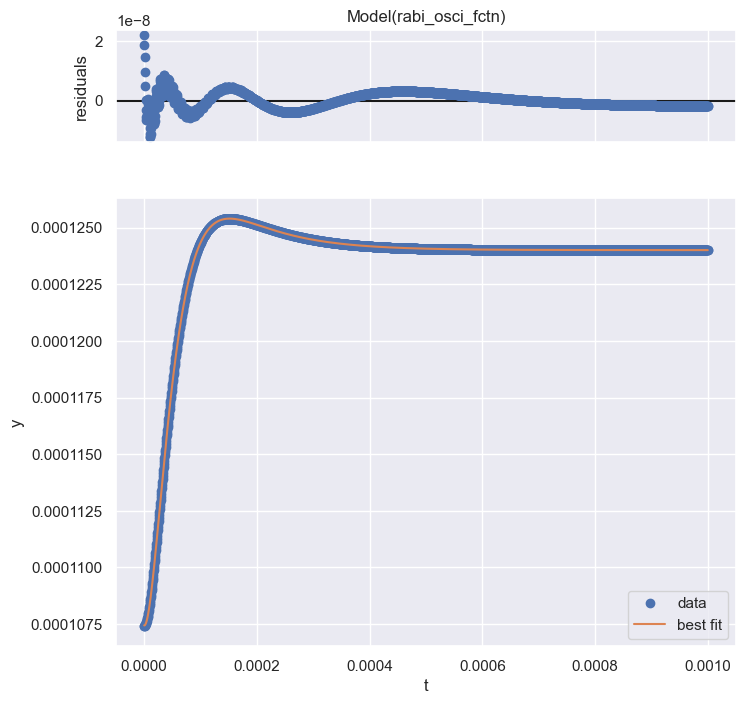

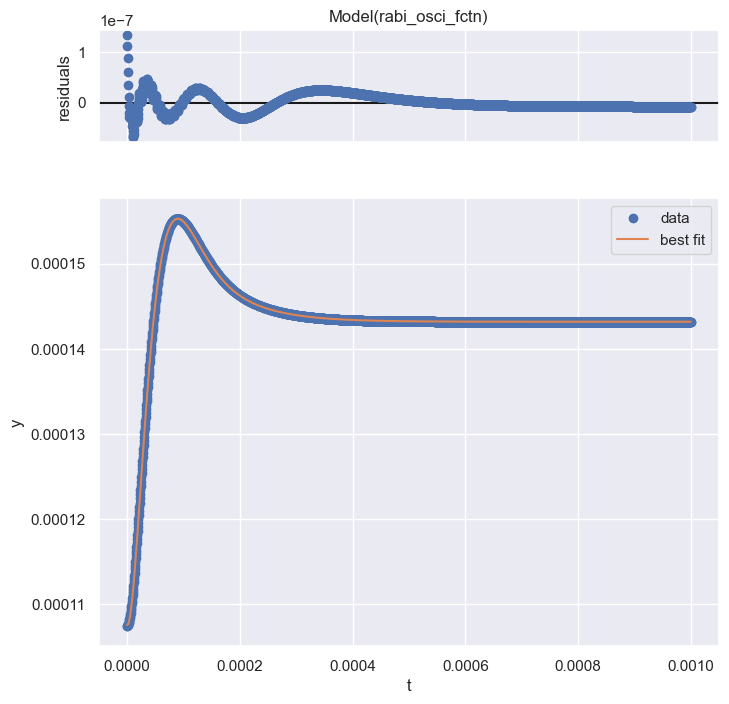

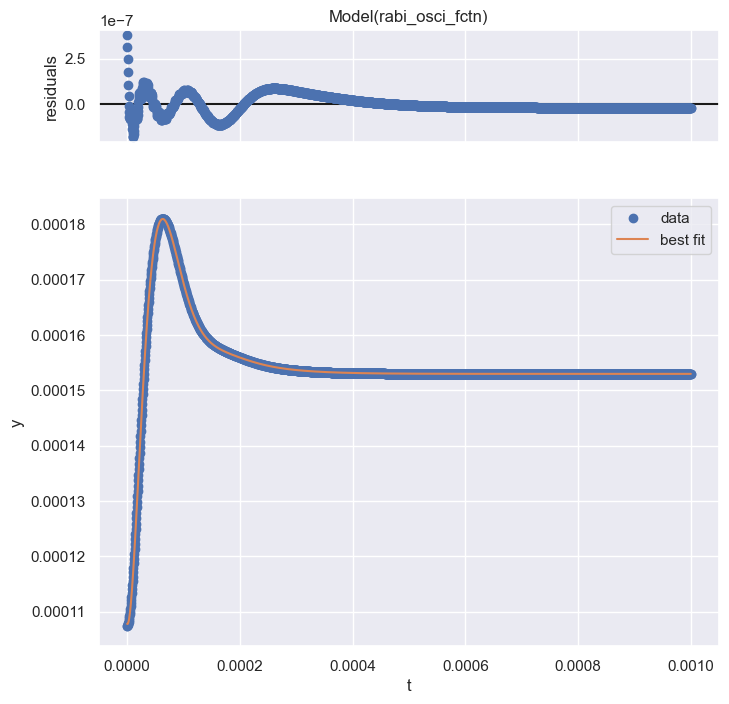

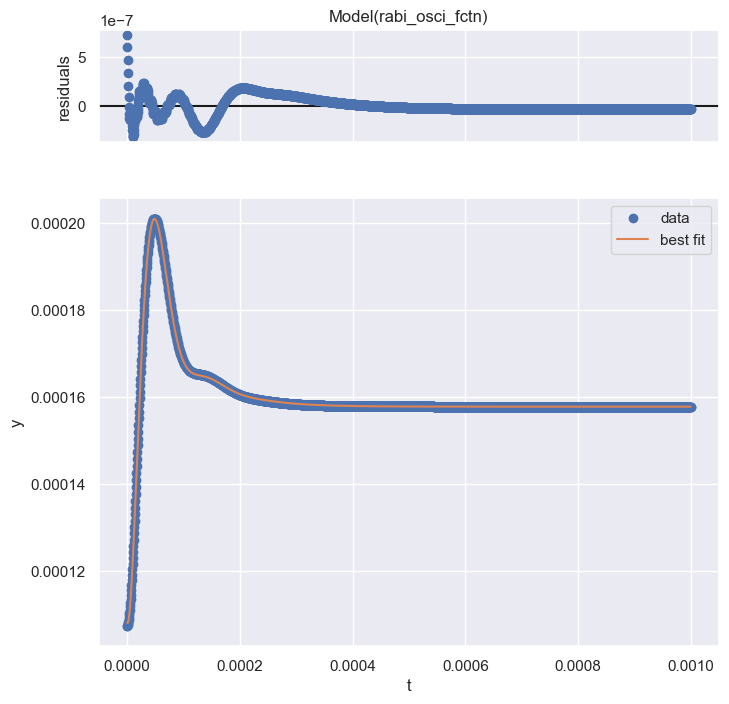

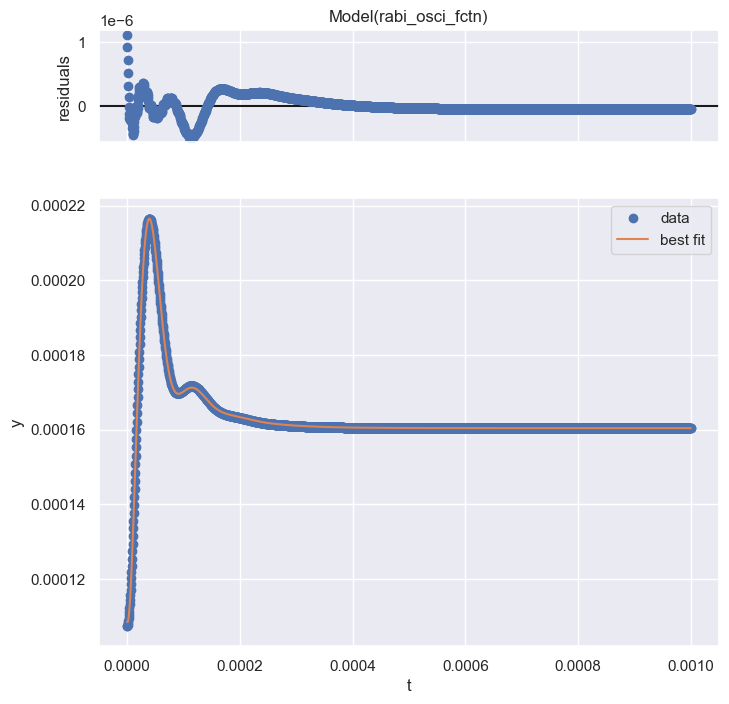

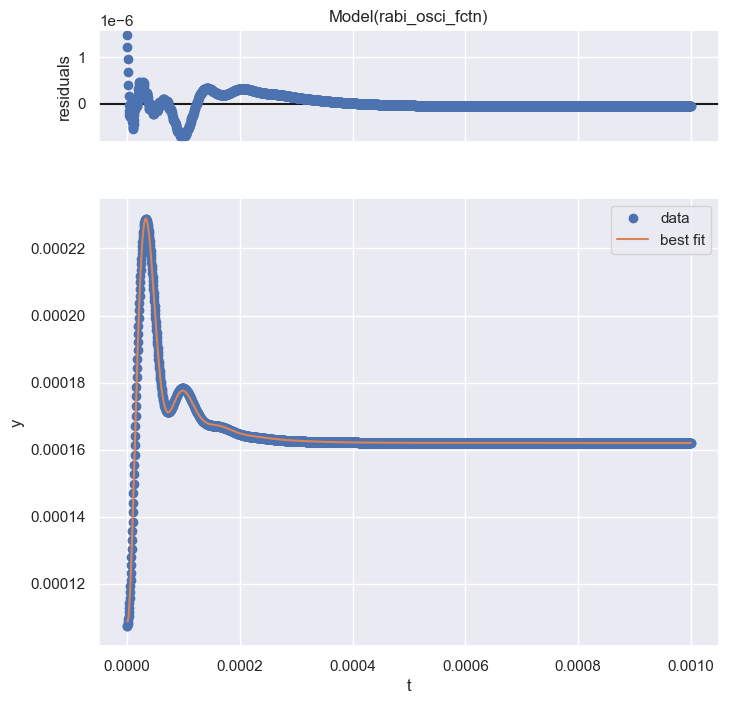

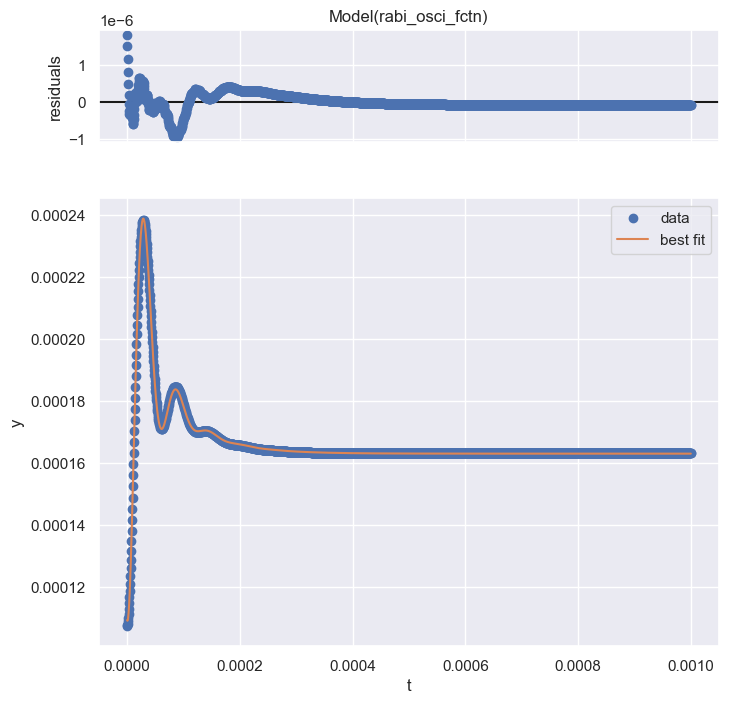

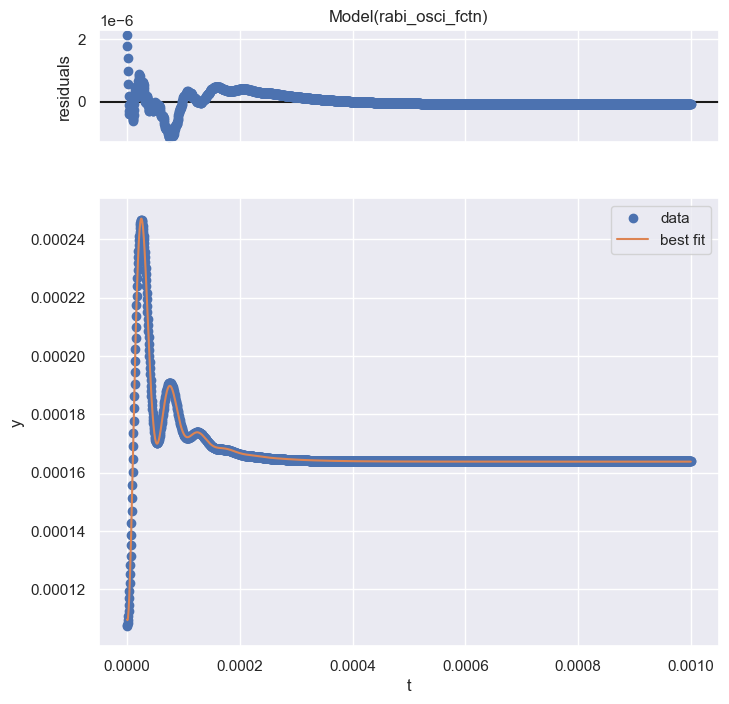

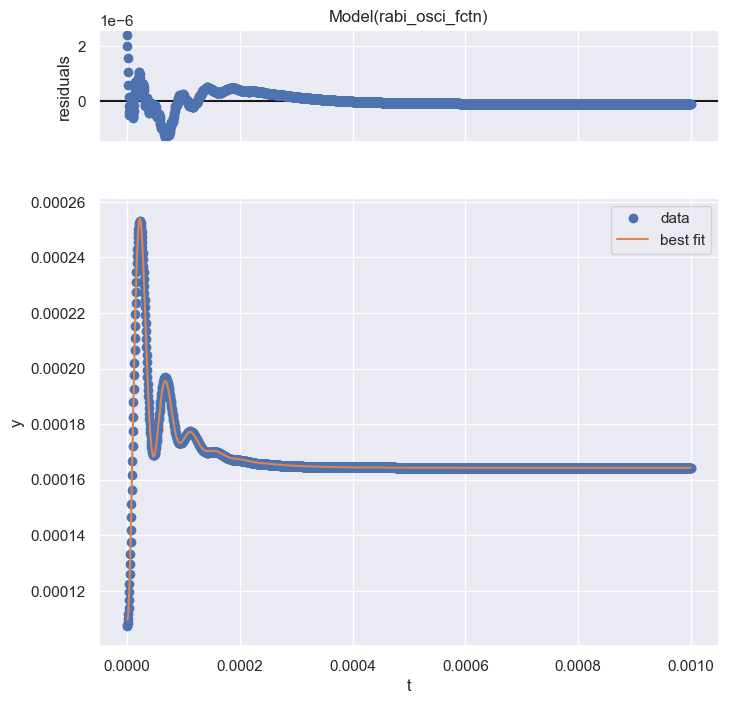

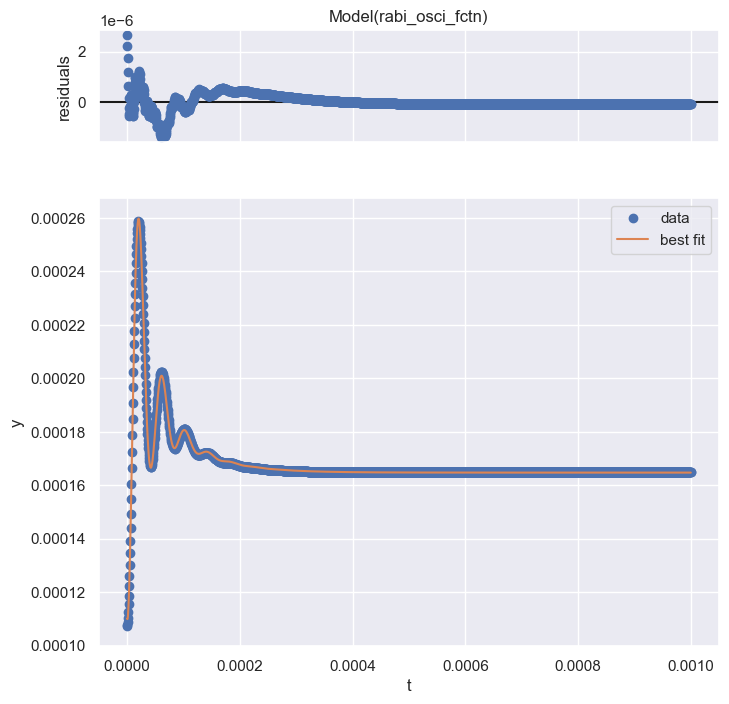

In [26]:
from lmfit.model import Model
def rabi_osci_fctn(t, A, B, C, steady, gamma1, gamma2, rabi):
    # C = 1 - A - steady                                   # we set  f(t=0) = 1
    # B = (gamma1 * A + gamma2 * C) / rabi                 # we set f'(t=0) = 0
    return (
        steady
        + A * np.exp(- gamma1 * t)
        + B * np.sin(rabi * t) * np.exp(- gamma2 * t)
        + C * np.cos(rabi * t) * np.exp(- gamma2 * t)
    )
newfit=[]
for s,f in zip(sim_results, fit_results):

    exc_states = np.array([sum(state.diag()[8:]) for state in s.states])
    # plt.plot(res.times, exc_states)#/exc_states[0])

    g=np.abs(exc_states)
    y = g
    t = s.times
    mod = Model(rabi_osci_fctn, independent_vars=["t"])
    pars = mod.make_params()
    pars = f.params
    pars["rabi"].set(min=3e3, max=177e3, value=150e3)
    pars["steady"].set(value=y[-1])#, min=0.8, max=0.999)

    
    resfit = mod.fit(
        data=y,
        t=t,
        params=pars,
        # method="nelder",
    )
    newfit.append(resfit)
    resfit.plot()

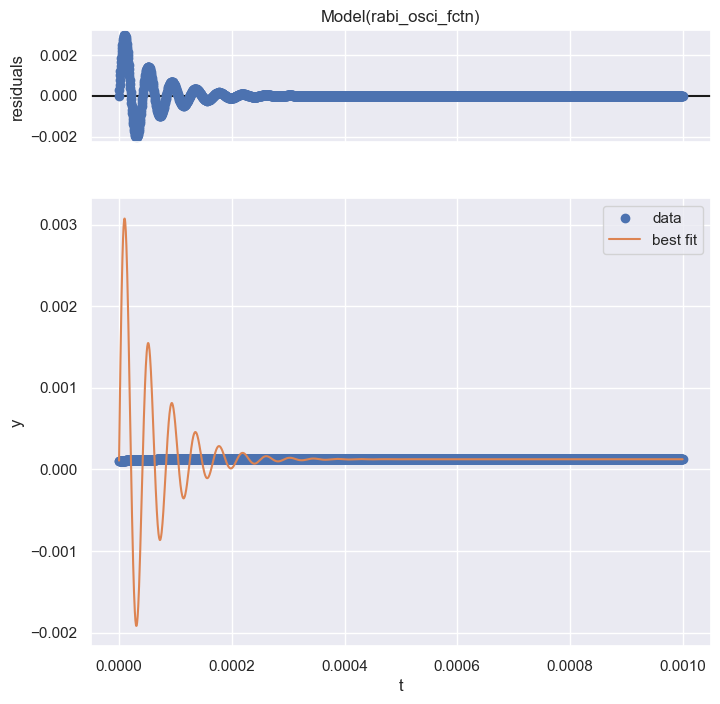

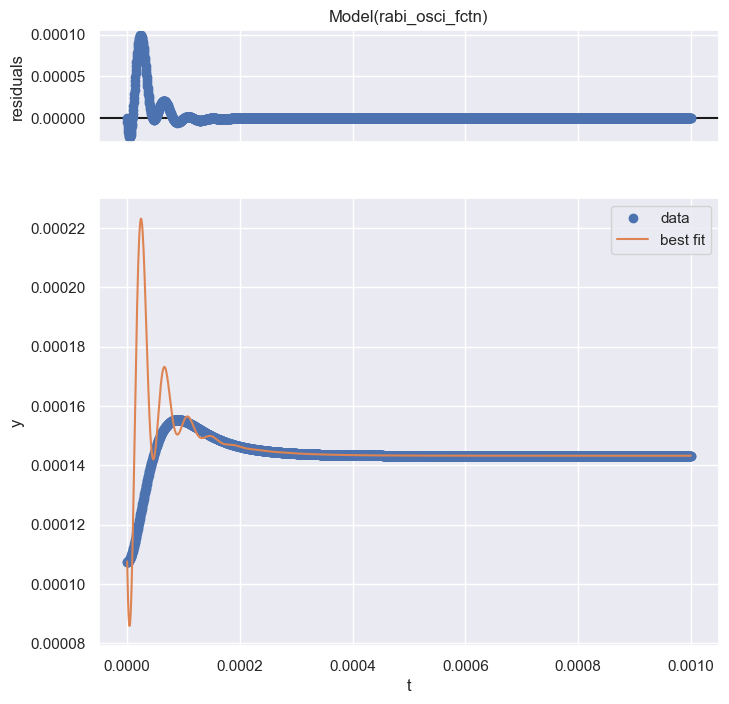

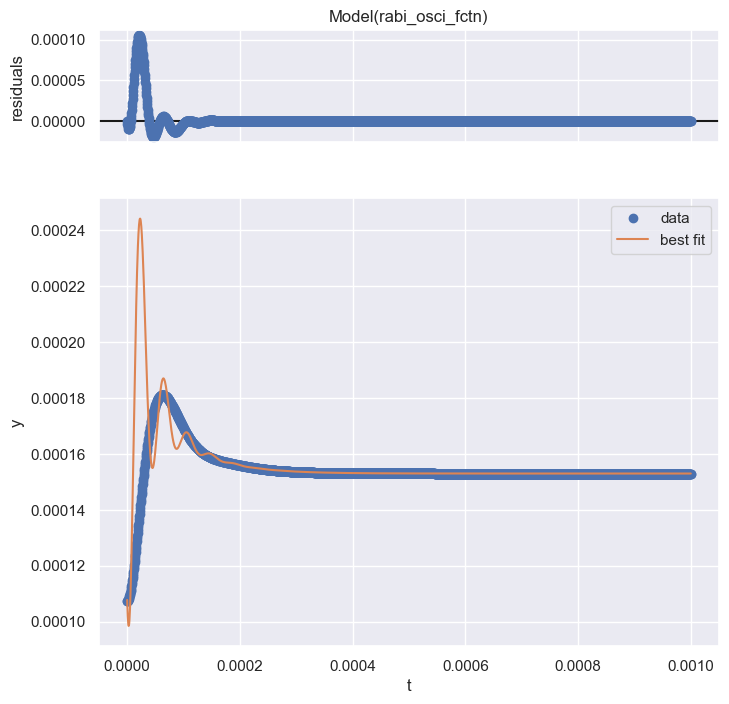

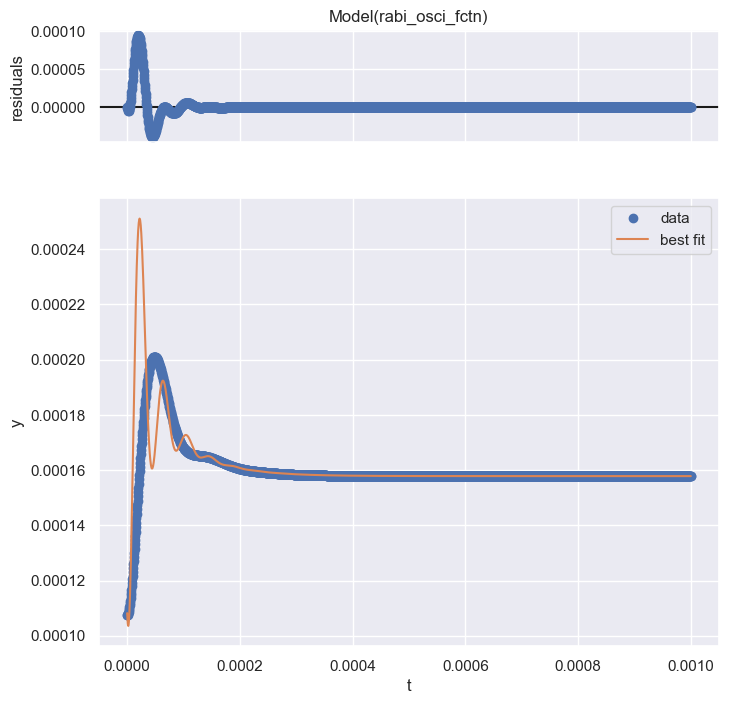

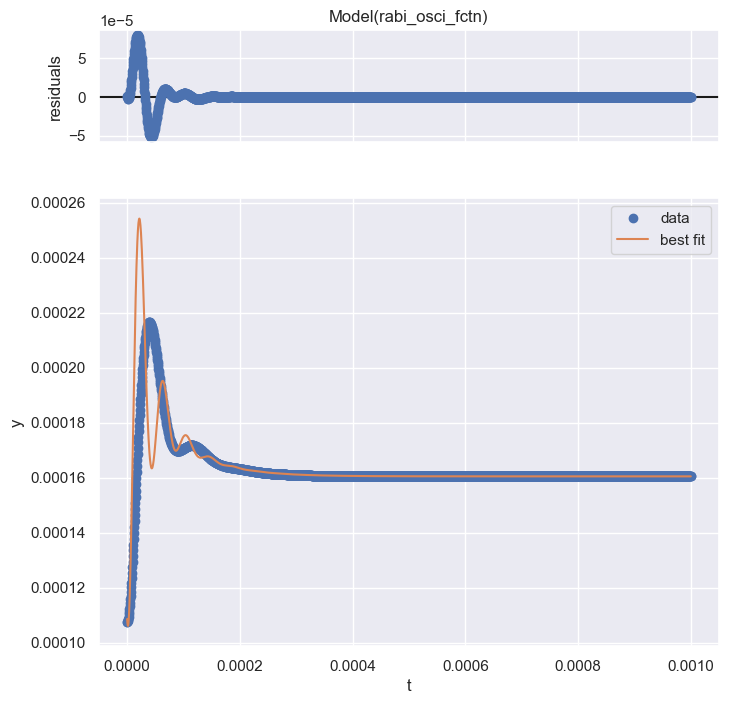

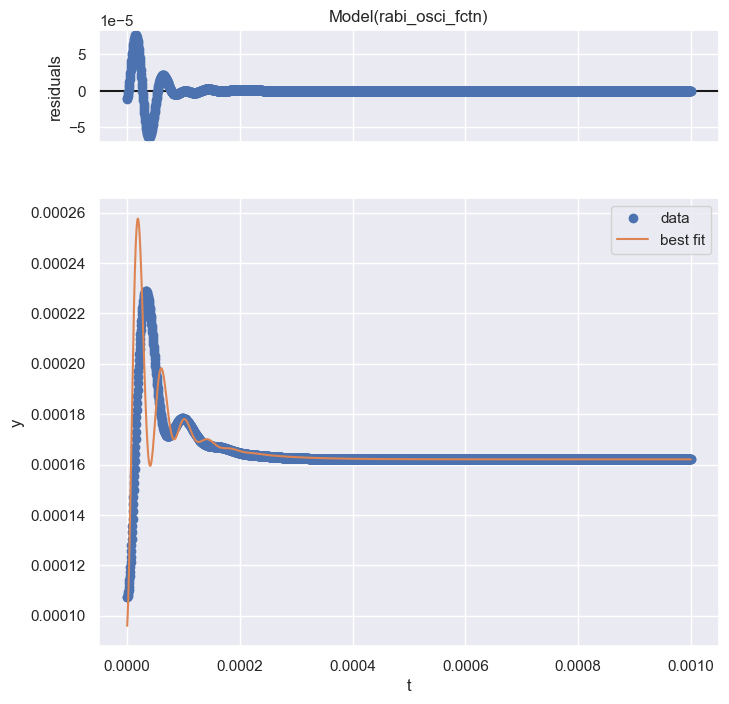

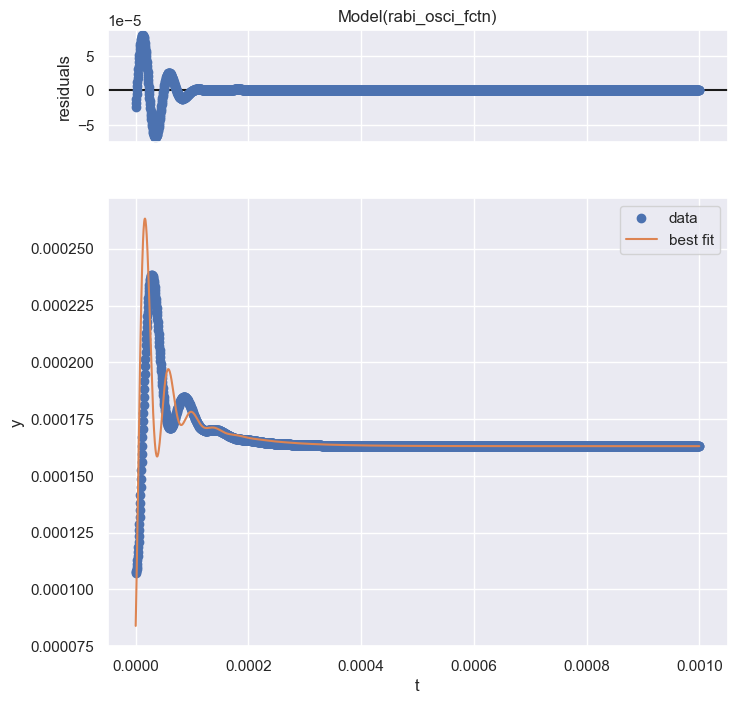

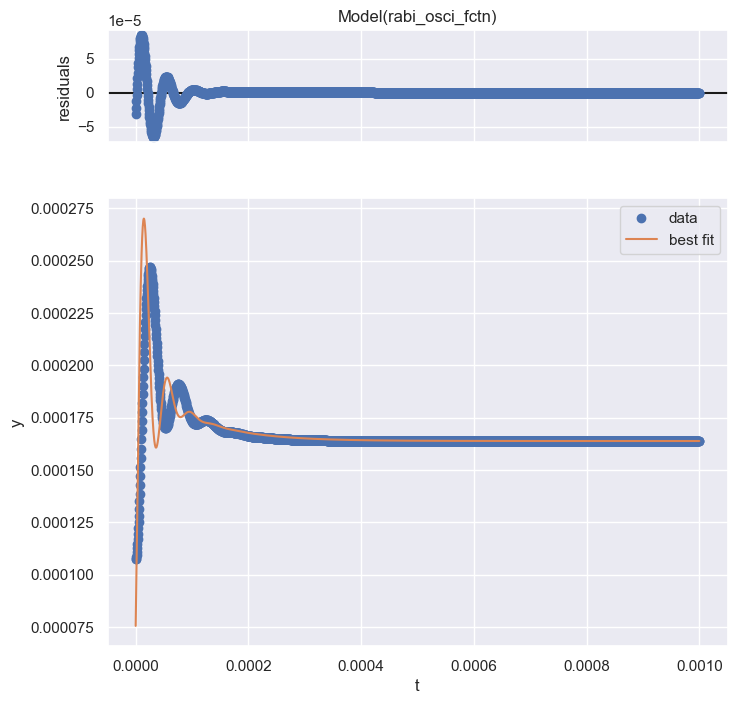

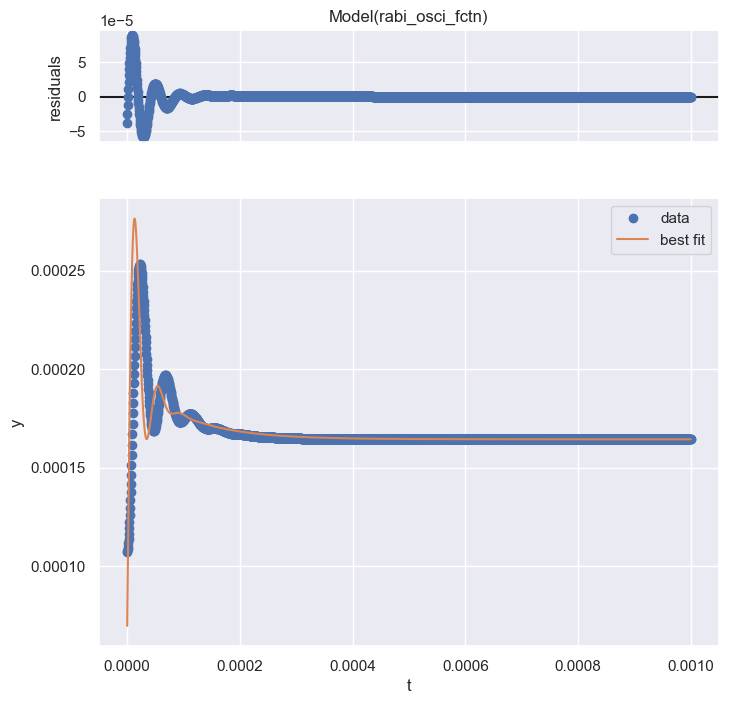

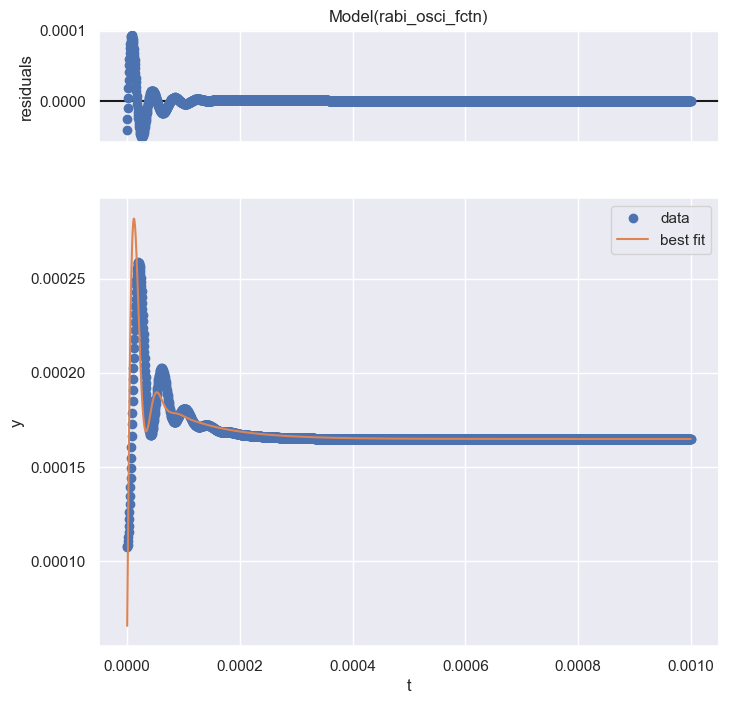

In [27]:
for e in fit_results:
    e.plot()
    e

In [28]:
import pandas as pd

In [29]:
pd.DataFrame(data=[e.params.values for e in newfit])

0
0  <built-in method values of Parameters object a...
1  <built-in method values of Parameters object a...
2  <built-in method values of Parameters object a...
3  <built-in method values of Parameters object a...
4  <built-in method values of Parameters object a...
5  <built-in method values of Parameters object a...
6  <built-in method values of Parameters object a...
7  <built-in method values of Parameters object a...
8  <built-in method values of Parameters object a...
9  <built-in method values of Parameters object a...

In [30]:
pd.DataFrame(data=[e.params.values() for e in newfit])

0  \
0  <Parameter 'A', value=8.904242260733965e-06 +/...   
1  <Parameter 'A', value=4.303158957321001e-05 +/...   
2  <Parameter 'A', value=5.364024428049985e-05 +/...   
3  <Parameter 'A', value=5.53941548797353e-05 +/-...   
4  <Parameter 'A', value=5.542337191862427e-05 +/...   
5  <Parameter 'A', value=5.510211395928488e-05 +/...   
6  <Parameter 'A', value=5.474369568700902e-05 +/...   
7  <Parameter 'A', value=5.44219112745144e-05 +/-...   
8  <Parameter 'A', value=5.414816922763296e-05 +/...   
9  <Parameter 'A', value=5.391748096370705e-05 +/...   

                                                   1  \
0  <Parameter 'B', value=-9.848517431144592e-05 +...   
1  <Parameter 'B', value=-8.348172098361601e-05 +...   
2  <Parameter 'B', value=-6.413543996534246e-05 +...   
3  <Parameter 'B', value=-5.1559462129008894e-05 ...   
4  <Parameter 'B', value=-4.324525881148769e-05 +...   
5  <Parameter 'B', value=-3.731543457244507e-05 +...   
6  <Parameter 'B', value=-3.285123009660572e-05 +...   
7  <Parameter 'B', value=-2.9362069970338593e-05 ...   
8  <Parameter 'B', value=-2.6559635286462397e-05 ...   
9  <Parameter 'B', value=-2.4260925937997904e-05 ...   

                                                   2  \
0  <Parameter 'C', value=-2.5464250573766887e-05 ...   
1  <Parameter 'C', value=-7.866368757349425e-05 +...   
2  <Parameter 'C', value=-9.879109043908737e-05 +...   
3  <Parameter 'C', value=-0.00010502970840238969 ...   
4  <Parameter 'C', value=-0.00010730605994486146 ...   
5  <Parameter 'C', value=-0.00010819342784667633 ...   
6  <Parameter 'C', value=-0.00010853027249408477 ...   
7  <Parameter 'C', value=-0.0001086349329056603 +...   
8  <Parameter 'C', value=-0.00010863950718643632 ...   
9  <Parameter 'C', value=-0.00010860181041330866 ...   

                                                   3  \
0  <Parameter 'steady', value=0.00012400548550947...   
1  <Parameter 'steady', value=0.00014318831879383...   
2  <Parameter 'steady', value=0.00015295220448317...   
3  <Parameter 'steady', value=0.00015778242336480...   
4  <Parameter 'steady', value=0.00016041034213373...   
5  <Parameter 'steady', value=0.00016198919620013...   
6  <Parameter 'steady', value=0.00016302457008226...   
7  <Parameter 'steady', value=0.00016375757084771...   
8  <Parameter 'steady', value=0.00016431274561437...   
9  <Parameter 'steady', value=0.00016475894791805...   

                                                   4  \
0  <Parameter 'gamma1', value=9896.344283087845 +...   
1  <Parameter 'gamma1', value=13345.610803634725 ...   
2  <Parameter 'gamma1', value=14482.992512115507 ...   
3  <Parameter 'gamma1', value=14737.978964695385 ...   
4  <Parameter 'gamma1', value=14742.195374454359 ...   
5  <Parameter 'gamma1', value=14678.519720992801 ...   
6  <Parameter 'gamma1', value=14604.14588827485 +...   
7  <Parameter 'gamma1', value=14536.54065246649 +...   
8  <Parameter 'gamma1', value=14479.86623239902 +...   
9  <Parameter 'gamma1', value=14433.880223236885 ...   

                                                   5  \
0  <Parameter 'gamma2', value=33855.47780167606 +...   
1  <Parameter 'gamma2', value=33164.01997986653 +...   
2  <Parameter 'gamma2', value=33460.108139828524 ...   
3  <Parameter 'gamma2', value=33774.76604353088 +...   
4  <Parameter 'gamma2', value=33855.03559204392 +...   
5  <Parameter 'gamma2', value=33766.99084485651 +...   
6  <Parameter 'gamma2', value=33601.71151971044 +...   
7  <Parameter 'gamma2', value=33416.17317266179 +...   
8  <Parameter 'gamma2', value=33238.237599555454 ...   
9  <Parameter 'gamma2', value=33078.99358304048 +...   

                                                   6  
0  <Parameter 'rabi', value=7928.338411184249 +/-...  
1  <Parameter 'rabi', value=24905.549604736792 +/...  
2  <Parameter 'rabi', value=41484.91077952887 +/-...  
3  <Parameter 'rabi', value=57935.328409140115 +/...  
4  <Parameter 'rabi', value=74155.9393921399 +/- ...  
5  <Parameter 'rabi

In [31]:
pd.DataFrame(data=[k.value for e in newfit for k in e.params])

AttributeError: 'str' object has no attribute 'value'

In [32]:
newfit[0].params

Parameters([('A', <Parameter 'A', value=8.904242260733965e-06 +/- 1.66e-08, bounds=[-inf:inf]>), ('B', <Parameter 'B', value=-9.848517431144592e-05 +/- 5.61e-07, bounds=[-inf:inf]>), ('C', <Parameter 'C', value=-2.5464250573766887e-05 +/- 1.64e-08, bounds=[-inf:inf]>), ('steady', <Parameter 'steady', value=0.00012400548550947047 +/- 9.37e-11, bounds=[-inf:inf]>), ('gamma1', <Parameter 'gamma1', value=9896.344283087845 +/- 6.75, bounds=[-inf:inf]>), ('gamma2', <Parameter 'gamma2', value=33855.47780167606 +/- 12.5, bounds=[-inf:inf]>), ('rabi', <Parameter 'rabi', value=7928.338411184249 +/- 37.9, bounds=[3000.0:177000.0]>)])

In [33]:
newfit[0].params.values()

dict_values([<Parameter 'A', value=8.904242260733965e-06 +/- 1.66e-08, bounds=[-inf:inf]>, <Parameter 'B', value=-9.848517431144592e-05 +/- 5.61e-07, bounds=[-inf:inf]>, <Parameter 'C', value=-2.5464250573766887e-05 +/- 1.64e-08, bounds=[-inf:inf]>, <Parameter 'steady', value=0.00012400548550947047 +/- 9.37e-11, bounds=[-inf:inf]>, <Parameter 'gamma1', value=9896.344283087845 +/- 6.75, bounds=[-inf:inf]>, <Parameter 'gamma2', value=33855.47780167606 +/- 12.5, bounds=[-inf:inf]>, <Parameter 'rabi', value=7928.338411184249 +/- 37.9, bounds=[3000.0:177000.0]>])

In [34]:
newfit[0].params["A"]

<Parameter 'A', value=8.904242260733965e-06 +/- 1.66e-08, bounds=[-inf:inf]>

In [35]:
newfit[0].params["A"].value

8.904242260733965e-06

In [36]:
pd.DataFrame(data=[k.value for e in newfit for k in e.params])

AttributeError: 'str' object has no attribute 'value'

In [37]:
pd.DataFrame(data=[k for e in newfit for k in e.params])

0
0        A
1        B
2        C
3   steady
4   gamma1
..     ...
65       C
66  steady
67  gamma1
68  gamma2
69    rabi

[70 rows x 1 columns]

In [38]:
pd.DataFrame(data=[e.params[k] for e in newfit for k in e.params])

TypeError: __array__() takes 1 positional argument but 2 were given

In [39]:
pd.DataFrame(data=[e.params[k].value for e in newfit for k in e.params])

0
0        0.000009
1       -0.000098
2       -0.000025
3        0.000124
4     9896.344283
..            ...
65      -0.000109
66       0.000165
67   14433.880223
68   33078.993583
69  152339.879262

[70 rows x 1 columns]

In [40]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

0              1
0        A       0.000009
1        B      -0.000098
2        C      -0.000025
3   steady       0.000124
4   gamma1    9896.344283
..     ...            ...
65       C      -0.000109
66  steady       0.000165
67  gamma1   14433.880223
68  gamma2   33078.993583
69    rabi  152339.879262

[70 rows x 2 columns]

In [41]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], pd.MultiIndex.from_product((Bs, 7)))

SyntaxError: positional argument follows keyword argument (<ipython-input-41-33fee98afeaa>, line 1)

In [42]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], pd.MultiIndex.from_product(Bs,7)))

SyntaxError: positional argument follows keyword argument (<ipython-input-42-7410b1d34f30>, line 1)

In [43]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], index=pd.MultiIndex.from_product(Bs,7)))

SyntaxError: unmatched ')' (<ipython-input-43-8fec32d6714f>, line 1)

In [44]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], index=pd.MultiIndex.from_product(Bs,7))

TypeError: Input must be list-like

In [45]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns==pd.MultiIndex.from_product(Bs,7))

SyntaxError: positional argument follows keyword argument (<ipython-input-45-02d30d12425a>, line 1)

In [46]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns=pd.MultiIndex.from_product(Bs,7))

TypeError: Input must be list-like

In [47]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

0              1
0        A       0.000009
1        B      -0.000098
2        C      -0.000025
3   steady       0.000124
4   gamma1    9896.344283
..     ...            ...
65       C      -0.000109
66  steady       0.000165
67  gamma1   14433.880223
68  gamma2   33078.993583
69    rabi  152339.879262

[70 rows x 2 columns]

In [48]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns=pd.MultiIndex.from_product(Bs,7))

TypeError: Input must be list-like

In [49]:

pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns=pd.MultiIndex.from_product(Bs,7))

TypeError: Input must be list-like

In [50]:

pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns=pd.MultiIndex.from_product([Bs,7]))

TypeError: Input must be list-like

In [51]:

pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns=pd.MultiIndex.from_product([Bs,range(7)]))

ValueError: 70 columns passed, passed data had 2 columns

In [52]:

pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns=pd.MultiIndex.from_product([Bs,list(range(7))]))

ValueError: 70 columns passed, passed data had 2 columns

In [53]:


pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns=pd.MultiIndex.from_product([Bs,list(range(7))]))

ValueError: 70 columns passed, passed data had 2 columns

In [54]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns=pd.MultiIndex.from_product([Bs,list(range(10))]))

ValueError: 100 columns passed, passed data had 2 columns

In [55]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

0              1
0        A       0.000009
1        B      -0.000098
2        C      -0.000025
3   steady       0.000124
4   gamma1    9896.344283
..     ...            ...
65       C      -0.000109
66  steady       0.000165
67  gamma1   14433.880223
68  gamma2   33078.993583
69    rabi  152339.879262

[70 rows x 2 columns]

In [56]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], index=pd.MultiIndex.from_product([Bs,list(range(10))]))

ValueError: Length of values (70) does not match length of index (100)

In [57]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], index=pd.MultiIndex.from_product([Bs,list(range(7))]))

0              1
0.001 0       A       0.000009
      1       B      -0.000098
      2       C      -0.000025
      3  steady       0.000124
      4  gamma1    9896.344283
...         ...            ...
0.010 2       C      -0.000109
      3  steady       0.000165
      4  gamma1   14433.880223
      5  gamma2   33078.993583
      6    rabi  152339.879262

[70 rows x 2 columns]

In [58]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], index=Bs)

ValueError: Length of values (70) does not match length of index (10)

In [59]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns==Bs)

SyntaxError: positional argument follows keyword argument (<ipython-input-59-1814c8c122b0>, line 1)

In [60]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params], columns=Bs)

ValueError: 10 columns passed, passed data had 2 columns

In [61]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

0              1
0        A       0.000009
1        B      -0.000098
2        C      -0.000025
3   steady       0.000124
4   gamma1    9896.344283
..     ...            ...
65       C      -0.000109
66  steady       0.000165
67  gamma1   14433.880223
68  gamma2   33078.993583
69    rabi  152339.879262

[70 rows x 2 columns]

In [62]:
pd.DataFrame(data=dict([(k, e.params[k].value) for e in newfit for k in e.params]))

ValueError: If using all scalar values, you must pass an index

In [63]:
dict([(k, e.params[k].value) for e in newfit for k in e.params]

SyntaxError: unexpected EOF while parsing (<ipython-input-63-30c847864c48>, line 1)

In [64]:
dict([(k, e.params[k].value) for e in newfit for k in e.params])

{'A': 5.391748096370705e-05,
 'B': -2.4260925937997904e-05,
 'C': -0.00010860181041330866,
 'steady': 0.00016475894791805705,
 'gamma1': 14433.880223236885,
 'gamma2': 33078.99358304048,
 'rabi': 152339.87926170323}

In [66]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

0              1
0        A       0.000009
1        B      -0.000098
2        C      -0.000025
3   steady       0.000124
4   gamma1    9896.344283
..     ...            ...
65       C      -0.000109
66  steady       0.000165
67  gamma1   14433.880223
68  gamma2   33078.993583
69    rabi  152339.879262

[70 rows x 2 columns]

In [67]:
tm=([(k, e.params[k].value) for e in newfit for k in e.params])

In [74]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

0              1
0        A       0.000009
1        B      -0.000098
2        C      -0.000025
3   steady       0.000124
4   gamma1    9896.344283
..     ...            ...
65       C      -0.000109
66  steady       0.000165
67  gamma1   14433.880223
68  gamma2   33078.993583
69    rabi  152339.879262

[70 rows x 2 columns]

In [75]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

0              1
0        A       0.000009
1        B      -0.000098
2        C      -0.000025
3   steady       0.000124
4   gamma1    9896.344283
..     ...            ...
65       C      -0.000109
66  steady       0.000165
67  gamma1   14433.880223
68  gamma2   33078.993583
69    rabi  152339.879262

[70 rows x 2 columns]

In [76]:
tm=pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

In [77]:
tm.set_index(0)

1
0                    
A            0.000009
B           -0.000098
C           -0.000025
steady       0.000124
gamma1    9896.344283
...               ...
C           -0.000109
steady       0.000165
gamma1   14433.880223
gamma2   33078.993583
rabi    152339.879262

[70 rows x 1 columns]

In [78]:
tm=pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

In [79]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

0              1
0        A       0.000009
1        B      -0.000098
2        C      -0.000025
3   steady       0.000124
4   gamma1    9896.344283
..     ...            ...
65       C      -0.000109
66  steady       0.000165
67  gamma1   14433.880223
68  gamma2   33078.993583
69    rabi  152339.879262

[70 rows x 2 columns]

In [80]:
pd.DataFrame(data=[(k, e.params[k].value) for e in newfit for k in e.params])

0              1
0        A       0.000009
1        B      -0.000098
2        C      -0.000025
3   steady       0.000124
4   gamma1    9896.344283
..     ...            ...
65       C      -0.000109
66  steady       0.000165
67  gamma1   14433.880223
68  gamma2   33078.993583
69    rabi  152339.879262

[70 rows x 2 columns]

In [82]:
pd.DataFrame(data=[[(k, e.params[k].value) for k in e.params] for e in newfit])

0                             1  \
0  (A, 8.904242260733965e-06)   (B, -9.848517431144592e-05)   
1  (A, 4.303158957321001e-05)   (B, -8.348172098361601e-05)   
2  (A, 5.364024428049985e-05)   (B, -6.413543996534246e-05)   
3   (A, 5.53941548797353e-05)  (B, -5.1559462129008894e-05)   
4  (A, 5.542337191862427e-05)   (B, -4.324525881148769e-05)   
5  (A, 5.510211395928488e-05)   (B, -3.731543457244507e-05)   
6  (A, 5.474369568700902e-05)   (B, -3.285123009660572e-05)   
7   (A, 5.44219112745144e-05)  (B, -2.9362069970338593e-05)   
8  (A, 5.414816922763296e-05)  (B, -2.6559635286462397e-05)   
9  (A, 5.391748096370705e-05)  (B, -2.4260925937997904e-05)   

                              2                                 3  \
0  (C, -2.5464250573766887e-05)  (steady, 0.00012400548550947047)   
1   (C, -7.866368757349425e-05)  (steady, 0.00014318831879383019)   
2   (C, -9.879109043908737e-05)  (steady, 0.00015295220448317213)   
3  (C, -0.00010502970840238969)    (steady, 0.000157782423364808)   
4  (C, -0.00010730605994486146)  (steady, 0.00016041034213373512)   
5  (C, -0.00010819342784667633)  (steady, 0.00016198919620013036)   
6  (C, -0.00010853027249408477)  (steady, 0.00016302457008226718)   
7   (C, -0.0001086349329056603)  (steady, 0.00016375757084771884)   
8  (C, -0.00010863950718643632)    (steady, 0.000164312745614375)   
9  (C, -0.00010860181041330866)  (steady, 0.00016475894791805705)   

                              4                             5  \
0   (gamma1, 9896.344283087845)   (gamma2, 33855.47780167606)   
1  (gamma1, 13345.610803634725)   (gamma2, 33164.01997986653)   
2  (gamma1, 14482.992512115507)  (gamma2, 33460.108139828524)   
3  (gamma1, 14737.978964695385)   (gamma2, 33774.76604353088)   
4  (gamma1, 14742.195374454359)   (gamma2, 33855.03559204392)   
5  (gamma1, 14678.519720992801)   (gamma2, 33766.99084485651)   
6   (gamma1, 14604.14588827485)   (gamma2, 33601.71151971044)   
7   (gamma1, 14536.54065246649)   (gamma2, 33416.17317266179)   
8   (gamma1, 14479.86623239902)  (gamma2, 33238.237599555454)   
9  (gamma1, 14433.880223236885)   (gamma2, 33078.99358304048)   

                            6  
0   (rabi, 7928.338411184249)  
1  (rabi, 24905.549604736792)  
2   (rabi, 41484.91077952887)  
3  (rabi, 57935.328409140115)  
4    (rabi, 74155.9393921399)  
5    (rabi, 90124.2922572445)  
6   (rabi, 105878.1798532707)  
7   (rabi, 121470.3212764074)  
8  (rabi, 136946.35646419262)  
9  (rabi, 152339.87926170323)

In [83]:
pd.DataFrame(data=[[e.params[k].value for k in e.params] for e in newfit])

0         1         2         3             4             5  \
0  0.000009 -0.000098 -0.000025  0.000124   9896.344283  33855.477802   
1  0.000043 -0.000083 -0.000079  0.000143  13345.610804  33164.019980   
2  0.000054 -0.000064 -0.000099  0.000153  14482.992512  33460.108140   
3  0.000055 -0.000052 -0.000105  0.000158  14737.978965  33774.766044   
4  0.000055 -0.000043 -0.000107  0.000160  14742.195374  33855.035592   
5  0.000055 -0.000037 -0.000108  0.000162  14678.519721  33766.990845   
6  0.000055 -0.000033 -0.000109  0.000163  14604.145888  33601.711520   
7  0.000054 -0.000029 -0.000109  0.000164  14536.540652  33416.173173   
8  0.000054 -0.000027 -0.000109  0.000164  14479.866232  33238.237600   
9  0.000054 -0.000024 -0.000109  0.000165  14433.880223  33078.993583   

               6  
0    7928.338411  
1   24905.549605  
2   41484.910780  
3   57935.328409  
4   74155.939392  
5   90124.292257  
6  105878.179853  
7  121470.321276  
8  136946.356464  
9  152339.879262

In [84]:
pd.DataFrame(data=[[e.params[k].value for k in e.params] for e in newfit], columns=e.params)

0.000036        0.000168       -0.000135        0.000165       \
0        0.000009       -0.000098       -0.000025        0.000124   
1        0.000043       -0.000083       -0.000079        0.000143   
2        0.000054       -0.000064       -0.000099        0.000153   
3        0.000055       -0.000052       -0.000105        0.000158   
4        0.000055       -0.000043       -0.000107        0.000160   
5        0.000055       -0.000037       -0.000108        0.000162   
6        0.000055       -0.000033       -0.000109        0.000163   
7        0.000054       -0.000029       -0.000109        0.000164   
8        0.000054       -0.000027       -0.000109        0.000164   
9        0.000054       -0.000024       -0.000109        0.000165   

    10978.920160    67934.662766    150000.000000  
0     9896.344283    33855.477802     7928.338411  
1    13345.610804    33164.019980    24905.549605  
2    14482.992512    33460.108140    41484.910780  
3    14737.978965    33774.766044    57935.328409  
4    14742.195374    33855.035592    74155.939392  
5    14678.519721    33766.990845    90124.292257  
6    14604.145888    33601.711520   105878.179853  
7    14536.540652    33416.173173   121470.321276  
8    14479.866232    33238.237600   136946.356464  
9    14433.880223    33078.993583   152339.879262

In [86]:
pd.DataFrame(data=[[e.params[k].value for k in e.params] for e in newfit], columns=e.params.keys())

A         B         C    steady        gamma1        gamma2  \
0  0.000009 -0.000098 -0.000025  0.000124   9896.344283  33855.477802   
1  0.000043 -0.000083 -0.000079  0.000143  13345.610804  33164.019980   
2  0.000054 -0.000064 -0.000099  0.000153  14482.992512  33460.108140   
3  0.000055 -0.000052 -0.000105  0.000158  14737.978965  33774.766044   
4  0.000055 -0.000043 -0.000107  0.000160  14742.195374  33855.035592   
5  0.000055 -0.000037 -0.000108  0.000162  14678.519721  33766.990845   
6  0.000055 -0.000033 -0.000109  0.000163  14604.145888  33601.711520   
7  0.000054 -0.000029 -0.000109  0.000164  14536.540652  33416.173173   
8  0.000054 -0.000027 -0.000109  0.000164  14479.866232  33238.237600   
9  0.000054 -0.000024 -0.000109  0.000165  14433.880223  33078.993583   

            rabi  
0    7928.338411  
1   24905.549605  
2   41484.910780  
3   57935.328409  
4   74155.939392  
5   90124.292257  
6  105878.179853  
7  121470.321276  
8  136946.356464  
9  152339.879262

In [87]:
pd.DataFrame(data=[[e.params[k].value for k in e.params] for e in newfit], columns=e.params.keys(), index=Bs)

A         B         C    steady        gamma1        gamma2  \
0.001  0.000009 -0.000098 -0.000025  0.000124   9896.344283  33855.477802   
0.002  0.000043 -0.000083 -0.000079  0.000143  13345.610804  33164.019980   
0.003  0.000054 -0.000064 -0.000099  0.000153  14482.992512  33460.108140   
0.004  0.000055 -0.000052 -0.000105  0.000158  14737.978965  33774.766044   
0.005  0.000055 -0.000043 -0.000107  0.000160  14742.195374  33855.035592   
0.006  0.000055 -0.000037 -0.000108  0.000162  14678.519721  33766.990845   
0.007  0.000055 -0.000033 -0.000109  0.000163  14604.145888  33601.711520   
0.008  0.000054 -0.000029 -0.000109  0.000164  14536.540652  33416.173173   
0.009  0.000054 -0.000027 -0.000109  0.000164  14479.866232  33238.237600   
0.010  0.000054 -0.000024 -0.000109  0.000165  14433.880223  33078.993583   

                rabi  
0.001    7928.338411  
0.002   24905.549605  
0.003   41484.910780  
0.004   57935.328409  
0.005   74155.939392  
0.006   90124.292257  
0.007  105878.179853  
0.008  121470.321276  
0.009  136946.356464  
0.010  152339.879262

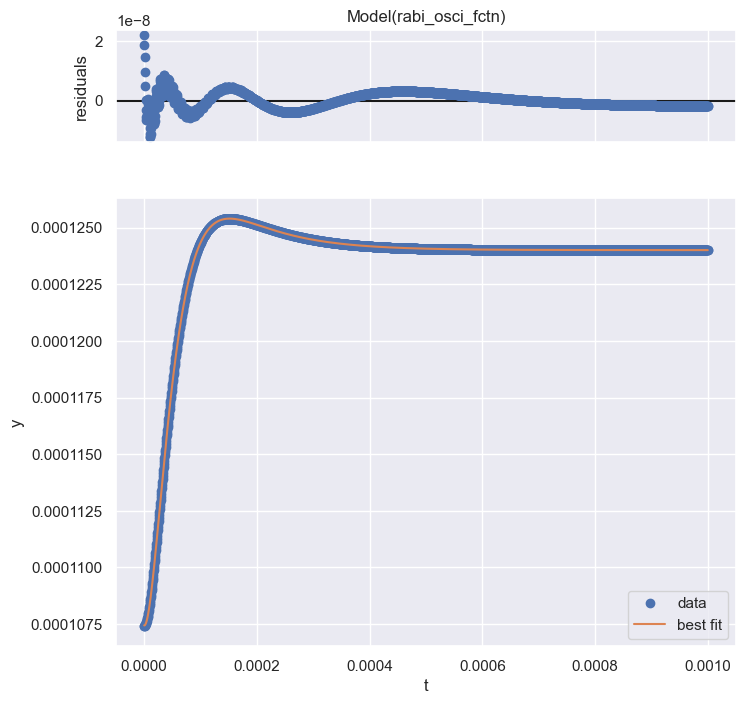

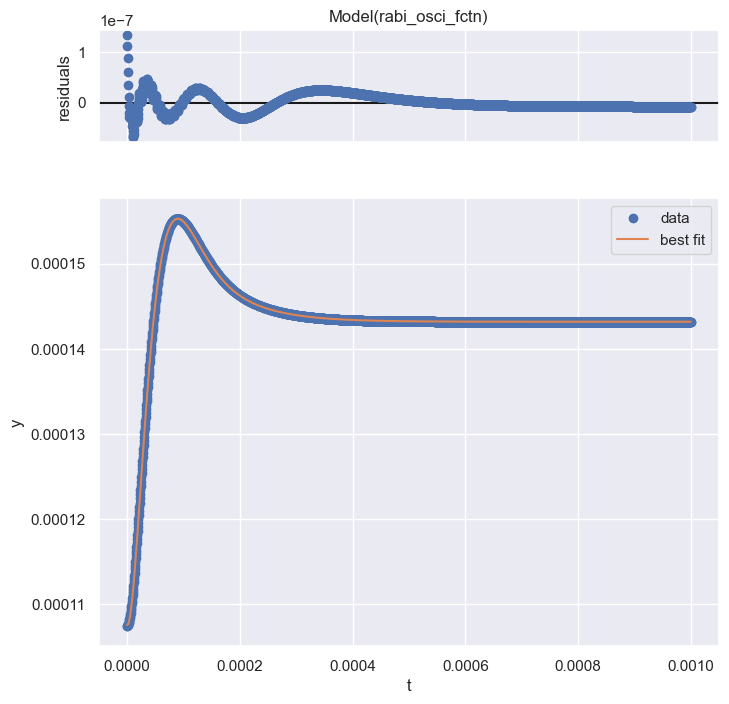

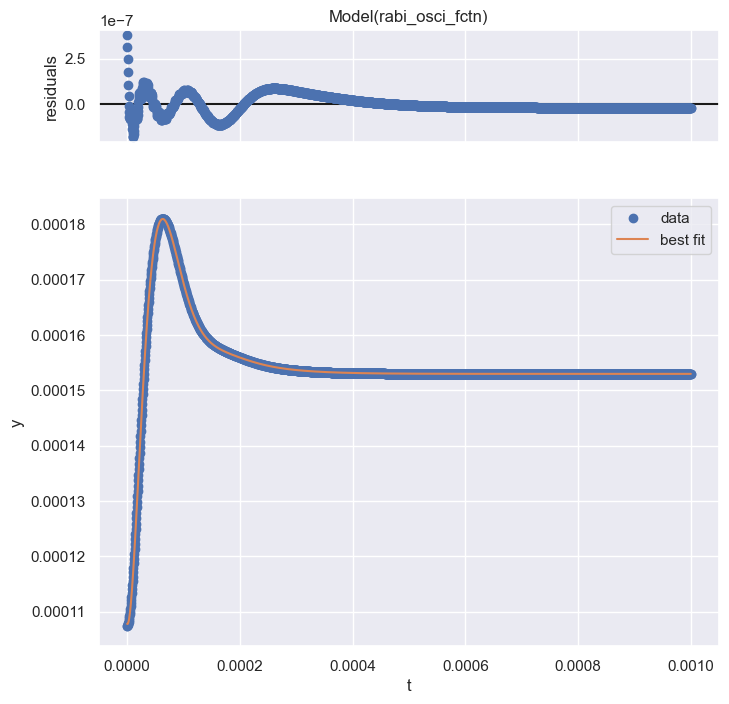

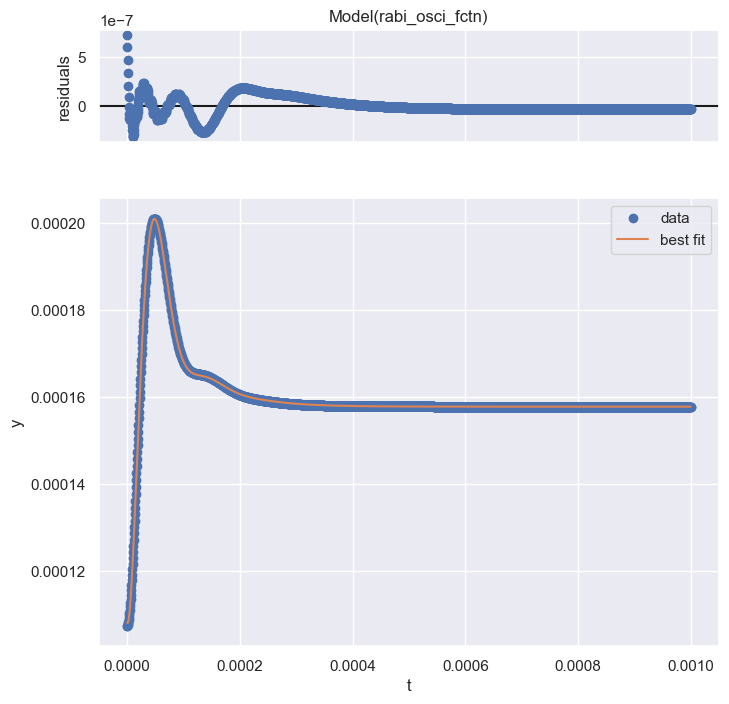

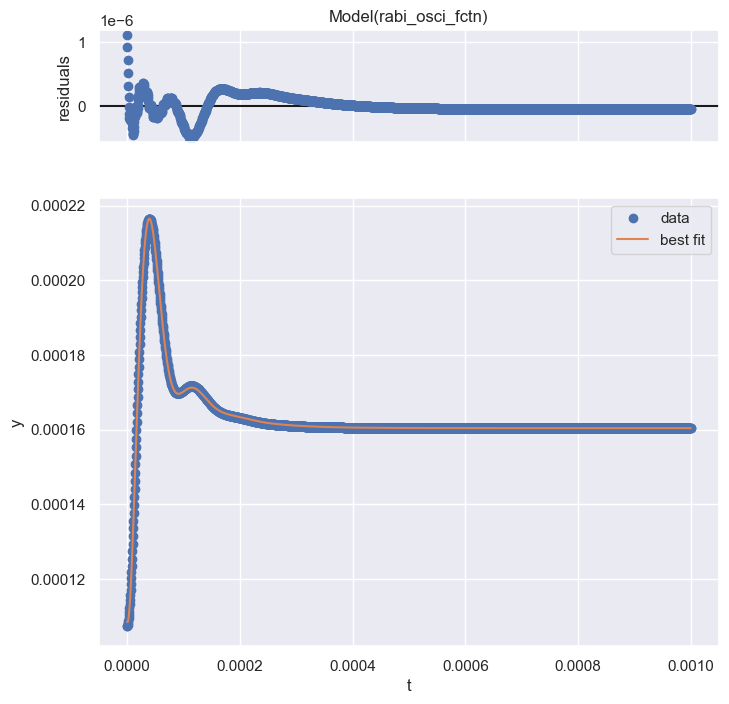

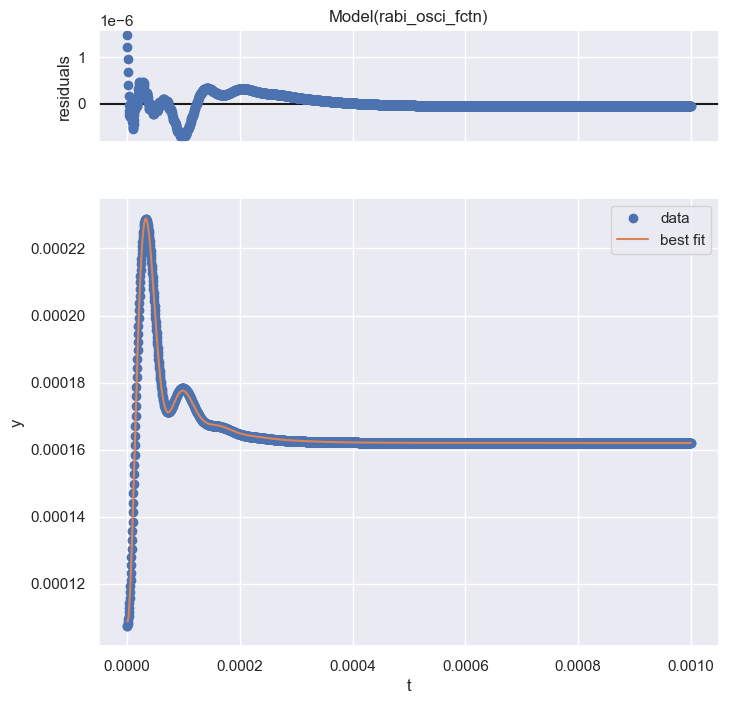

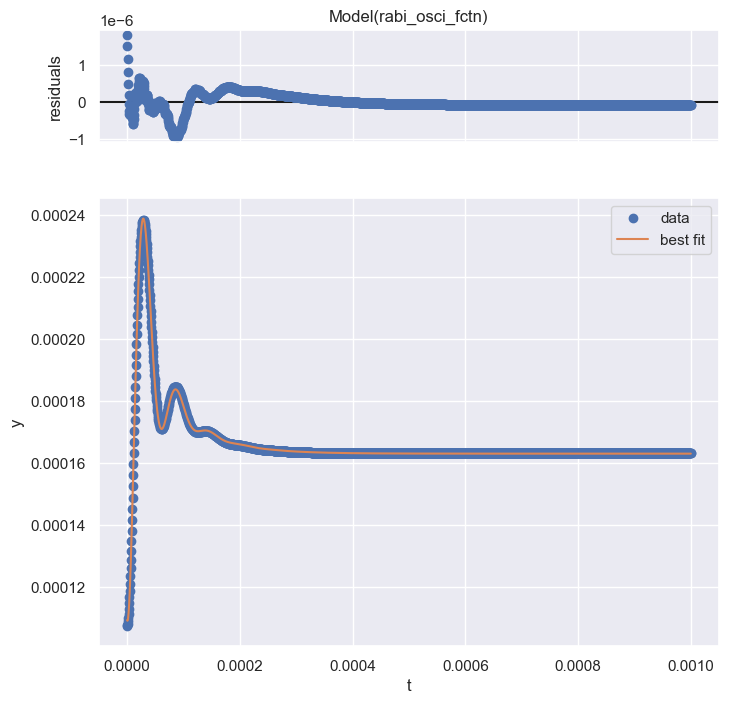

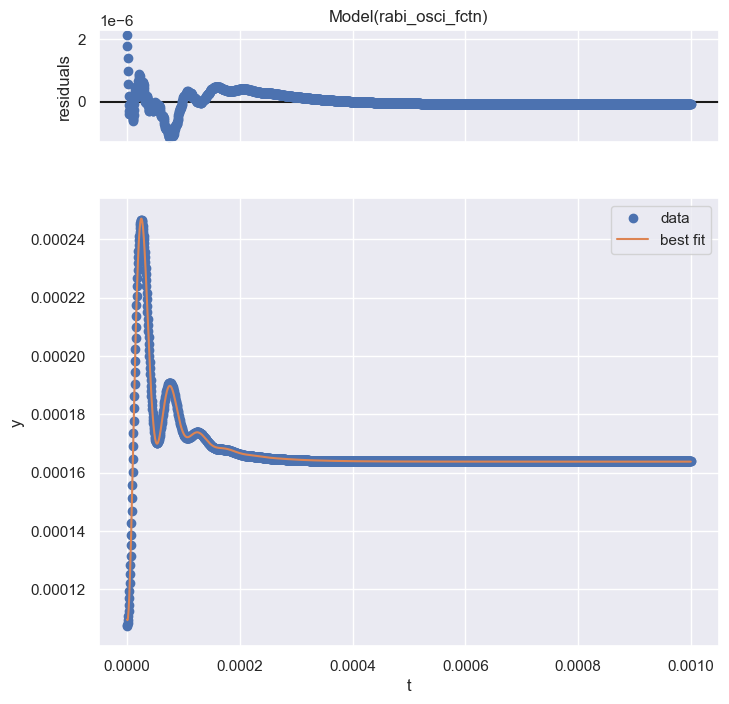

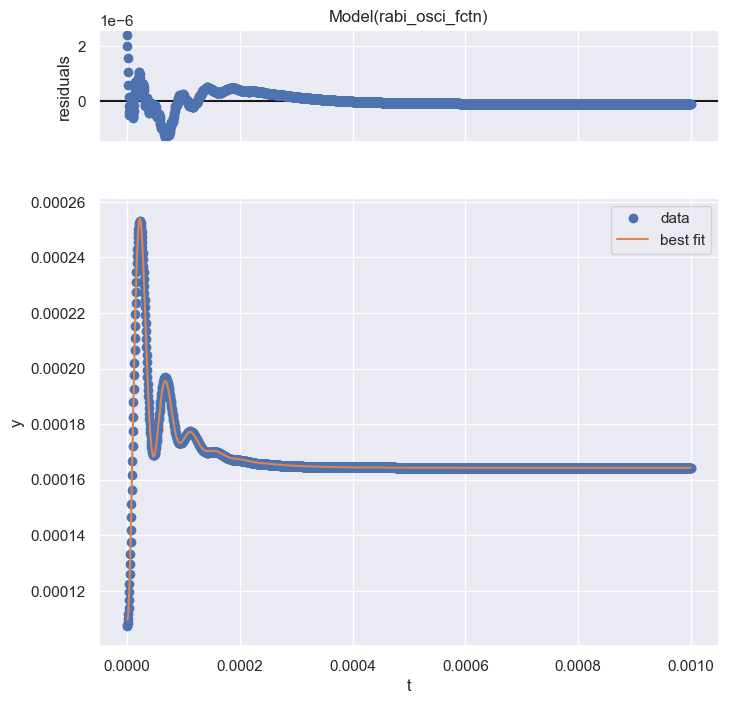

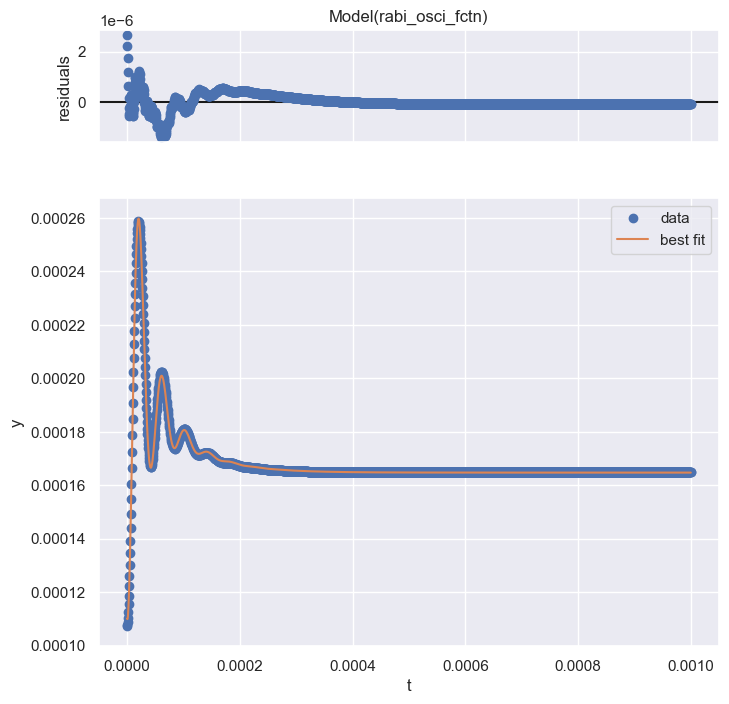

In [88]:
for e in newfit:
    e.plot()

In [89]:
fit_results_df = pd.DataFrame(data=[[e.params[k].value for k in e.params] for e in newfit], columns=e.params.keys(), index=Bs)

In [90]:
fit_results_df.to_csv("fit_results_mw_rabi_osc.csv")

In [91]:
fit_results_df.index.name = "Bmw"

In [92]:
fit_results_df.to_csv("fit_results_mw_rabi_osc.csv")

In [93]:
newfit[3]

In [94]:
import pickle

In [95]:
with open("fit_results_list", "w") as f:
    pickle.dump(newfit, f)

TypeError: write() argument must be str, not bytes

In [96]:
with open("fit_results_list", "wb") as f:
    pickle.dump(newfit, f)

In [97]:
with open("sim_results_list", "wb") as f:
    pickle.dump(sim_results, f)